# Cowan - The Theory of Atomic Structure and Spectra

In [1]:
import numpy as np
import sympy as sp
from IPython.display import display, Math
# fixing autocomplete
%config Completer.use_jedi = False
# better quality plots in notebook
%config InlineBackend.figure_format='retina'
# print execution times
%load_ext autotime
# plot and crunch numbers
import matplotlib.pyplot as plt
# solving ode
from scipy.integrate import odeint
import time
from itertools import product
import networkx as nx
from random import randint
from collections import defaultdict
from qdefcore import *
%load_ext autoreload
%autoreload 2
from cowan import *
# from sympy.physics.wigner import wigner_3j as w3j
from sympy.physics.quantum import Ket, Bra

## LS - Coupling of 3 equivalent electrons (work in progress)

In [2]:
# def LS_basis_3equiv_electrons(l_orbital):
l = 1
s = sp.S(1)/2
ls = [l,l,l]
ss = [s,s,s]
L_part = add_n_non_equiv(ls)
S_part = add_n_non_equiv(ss)

NameError: name 'add_n_non_equiv' is not defined

In [442]:
L_ket_nums

(-3, 3, 2)

In [455]:
from sympy.combinatorics.permutations import Permutation

In [456]:
from itertools import permutations

In [462]:
for permutation in permutations([0,1,2]):
    print(permutation,Permutation(permutation).parity())

(0, 1, 2) 0
(0, 2, 1) 1
(1, 0, 2) 1
(1, 2, 0) 0
(2, 0, 1) 0
(2, 1, 0) 1


In [ ]:
def three_electron_antisymmetrize(qet):
    qet_len = len(list(qet.dict.keys())[0])
    assert qet_len % 3 == 0
    split = qet_len//3
    biz_qet = Qet(
        {(*k[:split][-1::-1], *k[split:][-1::-1]): v for k, v in qet.dict.items()})
    return sp.S(1)/sp.S(2)*(qet + (-1)*biz_qet)

In [450]:
summands = {}
print("Coupling orbital angular momentum ...")
L_kets = L_part['kets']
print("Coupling spin angular momentum ...")
S_kets = S_part['kets']
print("Coupling L to S ...")
for L_ket_nums, L_ket in L_kets.items():
    mL, L, L12 = L_ket_nums
    for S_ket_nums, S_ket in S_kets.items():
        mS, S, S12 = S_ket_nums
        Js = lrange(L,S)
        for J in Js:
            mJs = mrange(J)
            for mJ in mJs:
                c = cg.eva(L,  S,  J,\
                           mL, mS, mJ)
                if c == 0:
                    continue
                combo = (L, S, J, mJ, L12, S12)
                if combo not in summands.keys():
                    summands[combo] = []
                LS_ket = c*(L_ket * S_ket)
                summands[combo].append(LS_ket)
coupled_kets = OrderedDict()

Coupling orbital angular momentum ...
Coupling spin angular momentum ...
Coupling L to S ...


In [451]:
for k, v in summands.items():
    coupled_kets[k] = sum(v, Qet({}))

In [453]:
len(coupled_kets)

216

In [ ]:
ordered_keys = sorted(coupled_kets.keys())
coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) for k in ordered_keys])
uncoupled_basis = sorted(list(set(sum(list(list(qet.dict.keys()) for qet in coupled_kets_ordered.values()),[]))))
print("Antisymmetrizing...")
antisym_kets = OrderedDict([(k, two_electron_antisymmetrize(v)) for k,v in coupled_kets_ordered.items()])
print("Running checks...")
checks = []
for qnums, aqet in antisym_kets.items():
    L, S, J, mJ = qnums
    Jz_qet = Qet({})
    for qnums, coeff in aqet.dict.items():
        Jz_qet = Jz_qet + Jz_total(qnums, coeff, l, l, s, s)
    mJ_check = (Jz_qet.dict == (mJ*aqet).dict)
    J2_qet = J_total_squared(aqet,l,s)
    J2_check = (J2_qet.dict == (J*(J+1)*aqet).dict)
    S2_qet = S_total_squared(aqet,s)
    S2_check = (S2_qet.dict == (S*(S+1)*aqet).dict)
    L2_qet = L_total_squared(aqet,l)
    L2_check = (L2_qet.dict == (L*(L+1)*aqet).dict)
    full_check = all([mJ_check, J2_check, S2_check, L2_check])
    checks.append(full_check)
    if full_check:
        mark = '✓'
    else:
        mark = '✗'
    print(mark,end='|')
if all(checks):
    print("\nAll checks passed.")
else:
    print("\nSomething's not right.")
# return {'kets': antisym_kets,
#        'uncoupled_basis': uncoupled_basis}

## LS - Coupling of 2 equivalent electrons (improved)

In [430]:
def two_electron_antisymmetrize(qet):
    qet_len = len(list(qet.dict.keys())[0])
    assert qet_len % 2 == 0
    split = qet_len//2
    biz_qet = Qet(
        {(*k[:split][-1::-1], *k[split:][-1::-1]): v for k, v in qet.dict.items()})
    return sp.S(1)/sp.S(2)*(qet + (-1)*biz_qet)

In [463]:
def LS_basis_2equiv_electrons(l_orbital):
    l = l_orbital
    s = sp.S(1)/2
    ls = [l,l]
    ss = [s,s]
    L_part = add_n_non_equiv(ls)
    S_part = add_n_non_equiv(ss)
    summands = {}
    print("Coupling orbital angular momentum ...")
    L_kets = L_part['kets']
    print("Coupling spin angular momentum ...")
    S_kets = S_part['kets']
    print("Coupling L to S ...")
    for L_ket_nums, L_ket in L_kets.items():
        mL, L = L_ket_nums
        for S_ket_nums, S_ket in S_kets.items():
            mS, S = S_ket_nums
            Js = lrange(L,S)
            for J in Js:
                mJs = mrange(J)
                for mJ in mJs:
                    c = cg.eva(L,  S,  J,\
                               mL, mS, mJ)
                    if c == 0:
                        continue
                    combo = (L, S, J, mJ)
                    if combo not in summands.keys():
                        summands[combo] = []
                    LS_ket = c*(L_ket * S_ket)
                    summands[combo].append(LS_ket)
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        coupled_kets[k] = sum(v, Qet({}))
    ordered_keys = sorted(coupled_kets.keys())
    coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) for k in ordered_keys])
    uncoupled_basis = sorted(list(set(sum(list(list(qet.dict.keys()) for qet in coupled_kets_ordered.values()),[]))))
    print("Antisymmetrizing...")
    antisym_kets = OrderedDict([(k, two_electron_antisymmetrize(v)) for k,v in coupled_kets_ordered.items()])
    print("Running checks...")
    checks = []
    for qnums, aqet in antisym_kets.items():
        L, S, J, mJ = qnums
        Jz_qet = Qet({})
        for qnums, coeff in aqet.dict.items():
            Jz_qet = Jz_qet + Jz_total(qnums, coeff, l, l, s, s)
        mJ_check = (Jz_qet.dict == (mJ*aqet).dict)
        J2_qet = J_total_squared(aqet,l,s)
        J2_check = (J2_qet.dict == (J*(J+1)*aqet).dict)
        S2_qet = S_total_squared(aqet,s)
        S2_check = (S2_qet.dict == (S*(S+1)*aqet).dict)
        L2_qet = L_total_squared(aqet,l)
        L2_check = (L2_qet.dict == (L*(L+1)*aqet).dict)
        full_check = all([mJ_check, J2_check, S2_check, L2_check])
        checks.append(full_check)
        if full_check:
            mark = '✓'
        else:
            mark = '✗'
        print(mark,end='|')
    if all(checks):
        print("\nAll checks passed.")
    else:
        print("\nSomething's not right.")
    return {'kets': antisym_kets,
           'uncoupled_basis': uncoupled_basis}

In [464]:
LS1 = LS_basis_2equiv_electrons(3)

Coupling orbital angular momentum ...
Coupling spin angular momentum ...
Coupling L to S ...
Antisymmetrizing...
Running checks...
✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|
All checks passed.


## LS - Coupling of 2 inequivalent electrons (improved)

In [418]:
def LS_basis_non_equiv_electrons(l_orbital):
    l = l_orbital
    s = sp.S(1)/2
    ls = [l,l]
    ss = [s,s]
    L_part = add_n_non_equiv(ls)
    S_part = add_n_non_equiv(ss)
    summands = {}
    print("Coupling orbital angular momentum ...")
    L_kets = L_part['kets']
    print("Coupling spin angular momentum ...")
    S_kets = S_part['kets']
    print("Coupling L to S ...")
    for L_ket_nums, L_ket in L_kets.items():
        mL, L = L_ket_nums
        for S_ket_nums, S_ket in S_kets.items():
            mS, S = S_ket_nums
            Js = lrange(L,S)
            for J in Js:
                mJs = mrange(J)
                for mJ in mJs:
                    c = cg.eva(L,  S,  J,\
                               mL, mS, mJ)
                    if c == 0:
                        continue
                    combo = (L, S, J, mJ)
                    if combo not in summands.keys():
                        summands[combo] = []
                    LS_ket = c*(L_ket * S_ket)
                    summands[combo].append(LS_ket)
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        coupled_kets[k] = sum(v, Qet({}))
    ordered_keys = sorted(coupled_kets.keys())
    coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) for k in ordered_keys])
    uncoupled_basis = sorted(list(set(sum(list(list(qet.dict.keys()) for qet in coupled_kets_ordered.values()),[]))))
    print("Running checks...")
    checks = []
    for qnums, aqet in coupled_kets_ordered.items():
        L, S, J, mJ = qnums
        Jz_qet = Qet({})
        for qnums, coeff in aqet.dict.items():
            Jz_qet = Jz_qet + Jz_total(qnums, coeff, l, l, s, s)
        mJ_check = (Jz_qet.dict == (mJ*aqet).dict)
        J2_qet = J_total_squared(aqet,l,s)
        J2_check = (J2_qet.dict == (J*(J+1)*aqet).dict)
        S2_qet = S_total_squared(aqet,s)
        S2_check = (S2_qet.dict == (S*(S+1)*aqet).dict)
        L2_qet = L_total_squared(aqet,l)
        L2_check = (L2_qet.dict == (L*(L+1)*aqet).dict)
        full_check = all([mJ_check, J2_check, S2_check, L2_check])
        checks.append(full_check)
        if full_check:
            mark = '✓'
        else:
            mark = '✗'
        print(mark,end='|')
    if all(checks):
        print("\nAll checks passed.")
    else:
        print("\nSomething's not right.")
    return {'kets': coupled_kets_ordered,
           'uncoupled_basis': uncoupled_basis}

In [420]:
LS2 = LS_basis_non_equiv_electrons(2)

Coupling orbital angular momentum ...
Coupling spin angular momentum ...
Coupling L to S ...
Running checks...
✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|
All checks passed.


In [405]:
l = 1
s = sp.S(1)/2
ls = [l,l]
ss = [s,s]
L_part = add_n_non_equiv(ls)
S_part = add_n_non_equiv(ss)
summands = {}
L_kets = L_part['kets']
S_kets = S_part['kets']
for L_ket_nums, L_ket in L_kets.items():
    mL, L = L_ket_nums
    for S_ket_nums, S_ket in S_kets.items():
        mS, S = S_ket_nums
        Js = lrange(L,S)
        for J in Js:
            mJs = mrange(J)
            for mJ in mJs:
                c = cg.eva(L,  S,  J,\
                           mL, mS, mJ)
                if c == 0:
                    continue
                combo = (L, S, J, mJ)
                if combo not in summands.keys():
                    summands[combo] = []
                LS_ket = c*(L_ket * S_ket)
                summands[combo].append(LS_ket)
coupled_kets = OrderedDict()
for k, v in summands.items():
    coupled_kets[k] = sum(v, Qet({}))
ordered_keys = sorted(coupled_kets.keys())
coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) for k in ordered_keys])
uncoupled_basis = sorted(list(set(sum(list(list(qet.dict.keys()) for qet in coupled_kets_ordered.values()),[]))))

[1, 1]
[1/2, 1/2]


In [383]:
def Lz_total(qnums, coeff, l1, l2):
    J1 = coeff*Qet({qnums: qnums[0]})
    J2 = coeff*Qet({qnums: qnums[1]})
    return J1+J2


def Lplus_total(qnums, coeff, l1, l2):
    ml1, ml2, ms1, ms2 = qnums
    J1 = coeff * Qet({Qnums(ml1+1, ml2, ms1, ms2): sp.sqrt(l1*(l1+1)-ml1*(ml1+1)),
                     Qnums(ml1, ml2+1, ms1, ms2): sp.sqrt(l2*(l2+1)-ml2*(ml2+1))})
    return J1


def Lminus_total(qnums, coeff, l1, l2):
    ml1, ml2, ms1, ms2 = qnums
    J1 = coeff * Qet({Qnums(ml1-1, ml2, ms1, ms2): sp.sqrt(l1*(l1+1)-ml1*(ml1-1)),
                     Qnums(ml1, ml2-1, ms1, ms2): sp.sqrt(l2*(l2+1)-ml2*(ml2-1))})
    return J1


def Lx_total(qnums, coeff, l1, l2):
    return sp.S(1)/2*(Lplus_total(qnums, coeff, l1, l2) + Lminus_total(qnums, coeff, l1, l2))


def Ly_total(qnums, coeff, l1, l2):
    return -sp.I*sp.S(1)/2*(Lplus_total(qnums, coeff, l1, l2) + (-1)*Lminus_total(qnums, coeff, l1, l2))


def L_total_squared(qet, l):
    Lx1 = sum([Lx_total(k, v, l, l) for k, v in qet.dict.items()], Qet())
    Lx2 = sum([Lx_total(k, v, l, l) for k, v in Lx1.dict.items()], Qet())
    Ly1 = sum([Ly_total(k, v, l, l) for k, v in qet.dict.items()], Qet())
    Ly2 = sum([Ly_total(k, v, l, l) for k, v in Ly1.dict.items()], Qet())
    Lz1 = sum([Lz_total(k, v, l, l) for k, v in qet.dict.items()], Qet())
    Lz2 = sum([Lz_total(k, v, l, l) for k, v in Lz1.dict.items()], Qet())
    return Lx2+Ly2+Lz2


def Sz_total(qnums, coeff, l1, l2):
    J1 = coeff*Qet({qnums: qnums[2]})
    J2 = coeff*Qet({qnums: qnums[3]})
    return J1+J2


def Splus_total(qnums, coeff, l1, l2):
    ml1, ml2, ms1, ms2 = qnums
    J1 = coeff * Qet({Qnums(ml1, ml2, ms1+1, ms2): sp.sqrt(l1*(l1+1)-ms1*(ms1+1)),
                     Qnums(ml1, ml2, ms1, ms2+1): sp.sqrt(l2*(l2+1)-ms2*(ms2+1))})
    return J1


def Sminus_total(qnums, coeff, l1, l2):
    ml1, ml2, ms1, ms2 = qnums
    J1 = coeff * Qet({Qnums(ml1, ml2, ms1-1, ms2): sp.sqrt(l1*(l1+1)-ms1*(ms1-1)),
                     Qnums(ml1, ml2, ms1, ms2-1): sp.sqrt(l1*(l1+1)-ms2*(ms2-1))})
    return J1


def Sx_total(qnums, coeff, l1, l2):
    return sp.S(1)/2*(Splus_total(qnums, coeff, l1, l2)
                      + Sminus_total(qnums, coeff, l1, l2))


def Sy_total(qnums, coeff, l1, l2):
    return -sp.I*sp.S(1)/2*(Splus_total(qnums, coeff, l1, l2)
                            + (-1)*Sminus_total(qnums, coeff, l1, l2))


def S_total_squared(qet, l):
    Sx1 = sum([Sx_total(k, v, l, l) for k, v in qet.dict.items()], Qet())
    Sx2 = sum([Sx_total(k, v, l, l) for k, v in Sx1.dict.items()], Qet())
    Sy1 = sum([Sy_total(k, v, l, l) for k, v in qet.dict.items()], Qet())
    Sy2 = sum([Sy_total(k, v, l, l) for k, v in Sy1.dict.items()], Qet())
    Sz1 = sum([Sz_total(k, v, l, l) for k, v in qet.dict.items()], Qet())
    Sz2 = sum([Sz_total(k, v, l, l) for k, v in Sz1.dict.items()], Qet())
    return Sx2+Sy2+Sz2


def Jz_total(qnums, coeff, l1, l2, s1, s2):
    return Lz_total(qnums, coeff, l1, l2) + Sz_total(qnums, coeff, s1, s2)


def Jplus_total(qnums, coeff, l1, l2, s1, s2):
    return Lplus_total(qnums, coeff, l1, l2) + Splus_total(qnums, coeff, s1, s2)


def Jminus_total(qnums, coeff, l1, l2, s1, s2):
    return Lminus_total(qnums, coeff, l1, l2) + Sminus_total(qnums, coeff, s1, s2)


def Jx_total(qnums, coeff, l1, l2, s1, s2):
    return sp.S(1)/2*(Jplus_total(qnums, coeff, l1, l2, s1, s2)
                      + Jminus_total(qnums, coeff, l1, l2, s1, s2))


def Jy_total(qnums, coeff, l1, l2, s1, s2):
    return -sp.I*sp.S(1)/2*(Jplus_total(qnums, coeff, l1, l2, s1, s2)
                            + (-1)*Jminus_total(qnums, coeff, l1, l2, s1, s2))


def J_total_squared(qet, l, s):
    Sx1 = sum([Jx_total(k, v, l, l, s, s) for k, v in qet.dict.items()], Qet())
    Sx2 = sum([Jx_total(k, v, l, l, s, s) for k, v in Sx1.dict.items()], Qet())
    Sy1 = sum([Jy_total(k, v, l, l, s, s) for k, v in qet.dict.items()], Qet())
    Sy2 = sum([Jy_total(k, v, l, l, s, s) for k, v in Sy1.dict.items()], Qet())
    Sz1 = sum([Jz_total(k, v, l, l, s, s) for k, v in qet.dict.items()], Qet())
    Sz2 = sum([Jz_total(k, v, l, l, s, s) for k, v in Sz1.dict.items()], Qet())
    return Sx2+Sy2+Sz2

In [408]:
checks = []
for qnums, aqet in coupled_kets_ordered.items():
    L, S, J, mJ = qnums
    Jz_qet = Qet({})
    for qnums, coeff in aqet.dict.items():
        Jz_qet = Jz_qet + Jz_total(qnums, coeff, l, l, s, s)
    mJ_check = (Jz_qet.dict == (mJ*aqet).dict)
    J2_qet = J_total_squared(aqet,l,s)
    J2_check = (J2_qet.dict == (J*(J+1)*aqet).dict)
    S2_qet = S_total_squared(aqet,s)
    S2_check = (S2_qet.dict == (S*(S+1)*aqet).dict)
    L2_qet = L_total_squared(aqet,l)
    L2_check = (L2_qet.dict == (L*(L+1)*aqet).dict)
    full_check = all([mJ_check, J2_check, S2_check, L2_check])
    checks.append(full_check)
    if full_check:
        mark = '✓'
    else:
        mark = '✗'
    print(mark,end='|')
if all(checks):
    print("\nAll checks passed.")
else:
    print("\nSomething's not right.")

✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|✓|
All checks passed.


In [398]:
all([mJ_check, J2_check, S2_check, L2_check])

True

In [377]:
Jz_qet

Qet({(-1, 1, -1/2, -1/2): -sqrt(3)/3, (0, 0, -1/2, -1/2): sqrt(3)/3, (1, -1, -1/2, -1/2): -sqrt(3)/3})

In [378]:
J*aqet

Qet({(-1, 1, -1/2, -1/2): sqrt(3)/3, (0, 0, -1/2, -1/2): -sqrt(3)/3, (1, -1, -1/2, -1/2): sqrt(3)/3})

In [361]:
(J*aqet)

Qet({(-2, 2, -1/2, -1/2): sqrt(5)/5, (-1, 1, -1/2, -1/2): -sqrt(5)/5, (0, 0, -1/2, -1/2): sqrt(5)/5, (1, -1, -1/2, -1/2): -sqrt(5)/5, (2, -2, -1/2, -1/2): sqrt(5)/5})

In [356]:
Jz_qet

Qet({(2, 2, 1/2, 1/2): 5})

In [354]:
aqet.dict.items()

dict_items([((-2, 2, -1/2, -1/2), sqrt(5)/5), ((-1, 1, -1/2, -1/2), -sqrt(5)/5), ((0, 0, -1/2, -1/2), sqrt(5)/5), ((1, -1, -1/2, -1/2), -sqrt(5)/5), ((2, -2, -1/2, -1/2), sqrt(5)/5)])

In [348]:
Jz_qet

Qet({})

In [344]:
mat = sp.Matrix([v.vec_in_basis(uncoupled_basis) for v in coupled_kets_ordered.values()]).T

In [342]:
coupled_kets_ordered[ordered_keys[0]]

Qet({(-2, 2, -1/2, 1/2): -sqrt(10)/10, (-2, 2, 1/2, -1/2): sqrt(10)/10, (-1, 1, -1/2, 1/2): sqrt(10)/10, (-1, 1, 1/2, -1/2): -sqrt(10)/10, (0, 0, -1/2, 1/2): -sqrt(10)/10, (0, 0, 1/2, -1/2): sqrt(10)/10, (1, -1, -1/2, 1/2): sqrt(10)/10, (1, -1, 1/2, -1/2): -sqrt(10)/10, (2, -2, -1/2, 1/2): -sqrt(10)/10, (2, -2, 1/2, -1/2): sqrt(10)/10})

## Recursively adding n angular momenta

In summary this section resulted in the three functions: `mrange`, `lrange`, `half_integer_fixer`. And in one class `AngularMomentum`

In [465]:
def mrange(j):
    # returns ranges that work for half integers
    j = sp.S(int(2*j))/2
    return list(-j+i for i in range(2*j+1))
def lrange(j1,j2):
    # return the range of possible total j
    return list(abs(j1-j2) + i for i in range((j1+j2)-abs(j1-j2)+1))

In [211]:
# This works for adding the three l

Qnums_123   = namedtuple('ml_123', ['ml1','ml2','ml3'])
LMlnums_123 = namedtuple('L_ML_123_l_12', ['l_123', 'Ml_123','l_12'])

l = 1
l_1, l_2, l_3 = l, l, l
ml_1s, ml_2s, ml_3s = [(mrange(l))]*3
product_basis = [Qnums_123(ml1, ml2, ml3) for ml1, ml2, ml3 in product(ml1s, ml2s, ml3s)]

summands = {}

l_12s = lrange(l_1,l_2)
for l_12 in l_12s:
    ml_12s, l_123s = mrange(l_12), lrange(l_12, l_3)
    for l_123 in l_123s:
        ml_123s = mrange(l_123)
        ms = (ml_1s, ml_2s, ml_3s, ml_12s, ml_123s)
        for ml1, ml2, ml3, ml_12, ml_123 in product(*ms):
            c1 = cg.eva(l_12,  l3,  l_123, \
                        ml_12, ml3, ml_123)
            if c1 == 0:
                continue
            c2 = cg.eva(l1,  l2,  l_12, \
                        ml1, ml2, ml_12)
            if c2 == 0:
                continue
            c = c1*c2
            combo = (l_123, ml_123, l_12)
            if combo not in summands.keys():
                summands[combo] = []
            ϕ = Qet({Qnums_123(ml1, ml2, ml3): c})
            summands[combo].append(ϕ)

L_totals = OrderedDict()
for k, v in summands.items():
    tee = sum(v, Qet({}))
    L_totals[LMlnums_123(*k)] = tee

len(L_totals)

27

In [229]:
# def add_three(ls):
#     Qnums_123   = namedtuple('mls', ['ml1','ml2','ml3'])
#     LMlnums_123 = namedtuple('lmllp', ['l_123', 'Ml_123','l_12'])
#     ls = [sp.S(int(l*2))/2 for l in ls]
#     l_1, l_2, l_3 = ls
#     ml_1s, ml_2s, ml_3s = [(mrange(l)) for l in ls]
#     product_basis = [Qnums_123(ml1, ml2, ml3) for ml1, ml2, ml3 in product(ml1s, ml2s, ml3s)]

#     summands = {}

#     l_12s = lrange(l_1,l_2)
#     for l_12 in l_12s:
#         ml_12s, l_123s = mrange(l_12), lrange(l_12, l_3)
#         for l_123 in l_123s:
#             ml_123s = mrange(l_123)
#             ms = (ml_1s, ml_2s, ml_3s, ml_12s, ml_123s)
#             for ml1, ml2, ml3, ml_12, ml_123 in product(*ms):
#                 c1 = cg.eva(l_12,  l3,  l_123, \
#                             ml_12, ml3, ml_123)
#                 if c1 == 0:
#                     continue
#                 c2 = cg.eva(l1,  l2,  l_12, \
#                             ml1, ml2, ml_12)
#                 if c2 == 0:
#                     continue
#                 c = c1*c2
#                 combo = (l_123, ml_123, l_12)
#                 if combo not in summands.keys():
#                     summands[combo] = []
#                 ϕ = Qet({Qnums_123(ml1, ml2, ml3): c})
#                 summands[combo].append(ϕ)

#     L_totals = OrderedDict()
#     for k, v in summands.items():
#         tee = sum(v, Qet({}))
#         L_totals[LMlnums_123(*k)] = tee

#     return L_totals, product_basis

In [370]:
def add_two_non_equiv_with_namedtuple(ls, name='l'):
    Qnums_12   = namedtuple('uc_basis', ['m%s1'% name,'m%s2'% name])
    LMlnums_12 = namedtuple('coup_basis', ['%s_12'% name, 'm%s_12'% name])
    ls = [sp.S(int(l*2))/2 for l in ls]
    l_1, l_2 = ls
    ml_1s, ml_2s = [(mrange(l)) for l in ls]
    product_basis = [Qnums_12(ml_1, ml_2) for ml_1, ml_2 in product(ml_1s, ml_2s)]
    summands = {}
    l_12s = lrange(l_1,l_2)
    for l_12 in l_12s:
        ml_12s = mrange(l_12)
        ms = (ml_1s, ml_2s, ml_12s)
        for ml_1, ml_2, ml_12 in product(*ms):
            c2 = cg.eva(l_1,  l_2,  l_12, \
                        ml_1, ml_2, ml_12)
            if c2 == 0:
                continue
            c = c2
            combo = (l_12, ml_12)
            if combo not in summands.keys():
                summands[combo] = []
            ϕ = Qet({Qnums_12(ml_1, ml_2): c})
            summands[combo].append(ϕ)
    L_totals = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        L_totals[LMlnums_12(*k)] = tee
    assert len(L_totals) == len(product_basis)
    return {'l1': ls[0],
            'l2': ls[1],
            'kets': L_totals,
            'product_basis': product_basis}

In [82]:
def add_two_non_equiv(ls, name='l'):
    ls = [sp.S(int(l*2))/2 for l in ls]
    l_1, l_2 = ls
    ml_1s, ml_2s = [(mrange(l)) for l in ls]
    uncoupled_basis = [(ml_1, ml_2) for ml_1, ml_2 in product(ml_1s, ml_2s)]
    summands = {}
    l_12s = lrange(l_1,l_2)
    for l_12 in l_12s:
        ml_12s = mrange(l_12)
        ms = (ml_1s, ml_2s, ml_12s)
        for ml_1, ml_2, ml_12 in product(*ms):
            c2 = cg.eva(l_1,  l_2,  l_12, \
                        ml_1, ml_2, ml_12)
            if c2 == 0:
                continue
            c = c2
            combo = (ml_12, l_12)
            if combo not in summands.keys():
                summands[combo] = []
            ϕ = Qet({(ml_1, ml_2): c})
            summands[combo].append(ϕ)
    L_totals = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        L_totals[k] = tee
    assert len(L_totals) == len(uncoupled_basis)
    return {'l1': ls[0],
            'l2': ls[1],
            'kets': L_totals,
            'uncoupled_basis': uncoupled_basis}

In [83]:
# # add three by using two version 1 (which is not easily extensible)
# ls = [1,1,1]
# l12 = add_two_non_equiv([ls[0],ls[1]])
# l_3 = sp.S(int(2*ls[2]))/2
# ml_3s = mrange(l_3)
# l_12s = {k[0] for k in l12['kets'].keys()}
# kets = l12['kets']
# uncoupled_basis = [(ml_1, ml_2, ml_3) for ml_1, ml_2, ml_3 in product(*[mrange(l) for l in ls])]
# summands = {}
# zeros = []
# for l_12 in l_12s:
#     l_123s = lrange(l_12, l_3)
#     ml_12s  = [k[1] for k in l12['kets'].keys() if k[0] == l_12]
#     for l_123 in l_123s:
#         ml_123s = mrange(l_123)
#         for ml_12, ml_3, ml_123 in product(ml_12s, ml_3s, ml_123s):
#             c = cg.eva(l_12, l_3, l_123,\
#                        ml_12, ml_3, ml_123) 
#             if c == 0:
#                 continue
#             combo = (ml_123, l_123, l_12)
#             if combo not in summands.keys():
#                 summands[combo] = []
#             ket12 = kets[(l_12, ml_12)]
#             summands[combo].append(ket12 * Qet({(ml_3,): c}))
# coupled_kets = OrderedDict()
# for k, v in summands.items():
#     tee = sum(v, Qet({}))
#     coupled_kets[k] = tee


In [84]:
# add three by using two version 2 (extensible to recursive definition)
def add_three_by_using_two(ls):
    l12 = add_two_non_equiv([ls[0],ls[1]])
    l_3 = sp.S(int(2*ls[2]))/2
    ml_3s = mrange(l_3)
    kets = l12['kets']
    uncoupled_basis = list(product(*[mrange(l) for l in ls]))
    summands = {}
    for ket2_nums, ket12 in kets.items():
        ml_12, l_12 = ket2_nums
        l_123s = lrange(l_12, l_3)
        for l_123 in l_123s:
            ml_123s = mrange(l_123)
            for ml_3, ml_123 in product(ml_3s, ml_123s):
                c = cg.eva(l_12, l_3, l_123,\
                           ml_12, ml_3, ml_123)
                if c == 0:
                    continue
                combo = (ml_123, l_123, l_12)
                if combo not in summands.keys():
                    summands[combo] = []
                summands[combo].append(ket12 * Qet({(ml_3,): c}))
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        coupled_kets[k] = tee
    return {'l1': ls[0],
            'l2': ls[1],
            'l3': ls[2],
            'kets': coupled_kets,
            'uncoupled_basis': uncoupled_basis}

In [88]:
test = add_three_by_using_two([1,1,1])
uncoupled_basis = test['uncoupled_basis']
coupled_kets = test['kets']
mat = sp.Matrix([v.vec_in_basis(uncoupled_basis) for k,v in coupled_kets.items()]).T
print(sp.physics.quantum.Dagger(mat)*mat == sp.eye(mat.cols))

True


In [117]:
def add_four_by_using_three(ls):
    l123 = add_three_by_using_two(ls[:3])
    l_4 = sp.S(int(2*ls[-1]))/2
    ml_4s = mrange(l_4)
    kets = l123['kets']
    uncoupled_basis = list(product(*[mrange(l) for l in ls]))
    summands = {}
    for ket3_nums, ket123 in kets.items():
        ml_123, l_123, l_12 = ket3_nums # just for reference
        l_1234s = lrange(ket3_nums[1], l_4) 
        for l_1234 in l_1234s:
            ml_1234s = mrange(l_1234)
            for ml_4, ml_1234 in product(ml_4s, ml_1234s): 
                c = cg.eva(ket3_nums[1], l_4, l_1234, \
                           ket3_nums[0], ml_4, ml_1234)
                if c == 0:
                    continue
                combo = (ml_1234, l_1234, *ket3_nums[1:])
                if combo not in summands.keys():
                    summands[combo] = []
                summands[combo].append(ket123 * Qet({(ml_4,): c}))
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        coupled_kets[k] = tee
    return {'ls': ls,
            'kets': coupled_kets,
            'uncoupled_basis': uncoupled_basis}

In [118]:
def half_integer_fixer(nums):
    return [sp.S(int(num*2))/2 for num in nums]

In [119]:
def add_five_by_using_four(ls):
    ls = half_integer_fixer(ls)
    l1234 = add_four_by_using_three(ls[:4])
    l_5 = sp.S(int(2*ls[-1]))/2
    ml_5s = mrange(l_5)
    kets = l1234['kets']
    uncoupled_basis = list(product(*[mrange(l) for l in ls]))
    summands = {}
    for ket4_nums, ket1234 in kets.items():
        ml_1234, l_1234, l_123, l_12 = ket4_nums # just for reference
        l_12345s = lrange(ket4_nums[1], l_5) 
        for l_12345 in l_12345s:
            ml_12345s = mrange(l_12345)
            for ml_5, ml_12345 in product(ml_5s, ml_12345s): 
                c = cg.eva(ket4_nums[1], l_5, l_12345, \
                           ket4_nums[0], ml_5, ml_12345)
                if c == 0:
                    continue
                combo = (ml_12345, l_12345, *ket4_nums[1:])
                if combo not in summands.keys():
                    summands[combo] = []
                summands[combo].append(ket1234 * Qet({(ml_5,): c}))
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        coupled_kets[k] = tee
    return {'ls': ls,
            'kets': coupled_kets,
            'uncoupled_basis': uncoupled_basis}

In [125]:
def add_six_by_using_five(ls):
    ls = half_integer_fixer(ls)
    l12345 = add_five_by_using_four(ls[:4])
    l_6 = sp.S(int(2*ls[-1]))/2
    ml_6s = mrange(l_6)
    kets = l12345['kets']
    uncoupled_basis = list(product(*[mrange(l) for l in ls]))
    summands = {}
    for ket5_nums, ket12345 in kets.items():
        ml_12345, l_12345, l_1234, l_123, l_12 = ket5_nums # just for reference
        l_123456s = lrange(ket5_nums[1], l_6) 
        for l_123456 in l_123456s:
            ml_123456s = mrange(l_123456)
            for ml_6, ml_123456 in product(ml_6s, ml_123456s): 
                c = cg.eva(ket5_nums[1], l_6, l_123456, \
                           ket5_nums[0], ml_6, ml_123456)
                if c == 0:
                    continue
                combo = (ml_123456, l_123456, *ket5_nums[1:])
                if combo not in summands.keys():
                    summands[combo] = []
                summands[combo].append(ket12345 * Qet({(ml_6,): c}))
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        coupled_kets[k] = tee
    return {'ls': ls,
            'kets': coupled_kets,
            'uncoupled_basis': uncoupled_basis}

In [126]:
[1,2,3][:-1]

[1, 2]

In [473]:
# def add_two_non_equiv(ls):
#     '''
#     Given two angular momenta ls = (l1, l2). This function returns the set
#     of  coupled  kets  which  are common eigenvectors of (L_1 + L_2)^2 and
#     (L1_z + L2_z).

    
#     Parameters
#     ----------
    
#     ls : (iterable)
#         an   iterable   consisting   of  two  non-negative
#         integers or half-integers.
    
#     Returns
#     -------
    
#     {
#      'kets' : (OrderedDict) 
#             keys  are (mL, L) tuples and values are qets whose
#             keys are (ml_1, ml_2) tuples.
#     }
#      'uncoupled_basis' : (list)
#              values are tuples of all the (ml_1, ml_2)
#     }
#     '''
#     assert len(ls) == 2
#     l_1, l_2 = ls
#     ml_1s, ml_2s = [(mrange(l)) for l in ls]
#     uncoupled_basis = list(product(ml_1s, ml_2s))
#     summands = {}
#     l_12s = lrange(l_1, l_2)
#     for l_12 in l_12s:
#         ml_12s = mrange(l_12)
#         ms = (ml_1s, ml_2s, ml_12s)
#         for ml_1, ml_2, ml_12 in product(*ms):
#             c = cg.eva(l_1,  l_2,  l_12, \
#                        ml_1, ml_2, ml_12)
#             if c == 0:
#                 continue
#             combo = (ml_12, l_12)
#             if combo not in summands.keys():
#                 summands[combo] = []
#             ϕ = Qet({(ml_1, ml_2): c})
#             summands[combo].append(ϕ)
#     coupled_kets = OrderedDict()
#     for k, v in summands.items():
#         coupled_kets[k] = sum(v, Qet({}))
#     ordered_keys = sorted(coupled_kets.keys())
#     coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) for k in ordered_keys])
#     assert len(coupled_kets) == len(uncoupled_basis)
#     return {'kets': coupled_kets_ordered,
#             'uncoupled_basis': uncoupled_basis}

# def add_n_non_equiv(ls):
#     '''
#     Given  an  iterable  of  angular  momenta  to  add  up, this
#     function    determines   states   which   are   simultaneous
#     eigenvectors  of  L_total^2,  and  L_total_z. In addition to
#     these  two the resulting kets also preserve the "trajectory"
#     taken  to arrive to them, in the sense that the intermediate
#     L_total  are  also  kept: these can be used to differentiate
#     the  several  ways in which a particular ket (eigenvector of
#     L_total^2 and L_total_) can be arrived at.
    
#     Parameters
#     ----------
#     ls  : (iterable)
#         an   iterable   consisting   of  n  non-negative
#         integers or half-integers.
    
#     Returns
#     -------
#     {
#      'kets' : (OrderedDict) 
#             keys  are (mL123..n, L123..n, L123...(n-1), ... L12)
#             and  values  are  qets  whose  keys are (ml_1, ml_2,
#             ml_3, ... , ml_n) tuples}
#      'uncoupled_basis' : (list)
#             values are tuples of all the (ml_1, ml_2, ..., ml_n)
#             combos
#     }
#     '''
#     assert all(map(lambda x: x >= 0, ls))
#     ls = half_integer_fixer(ls)
#     uncoupled_basis = list(product(*[mrange(l) for l in ls]))
#     if len(ls) == 2:
#         return add_two_non_equiv(ls)
#     else:
#         ls, l_next = ls[:-1], ls[-1]
#         l_root = add_n_non_equiv(ls)
#         ml_nexts = mrange(l_next)
#         kets = l_root['kets']
#         summands = {}
#         for ketroot_nums, ketroot in kets.items():
#             l_stems = lrange(ketroot_nums[1], l_next) 
#             for l_stem in l_stems:
#                 ml_stems = mrange(l_stem)
#                 for ml_next, ml_stem in product(ml_nexts, ml_stems): 
#                     c = cg.eva(ketroot_nums[1], l_next, l_stem, \
#                                ketroot_nums[0], ml_next, ml_stem)
#                     if c == 0:
#                         continue
#                     combo = (ml_stem, l_stem, *ketroot_nums[1:])
#                     if combo not in summands.keys():
#                         summands[combo] = []
#                     summands[combo].append(ketroot * Qet({(ml_next,): c}))
#         coupled_kets = OrderedDict()
#         for k, v in summands.items():
#             coupled_kets[k] = sum(v, Qet({}))
#         ordered_keys = sorted(coupled_kets.keys())
#         coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) for k in ordered_keys])
#         assert len(coupled_kets) == len(uncoupled_basis)
#         return {'kets': coupled_kets_ordered,
#                 'uncoupled_basis': uncoupled_basis}

In [738]:
# this was an initial implementation in which the case for
# adding two angular momenta was treated separately
# soon later I managed to code it into the main function
class add_two_non_equiv():
    '''
    This  class  has a single function, the purpose of the class
    being  to  remember  the  arguments  that  have already been
    evaluated,  this  speeds  up  the  recursive  nature  of the
    function.
    '''
    remember = {}
    @classmethod
    def eva(cls,ls):
        '''
        Given  two angular momenta ls = (l1, l2). This function
        returns  the  set  of  coupled  kets  which  are common
        eigenvectors of (L_1 + L_2)^2 and (L1_z + L2_z).


        Parameters
        ----------

        ls : (iterable)
            an   iterable   consisting   of  two  non-negative
            integers or half-integers.

        Returns
        -------

        {
         'kets' : (OrderedDict)
                keys  are (mL, L) tuples and values are qets whose
                keys are (ml_1, ml_2) tuples.
        }
         'uncoupled_basis' : (list)
                 values are tuples of all the (ml_1, ml_2)
        }
        '''
        if ls in cls.remember.keys():
            return cls.remember[ls]
        assert len(ls) == 2
        l_1, l_2 = ls
        print("Coupling %d to %d" % (l_1, l_2))
        ml_1s, ml_2s = [(mrange(l)) for l in ls]
        uncoupled_basis = list(product(ml_1s, ml_2s))
        summands = {}
        l_12s = lrange(l_1, l_2)
        for l_12 in l_12s:
            ml_12s = mrange(l_12)
            ms = (ml_1s, ml_2s, ml_12s)
            for ml_1, ml_2, ml_12 in product(*ms):
                c = cg.eva(l_1,  l_2,  l_12, \
                           ml_1, ml_2, ml_12)
                if c == 0:
                    continue
                combo = (ml_12, l_12)
                if combo not in summands.keys():
                    summands[combo] = []
                ϕ = Qet({(ml_1, ml_2): c})
                summands[combo].append(ϕ)
        coupled_kets = OrderedDict()
        for k, v in summands.items():
            coupled_kets[k] = sum(v, Qet({}))
        ordered_keys = sorted(coupled_kets.keys())
        coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) \
                                            for k in ordered_keys])
        assert len(coupled_kets) == len(uncoupled_basis)
        cls.remember[ls] = {'kets': coupled_kets_ordered,
                'uncoupled_basis': uncoupled_basis}
        return {'kets': coupled_kets_ordered,
                'uncoupled_basis': uncoupled_basis}
    @classmethod
    def clear_cache(cls):
        cls.remember = {}

class add_n_non_equiv():
    '''
    This  class has a single function, the purpose of the class being
    to  remember the arguments that have already been evaluated, this
    speeds  up  the recursive nature of the function. It implements a
    recursive algorithm to couple a given set of angular momenta.
    '''
    remember = {}
    @classmethod
    def eva(cls, ls):
        '''
        Given  an  iterable  of  angular  momenta  to  add  up, this
        function    determines   states   which   are   simultaneous
        eigenvectors  of  L_total^2,  and  L_total_z. In addition to
        these  two the resulting kets also preserve the "trajectory"
        taken  to arrive to them, in the sense that the intermediate
        L_total  are  also  kept: these can be used to differentiate
        the  several  ways in which a particular ket (eigenvector of
        L_total^2  and  L_total_)  can  be  arrived at. Furthermore,
        these  additional  "steps"  (labeled L123...m) also stand in
        for eigenvalues of L123....m_total^2.

        Parameters
        ----------
        ls  : (iterable)
            an   iterable   consisting   of  n  non-negative
            integers or half-integers.

        Returns
        -------
        {
         'kets' : (OrderedDict)
                keys  are (mL123..n, L123..n, L123...(n-1), ... L12)
                and  values  are  qets  whose  keys are (ml_1, ml_2,
                ml_3, ... , ml_n) tuples}
         'uncoupled_basis' : (list)
                values are tuples of all the (ml_1, ml_2, ..., ml_n)
                combos
        }
        '''
        assert all(map(lambda x: x >= 0, ls))
        ls = tuple(half_integer_fixer(ls))
        uncoupled_basis = list(product(*[mrange(l) for l in ls]))
        print("Basis will include %d kets." % len(uncoupled_basis))
        if len(ls) == 2:
            return add_two_non_equiv.eva(ls)
        else:
            # if there are more than two to add, take the last one "l_next"
            # and collect the other ones "ls". This is done recursively
            # until "ls" contains only two values of l to add.
            if ls in cls.remember.keys():
                return cls.remember[ls]
            ls_original = tuple(ls)
            ls, l_next = ls[:-1], ls[-1]
            print("Coupling %s to %s" % (str(ls), str(l_next)))
            l_root = add_n_non_equiv.eva(ls)
            # when l_root returns the code below
            # couples the additional l_next to it
            ml_nexts = mrange(l_next)
            kets = l_root['kets']
            summands = {}
            # doing the sum over the keys of the included kets
            # simplifies an iterator that would otherwise be 
            # more complex
            # to take the adequate sum, the terms that correspond
            # to each sum are collected in the keys of the dictionary
            # summands
            # they keys of kets are tuples such that the first element
            # is the value mL at that stage, L12...n is the second,
            # L12...(n-1) the third, ....
            for ketroot_nums, ketroot in kets.items():
                l_stems = lrange(ketroot_nums[1], l_next)
                for l_stem in l_stems:
                    ml_stems = mrange(l_stem)
                    for ml_next, ml_stem in product(ml_nexts, ml_stems):
                        c = cg.eva(ketroot_nums[1], l_next, l_stem, \
                                   ketroot_nums[0], ml_next, ml_stem)
                        if c == 0:
                            continue
                        combo = (ml_stem, l_stem, *ketroot_nums[1:])
                        if combo not in summands.keys():
                            summands[combo] = []
                        summands[combo].append(ketroot * Qet({(ml_next,): c}))
            coupled_kets = OrderedDict()
            # add up all the summands enclosed in each list as
            # keyed by each tuple (ml_stem, l_stem, ...)
            for k, v in summands.items():
                coupled_kets[k] = sum(v, Qet({}))
            ordered_keys = sorted(coupled_kets.keys())
            # order the keys of the coupled_kets
            coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) \
                                                for k in ordered_keys])
            assert len(coupled_kets) == len(uncoupled_basis), \
                            '%d %d' % (len(coupled_kets), len(uncoupled_basis))
            cls.remember[ls_original] = {'kets': coupled_kets_ordered,
                                'uncoupled_basis': uncoupled_basis}
            return {'kets': coupled_kets_ordered,
                    'uncoupled_basis': uncoupled_basis}
    @classmethod
    def clear_cache(cls):
        cls.remember = {}

In [761]:
class AngularMomentum():
    '''
    Angular momentum and all its wonders.
    '''
    remembered_additions = {}
    @classmethod
    def add(cls, ls):
        '''
        Given  an  iterable  of  angular  momenta  to  add  up, this
        function    determines   states   which   are   simultaneous
        eigenvectors  of  L_total^2,  and  L_total_z. In addition to
        these  two the resulting kets also preserve the "trajectory"
        taken  to arrive to them, in the sense that the intermediate
        L_total  are  also  kept: these can be used to differentiate
        the  several  ways in which a particular ket (eigenvector of
        L_total^2  and  L_total_)  can  be  arrived at. Furthermore,
        these  additional  steps    (labeled L123...m) also stand in
        for eigenvalues of L123....m_total^2.

        Parameters
        ----------
        ls  : (iterable)
            an   iterable   consisting   of  n  non-negative
            integers or half-integers.

        Returns
        -------
        {
         'kets' : (OrderedDict)
                keys  are (mL123..n, L123..n, L123...(n-1), ... L12)
                and  values  are  qets  whose  keys are (ml_1, ml_2,
                ml_3, ... , ml_n) tuples}
         'uncoupled_basis' : (list)
                values are tuples of all the (ml_1, ml_2, ..., ml_n)
                combos
        }
        '''
        assert all(map(lambda x: x >= 0, ls))
        ls = tuple(half_integer_fixer(ls))
        if len(ls) == 1:
            ls = ls[0]
            root_kets = OrderedDict([((mls,ls), Qet({(mls,):1})) \
                                         for mls in mrange(ls)])
            return {'kets': root_kets,
                    'uncoupled_basis': [(mls,) for mls in mrange(ls)]}
        uncoupled_basis = list(product(*[mrange(l) for l in ls]))
        print("Basis will include %d kets." % len(uncoupled_basis))
        if ls in cls.remembered_additions.keys():
            return cls.remembered_additions[ls]
        ls_original = tuple(ls)
        # if there are more than two to add, take the last one "l_next"
        # and collect the other ones "ls". This is done recursively
        # until "ls" contains only two values of l to add.
        if len(ls) > 2:
            ls, l_next = ls[:-1], ls[-1]
            print("Coupling %s to %s" % (str(ls), str(l_next)))
            l_root = cls.add(ls)
        else:
            # when there's only two the root_kets are simply
            # the kets of ls[0]
            ls, l_next = ls[0], ls[1]
            print("Coupling %s to %s" % (str(ls), str(l_next)))
            root_kets = OrderedDict([((mls,ls), Qet({(mls,):1})) \
                                         for mls in mrange(ls)])
            l_root = {'kets': root_kets}
        
        ml_nexts = mrange(l_next)
        kets = l_root['kets']
        summands = {}
        # doing the sum over the keys of the included kets
        # simplifies an iterator that would otherwise be
        # more complex
        # to take the adequate sum, the terms that correspond
        # to each sum are collected in the keys of the dictionary
        # summands
        # they keys of kets are tuples such that the first element
        # is the value mL at that stage, L12...n is the second,
        # L12...(n-1) the third, ....
        for ketroot_nums, ketroot in kets.items():
            l_stems = lrange(ketroot_nums[1], l_next)
            for l_stem in l_stems:
                ml_stems = mrange(l_stem)
                for ml_next, ml_stem in product(ml_nexts, ml_stems):
                    c = cg.eva(ketroot_nums[1], l_next, l_stem, \
                               ketroot_nums[0], ml_next, ml_stem)
                    if c == 0:
                        continue
                    combo = (ml_stem, l_stem, *ketroot_nums[1:])
                    if combo not in summands.keys():
                        summands[combo] = []
                    summands[combo].append(ketroot * Qet({(ml_next,): c}))
        coupled_kets = OrderedDict()
        # add up all the summands enclosed in each list as
        # keyed by each tuple (ml_stem, l_stem, ...)
        for k, v in summands.items():
            coupled_kets[k] = sum(v, Qet({}))
        ordered_keys = sorted(coupled_kets.keys())
        # order the keys of the coupled_kets
        coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) \
                                            for k in ordered_keys])
        assert len(coupled_kets) == len(uncoupled_basis), \
                        '%d %d' % (len(coupled_kets), len(uncoupled_basis))
        cls.remembered_additions[ls_original] = {'kets': coupled_kets_ordered,
                            'uncoupled_basis': uncoupled_basis}
        return {'kets': coupled_kets_ordered,
                'uncoupled_basis': uncoupled_basis}
    @classmethod
    def clear_add_cache(cls):
        cls.remembered_additions = {}

In [768]:
test_ls = [2,1,1/2,2]
foursum = AngularMomentum.add(test_ls)
uncoupled_basis = foursum['uncoupled_basis']
coupled_kets = foursum['kets']
mat1 = [v.vec_in_basis(uncoupled_basis) for k, v in coupled_kets.items()]
foursum = add_n_non_equiv.eva(test_ls)
alt_uncoupled_basis = foursum['uncoupled_basis']
alt_coupled_kets = foursum['kets']
matalt = [v.vec_in_basis(alt_uncoupled_basis) for k, v in alt_coupled_kets.items()]
if (mat1 == matalt):
    print("---- Coupled kets are equal")
else:
    print("ERROR: results are different")
if uncoupled_basis == alt_uncoupled_basis:
    print("---- Uncoupled bases are equal.")
else:
    print("ERROR: results are different")

Basis will include 150 kets.
Coupling (2, 1, 1/2) to 2
Basis will include 30 kets.
Basis will include 150 kets.
Coupling (2, 1, 1/2) to 2
Basis will include 30 kets.
---- Coupled kets are equal
---- Uncoupled bases are equal.


In [651]:
!beep silent

silence


In [769]:
mat = sp.Matrix([v.vec_in_basis(uncoupled_basis) for k,v in coupled_kets.items()]).T
matmat = sp.physics.quantum.Dagger(mat)*mat
list(sp.physics.quantum.Dagger(mat)*mat) == list(sp.eye(mat.rows))

True

In [ ]:
plt.figure()
plt.imshow(np.array(mat).astype(np.float64))
plt.show()

In [ ]:
!beep

In [53]:
for k, v in coupled_kets.items():
    print('-'*10)
    display(Ket(*k))
    display(v.as_ket())

----------


|1-10>

sqrt(3)*|(-1, 1, -1)>/3 - sqrt(3)*|(0, 0, -1)>/3 + sqrt(3)*|(1, -1, -1)>/3

----------


|100>

sqrt(3)*|(-1, 1, 0)>/3 - sqrt(3)*|(0, 0, 0)>/3 + sqrt(3)*|(1, -1, 0)>/3

----------


|110>

sqrt(3)*|(-1, 1, 1)>/3 - sqrt(3)*|(0, 0, 1)>/3 + sqrt(3)*|(1, -1, 1)>/3

----------


|001>

-sqrt(6)*|(-1, 0, 1)>/6 + sqrt(6)*|(-1, 1, 0)>/6 + sqrt(6)*|(0, -1, 1)>/6 - sqrt(6)*|(0, 1, -1)>/6 - sqrt(6)*|(1, -1, 0)>/6 + sqrt(6)*|(1, 0, -1)>/6

----------


|1-11>

|(-1, 0, 0)>/2 - |(-1, 1, -1)>/2 - |(0, -1, 0)>/2 + |(1, -1, -1)>/2

----------


|101>

|(-1, 0, 1)>/2 - |(0, -1, 1)>/2 - |(0, 1, -1)>/2 + |(1, 0, -1)>/2

----------


|2-21>

-sqrt(2)*|(-1, 0, -1)>/2 + sqrt(2)*|(0, -1, -1)>/2

----------


|2-11>

-|(-1, 0, 0)>/2 - |(-1, 1, -1)>/2 + |(0, -1, 0)>/2 + |(1, -1, -1)>/2

----------


|201>

-sqrt(3)*|(-1, 0, 1)>/6 - sqrt(3)*|(-1, 1, 0)>/3 + sqrt(3)*|(0, -1, 1)>/6 - sqrt(3)*|(0, 1, -1)>/6 + sqrt(3)*|(1, -1, 0)>/3 + sqrt(3)*|(1, 0, -1)>/6

----------


|111>

|(-1, 1, 1)>/2 - |(0, 1, 0)>/2 - |(1, -1, 1)>/2 + |(1, 0, 0)>/2

----------


|211>

-|(-1, 1, 1)>/2 - |(0, 1, 0)>/2 + |(1, -1, 1)>/2 + |(1, 0, 0)>/2

----------


|221>

-sqrt(2)*|(0, 1, 1)>/2 + sqrt(2)*|(1, 0, 1)>/2

----------


|1-12>

sqrt(15)*|(-1, -1, 1)>/5 - sqrt(15)*|(-1, 0, 0)>/10 + sqrt(15)*|(-1, 1, -1)>/30 - sqrt(15)*|(0, -1, 0)>/10 + sqrt(15)*|(0, 0, -1)>/15 + sqrt(15)*|(1, -1, -1)>/30

----------


|2-22>

-sqrt(6)*|(-1, -1, 0)>/3 + sqrt(6)*|(-1, 0, -1)>/6 + sqrt(6)*|(0, -1, -1)>/6

----------


|2-12>

-sqrt(3)*|(-1, -1, 1)>/3 - sqrt(3)*|(-1, 0, 0)>/6 + sqrt(3)*|(-1, 1, -1)>/6 - sqrt(3)*|(0, -1, 0)>/6 + sqrt(3)*|(0, 0, -1)>/3 + sqrt(3)*|(1, -1, -1)>/6

----------


|3-32>

|(-1, -1, -1)>

----------


|3-22>

sqrt(3)*|(-1, -1, 0)>/3 + sqrt(3)*|(-1, 0, -1)>/3 + sqrt(3)*|(0, -1, -1)>/3

----------


|3-12>

sqrt(15)*|(-1, -1, 1)>/15 + 2*sqrt(15)*|(-1, 0, 0)>/15 + sqrt(15)*|(-1, 1, -1)>/15 + 2*sqrt(15)*|(0, -1, 0)>/15 + 2*sqrt(15)*|(0, 0, -1)>/15 + sqrt(15)*|(1, -1, -1)>/15

----------


|102>

sqrt(15)*|(-1, 0, 1)>/10 - sqrt(15)*|(-1, 1, 0)>/15 + sqrt(15)*|(0, -1, 1)>/10 - 2*sqrt(15)*|(0, 0, 0)>/15 + sqrt(15)*|(0, 1, -1)>/10 - sqrt(15)*|(1, -1, 0)>/15 + sqrt(15)*|(1, 0, -1)>/10

----------


|202>

-|(-1, 0, 1)>/2 - |(0, -1, 1)>/2 + |(0, 1, -1)>/2 + |(1, 0, -1)>/2

----------


|302>

sqrt(10)*|(-1, 0, 1)>/10 + sqrt(10)*|(-1, 1, 0)>/10 + sqrt(10)*|(0, -1, 1)>/10 + sqrt(10)*|(0, 0, 0)>/5 + sqrt(10)*|(0, 1, -1)>/10 + sqrt(10)*|(1, -1, 0)>/10 + sqrt(10)*|(1, 0, -1)>/10

----------


|112>

sqrt(15)*|(-1, 1, 1)>/30 + sqrt(15)*|(0, 0, 1)>/15 - sqrt(15)*|(0, 1, 0)>/10 + sqrt(15)*|(1, -1, 1)>/30 - sqrt(15)*|(1, 0, 0)>/10 + sqrt(15)*|(1, 1, -1)>/5

----------


|212>

-sqrt(3)*|(-1, 1, 1)>/6 - sqrt(3)*|(0, 0, 1)>/3 + sqrt(3)*|(0, 1, 0)>/6 - sqrt(3)*|(1, -1, 1)>/6 + sqrt(3)*|(1, 0, 0)>/6 + sqrt(3)*|(1, 1, -1)>/3

----------


|312>

sqrt(15)*|(-1, 1, 1)>/15 + 2*sqrt(15)*|(0, 0, 1)>/15 + 2*sqrt(15)*|(0, 1, 0)>/15 + sqrt(15)*|(1, -1, 1)>/15 + 2*sqrt(15)*|(1, 0, 0)>/15 + sqrt(15)*|(1, 1, -1)>/15

----------


|222>

-sqrt(6)*|(0, 1, 1)>/6 - sqrt(6)*|(1, 0, 1)>/6 + sqrt(6)*|(1, 1, 0)>/3

----------


|322>

sqrt(3)*|(0, 1, 1)>/3 + sqrt(3)*|(1, 0, 1)>/3 + sqrt(3)*|(1, 1, 0)>/3

----------


|332>

|(1, 1, 1)>

In [ ]:
def add_four_by_using_three(ls):
    l123 = add_three_by_using_two(ls[:3])
    l_4 = sp.S(int(2*ls[-1]))/2
    ml_4s = mrange(l_3)
    l_123s = {k[0] for k in l123['kets'].keys()}
    kets = l123['kets']
    uncoupled_basis = [(ml_1, ml_2, ml_3, ml_4) for ml_1, ml_2, ml_3, ml_4 in product(*[mrange(l) for l in ls])]
    summands = {}
    zeros = []
    for l_123 in l_123s:
        l_1234s = lrange(l_123, l_4)
        ml_123s  = [k[1] for k in l123['kets'].keys() if k[0] == l_123]
        for l_1234 in l_1234s:
            ml_1234s = mrange(l_1234)
            for ml_123, ml_4, ml_1234 in product(ml_123s, ml_3s, ml_1234s):
                c = cg.eva(l_123, l_4, l_1234,\
                           ml_123, ml_4, ml_1234) 
                if c == 0:
                    continue
                combo = (l_1234, ml_1234, l_123, l_12)
                if combo not in summands.keys():
                    summands[combo] = []
                ket12 = kets[(l_12, ml_12)]
                summands[combo].append(ket12 * Qet({(ml_3,): c}))
    coupled_kets = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        coupled_kets[k] = tee
    return coupled_kets, uncoupled_basis

In [22]:
coupled_kets, uncoupled_basis = add_three_by_using_two([1,1,1/2])

In [26]:
mat = sp.Matrix([v.vec_in_basis(uncoupled_basis) for k,v in coupled_kets.items()]).T

In [450]:
for k, v in L_totals.items():
    print('-'*10)
    display(Ket(*k))
    display(v.as_ket())

----------


|1-10>

sqrt(3)*|(-1, 1, -1)>/3 - sqrt(3)*|(0, 0, -1)>/3 + sqrt(3)*|(1, -1, -1)>/3

----------


|100>

sqrt(3)*|(-1, 1, 0)>/3 - sqrt(3)*|(0, 0, 0)>/3 + sqrt(3)*|(1, -1, 0)>/3

----------


|110>

sqrt(3)*|(-1, 1, 1)>/3 - sqrt(3)*|(0, 0, 1)>/3 + sqrt(3)*|(1, -1, 1)>/3

----------


|001>

-sqrt(6)*|(-1, 0, 1)>/6 + sqrt(6)*|(-1, 1, 0)>/6 + sqrt(6)*|(0, -1, 1)>/6 - sqrt(6)*|(0, 1, -1)>/6 - sqrt(6)*|(1, -1, 0)>/6 + sqrt(6)*|(1, 0, -1)>/6

----------


|1-11>

|(-1, 0, 0)>/2 - |(-1, 1, -1)>/2 - |(0, -1, 0)>/2 + |(1, -1, -1)>/2

----------


|101>

|(-1, 0, 1)>/2 - |(0, -1, 1)>/2 - |(0, 1, -1)>/2 + |(1, 0, -1)>/2

----------


|111>

|(-1, 1, 1)>/2 - |(0, 1, 0)>/2 - |(1, -1, 1)>/2 + |(1, 0, 0)>/2

----------


|2-21>

-sqrt(2)*|(-1, 0, -1)>/2 + sqrt(2)*|(0, -1, -1)>/2

----------


|2-11>

-|(-1, 0, 0)>/2 - |(-1, 1, -1)>/2 + |(0, -1, 0)>/2 + |(1, -1, -1)>/2

----------


|201>

-sqrt(3)*|(-1, 0, 1)>/6 - sqrt(3)*|(-1, 1, 0)>/3 + sqrt(3)*|(0, -1, 1)>/6 - sqrt(3)*|(0, 1, -1)>/6 + sqrt(3)*|(1, -1, 0)>/3 + sqrt(3)*|(1, 0, -1)>/6

----------


|211>

-|(-1, 1, 1)>/2 - |(0, 1, 0)>/2 + |(1, -1, 1)>/2 + |(1, 0, 0)>/2

----------


|221>

-sqrt(2)*|(0, 1, 1)>/2 + sqrt(2)*|(1, 0, 1)>/2

----------


|1-12>

sqrt(15)*|(-1, -1, 1)>/5 - sqrt(15)*|(-1, 0, 0)>/10 + sqrt(15)*|(-1, 1, -1)>/30 - sqrt(15)*|(0, -1, 0)>/10 + sqrt(15)*|(0, 0, -1)>/15 + sqrt(15)*|(1, -1, -1)>/30

----------


|102>

sqrt(15)*|(-1, 0, 1)>/10 - sqrt(15)*|(-1, 1, 0)>/15 + sqrt(15)*|(0, -1, 1)>/10 - 2*sqrt(15)*|(0, 0, 0)>/15 + sqrt(15)*|(0, 1, -1)>/10 - sqrt(15)*|(1, -1, 0)>/15 + sqrt(15)*|(1, 0, -1)>/10

----------


|112>

sqrt(15)*|(-1, 1, 1)>/30 + sqrt(15)*|(0, 0, 1)>/15 - sqrt(15)*|(0, 1, 0)>/10 + sqrt(15)*|(1, -1, 1)>/30 - sqrt(15)*|(1, 0, 0)>/10 + sqrt(15)*|(1, 1, -1)>/5

----------


|2-22>

-sqrt(6)*|(-1, -1, 0)>/3 + sqrt(6)*|(-1, 0, -1)>/6 + sqrt(6)*|(0, -1, -1)>/6

----------


|2-12>

-sqrt(3)*|(-1, -1, 1)>/3 - sqrt(3)*|(-1, 0, 0)>/6 + sqrt(3)*|(-1, 1, -1)>/6 - sqrt(3)*|(0, -1, 0)>/6 + sqrt(3)*|(0, 0, -1)>/3 + sqrt(3)*|(1, -1, -1)>/6

----------


|202>

-|(-1, 0, 1)>/2 - |(0, -1, 1)>/2 + |(0, 1, -1)>/2 + |(1, 0, -1)>/2

----------


|212>

-sqrt(3)*|(-1, 1, 1)>/6 - sqrt(3)*|(0, 0, 1)>/3 + sqrt(3)*|(0, 1, 0)>/6 - sqrt(3)*|(1, -1, 1)>/6 + sqrt(3)*|(1, 0, 0)>/6 + sqrt(3)*|(1, 1, -1)>/3

----------


|222>

-sqrt(6)*|(0, 1, 1)>/6 - sqrt(6)*|(1, 0, 1)>/6 + sqrt(6)*|(1, 1, 0)>/3

----------


|3-32>

|(-1, -1, -1)>

----------


|3-22>

sqrt(3)*|(-1, -1, 0)>/3 + sqrt(3)*|(-1, 0, -1)>/3 + sqrt(3)*|(0, -1, -1)>/3

----------


|3-12>

sqrt(15)*|(-1, -1, 1)>/15 + 2*sqrt(15)*|(-1, 0, 0)>/15 + sqrt(15)*|(-1, 1, -1)>/15 + 2*sqrt(15)*|(0, -1, 0)>/15 + 2*sqrt(15)*|(0, 0, -1)>/15 + sqrt(15)*|(1, -1, -1)>/15

----------


|302>

sqrt(10)*|(-1, 0, 1)>/10 + sqrt(10)*|(-1, 1, 0)>/10 + sqrt(10)*|(0, -1, 1)>/10 + sqrt(10)*|(0, 0, 0)>/5 + sqrt(10)*|(0, 1, -1)>/10 + sqrt(10)*|(1, -1, 0)>/10 + sqrt(10)*|(1, 0, -1)>/10

----------


|312>

sqrt(15)*|(-1, 1, 1)>/15 + 2*sqrt(15)*|(0, 0, 1)>/15 + 2*sqrt(15)*|(0, 1, 0)>/15 + sqrt(15)*|(1, -1, 1)>/15 + 2*sqrt(15)*|(1, 0, 0)>/15 + sqrt(15)*|(1, 1, -1)>/15

----------


|322>

sqrt(3)*|(0, 1, 1)>/3 + sqrt(3)*|(1, 0, 1)>/3 + sqrt(3)*|(1, 1, 0)>/3

----------


|332>

|(1, 1, 1)>

In [366]:
ml_12s  = [k.ml_12 for k in l12['kets'].keys() if k.l_12 == l_12]

In [369]:
ket12

Qet({uc_basis(ml1=1, ml2=1): 1})

In [364]:
ml_12s

[0]

In [329]:
for ket in l12['kets']

OrderedDict([(coup_basis(l_12=0, ml_12=0),
              Qet({uc_basis(ml1=-1, ml2=1): sqrt(3)/3, uc_basis(ml1=0, ml2=0): -sqrt(3)/3, uc_basis(ml1=1, ml2=-1): sqrt(3)/3})),
             (coup_basis(l_12=1, ml_12=-1),
              Qet({uc_basis(ml1=-1, ml2=0): -sqrt(2)/2, uc_basis(ml1=0, ml2=-1): sqrt(2)/2})),
             (coup_basis(l_12=1, ml_12=0),
              Qet({uc_basis(ml1=-1, ml2=1): -sqrt(2)/2, uc_basis(ml1=1, ml2=-1): sqrt(2)/2})),
             (coup_basis(l_12=1, ml_12=1),
              Qet({uc_basis(ml1=0, ml2=1): -sqrt(2)/2, uc_basis(ml1=1, ml2=0): sqrt(2)/2})),
             (coup_basis(l_12=2, ml_12=-2),
              Qet({uc_basis(ml1=-1, ml2=-1): 1})),
             (coup_basis(l_12=2, ml_12=-1),
              Qet({uc_basis(ml1=-1, ml2=0): sqrt(2)/2, uc_basis(ml1=0, ml2=-1): sqrt(2)/2})),
             (coup_basis(l_12=2, ml_12=0),
              Qet({uc_basis(ml1=-1, ml2=1): sqrt(6)/6, uc_basis(ml1=0, ml2=0): sqrt(6)/3, uc_basis(ml1=1, ml2=-1): sqrt(6)/6})),
         

In [274]:
def add_three_non_equiv(ls, name='l'):
    '''
    This function returns the result of coupling ls[0] to ls[1], and then coupling ls[2], in that order.
    The result is a dictionary whose keys are namedtuple (L, mL, L_12).
    
    The resulting kets are eigenstates of 
        (L_1 + L_2 + L_3)^2,
        (L_1_z + L_2_z + L_3_z).
    The L_12 is the intermediate value corresponding to (L_1+L_2)^2.
    
    In Cowan 9.14 the provided states would correspond to |[(j1,j2)J',j3]JM> with the following equivalences
        * ls[0] <-> j1
        * ls[1] <-> j2
        * ls[2] <-> j3
        * L_12  <-> J'
        * mL    <-> M
    '''
    Qnums_123   = namedtuple('uc_basis', ['m%s1'% name,'m%s2'% name,'m%s3'% name])
    LMlnums_123 = namedtuple('coup_basis', ['%s_123'% name, 'm%s_123'% name,'%s_12'% name])
    ls = [sp.S(int(l*2))/2 for l in ls]
    l_1, l_2, l_3 = ls
    ml_1s, ml_2s, ml_3s = [(mrange(l)) for l in ls]
    product_basis = [Qnums_123(ml_1, ml_2, ml_3) for ml_1, ml_2, ml_3 in product(ml_1s, ml_2s, ml_3s)]
    summands = {}
    l_12s = lrange(l_1,l_2)
    for l_12 in l_12s:
        ml_12s, l_123s = mrange(l_12), lrange(l_12, l_3)
        for l_123 in l_123s:
            ml_123s = mrange(l_123)
            ms = (ml_1s, ml_2s, ml_3s, ml_12s, ml_123s)
            for ml_1, ml_2, ml_3, ml_12, ml_123 in product(*ms):
                c1 = cg.eva(l_12,  l_3,  l_123, \
                            ml_12, ml_3, ml_123)
                if c1 == 0:
                    continue
                c2 = cg.eva(l_1,  l_2,  l_12, \
                            ml_1, ml_2, ml_12)
                if c2 == 0:
                    continue
                c = c1*c2
                combo = (l_123, ml_123, l_12)
                if combo not in summands.keys():
                    summands[combo] = []
                ϕ = Qet({Qnums_123(ml_1, ml_2, ml_3): c})
                summands[combo].append(ϕ)
    L_totals = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        L_totals[LMlnums_123(*k)] = tee
    assert len(L_totals) == len(product_basis)
    return L_totals, product_basis

In [304]:
def add_four_non_equiv(ls, name='l'):
    Qnums_1234   = namedtuple('uc_basis', ['m%s%d'% (name,i+1) for i in range(len(ls))])
    JM_nums = namedtuple('coup_basis', ['%s_1234'% name, 'm%s_1234'% name,'%s_12'% name, '%s_123' % name])
    ls = [sp.S(int(l*2))/2 for l in ls]
    l_1, l_2, l_3, l_4 = ls
    ml_1s, ml_2s, ml_3s, ml_4s = [(mrange(l)) for l in ls]
    product_basis = [Qnums_1234(ml_1, ml_2, ml_3, ml_4) for ml_1, ml_2, ml_3, ml_4 in product(ml_1s, ml_2s, ml_3s, ml_4s)]
    summands = {}
    l_12s = lrange(l_1,l_2)
    for l_12 in l_12s:
        ml_12s, l_123s = mrange(l_12), lrange(l_12, l_3)
        for l_123 in l_123s:
            ml_123s = mrange(l_123)
            l_1234s = lrange(l_123, l_4)
            for l_1234 in l_1234s:
                ml_1234s = mrange(l_1234)
                ms = (ml_1s, ml_2s, ml_3s, ml_4s, ml_12s, ml_123s, ml_1234s)
                for ml_1, ml_2, ml_3, ml_4, ml_12, ml_123, ml_1234 in product(*ms):
                    c1 = cg.eva(l_123, l_4, l_1234, \
                                ml_123, ml_4, ml_1234)
                    if c1 == 0:
                        continue
                    c2 = cg.eva(l_12,  l_3,  l_123, \
                                ml_12, ml_3, ml_123)
                    if c2 == 0:
                        continue
                    c3 = cg.eva(l_1,  l_2,  l_12, \
                                ml_1, ml_2, ml_12)
                    if c3 == 0:
                        continue
                    c = c1*c2*c3
                    combo = (l_1234, ml_1234, l_12, l_123)
                    if combo not in summands.keys():
                        summands[combo] = []
                    ϕ = Qet({Qnums_1234(ml_1, ml_2, ml_3, ml_4): c})
                    summands[combo].append(ϕ)
    L_totals = OrderedDict()
    for k, v in summands.items():
        tee = sum(v, Qet({}))
        L_totals[JM_nums(*k)] = tee
    assert len(L_totals) == len(product_basis)
    return L_totals, product_basis

In [302]:
mat = [v.vec_in_basis(product_basis) for k,v in L_totals.items()]
mat = sp.Matrix(mat).T

In [303]:
sp.physics.quantum.Dagger(mat)*mat == sp.eye(mat.rows)

True

In [ ]:
J12 = {'l1': 1,
      'l2': 1,
      'l1,2': 2}
l1 = J12['l1']
l2 = J12['l2']
l12 = J12['l1,2']
l12kets = J12['kets']
l12pbasis = J12['pbasis']
l_12s = lrange(l1,l2)
pbasis = 

In [316]:
ls = [1,1,1,1]
Qnums_unc   = namedtuple('uc_basis', ['m%s%d'% (name,i+1) for i in range(len(ls))])
JM_nums   = namedtuple('uc_basis', ['m%s%d'% (name,i+1) for i in range(len(ls))])
ls = [sp.S(int(l*2))/2 for l in ls]
mls = [(mrange(l)) for l in ls]
product_basis = [Qnums_unc(*mls_) for mls_ in product(*mls)]
summands = {}
l_12s = lrange(ls[0],ls[1])

In [ ]:
lpartials = [l_12s, l_123s_, l_1234s_, ...]

In [ ]:
Qnums_1234   = namedtuple('uc_basis', ['m%s%d'% (name,i+1) for i in range(len(ls))])
JM_nums = namedtuple('coup_basis', ['%s_1234'% name, 'm%s_1234'% name,'%s_12'% name, '%s_123' % name])
ls = [sp.S(int(l*2))/2 for l in ls]
l_1, l_2, l_3, l_4 = ls
ml_1s, ml_2s, ml_3s, ml_4s = [(mrange(l)) for l in ls]
product_basis = [Qnums_1234(ml_1, ml_2, ml_3, ml_4) for ml_1, ml_2, ml_3, ml_4 in product(ml_1s, ml_2s, ml_3s, ml_4s)]
summands = {}
lpartials = []
for l in ls:
    
l_12s = lrange(l_1,l_2)

for l_12 in l_12s:
    ml_12s = mrange(l_12),
    l_123s = lrange(l_12, l_3)
    for l_123 in l_123s:
        ml_123s = mrange(l_123)
        l_1234s = lrange(l_123, l_4)
        for l_1234 in l_1234s:
            ml_1234s = mrange(l_1234)
            ms = (ml_1s, ml_2s, ml_3s, ml_4s, ml_12s, ml_123s, ml_1234s)
            for ml_1, ml_2, ml_3, ml_4, ml_12, ml_123, ml_1234 in product(*ms):
                c1 = cg.eva(l_123, l_4, l_1234, \
                            ml_123, ml_4, ml_1234)
                if c1 == 0:
                    continue
                c2 = cg.eva(l_12,  l_3,  l_123, \
                            ml_12, ml_3, ml_123)
                if c2 == 0:
                    continue
                c3 = cg.eva(l_1,  l_2,  l_12, \
                            ml_1, ml_2, ml_12)
                if c3 == 0:
                    continue
                c = c1*c2*c3
                combo = (l_1234, ml_1234, l_12, l_123)
                if combo not in summands.keys():
                    summands[combo] = []
                ϕ = Qet({Qnums_1234(ml_1, ml_2, ml_3, ml_4): c})
                summands[combo].append(ϕ)
L_totals = OrderedDict()
for k, v in summands.items():
    tee = sum(v, Qet({}))
    L_totals[JM_nums(*k)] = tee

In [216]:
Qnums_ml_123   = namedtuple('ml_123', ['ml1','ml2','ml3'])
Qnums_LMl_123 = namedtuple('L_ML_123_l_12', ['l_123', 'Ml_123','l_12'])

l = 1
s = sp.S(1)/2
l_1, l_2, l_3 = l, l, l
s_1, s_2, s_3 = s, s, s

ml_1s, ml_2s, ml_3s = [(mrange(l))]*3
ms_1s, ms_2s, ms_3s = [(mrange(s))]*3

ml_product_basis = [Qnums_123(ml1, ml2, ml3) for ml1, ml2, ml3 in product(ml1s, ml2s, ml3s)]
ms_product_basis = [Qnums_123(ml1, ml2, ml3) for ml1, ml2, ml3 in product(ml1s, ml2s, ml3s)]


summands = {}

l_12s = lrange(l_1,l_2)
for l_12 in l_12s:
    ml_12s, l_123s = mrange(l_12), lrange(l_12, l_3)
    for l_123 in l_123s:
        ml_123s = mrange(l_123)
        ms = (ml_1s, ml_2s, ml_3s, ml_12s, ml_123s)
        for ml1, ml2, ml3, ml_12, ml_123 in product(*ms):
            c1 = cg.eva(l_12,  l3,  l_123, \
                        ml_12, ml3, ml_123)
            if c1 == 0:
                continue
            c2 = cg.eva(l1,  l2,  l_12, \
                        ml1, ml2, ml_12)
            if c2 == 0:
                continue
            c = c1*c2
            combo = (l_123, ml_123, l_12)
            if combo not in summands.keys():
                summands[combo] = []
            ϕ = Qet({Qnums_ml_123(ml1, ml2, ml3): c})
            summands[combo].append(ϕ)

L_totals = OrderedDict()
for k, v in summands.items():
    tee = sum(v, Qet({}))
    L_totals[Qnums_LMl_123(*k)] = tee

summands = {}
l_12s = lrange(s_1,s_2)
for l_12 in l_12s:
    ml_12s, l_123s = mrange(s_12), lrange(s_12, s_3)
    for l_123 in l_123s:
        ml_123s = mrange(l_123)
        ms = (ml_1s, ml_2s, ml_3s, ml_12s, ml_123s)
        for ml1, ml2, ml3, ml_12, ml_123 in product(*ms):
            c1 = cg.eva(l_12,  l3,  l_123, \
                        ml_12, ml3, ml_123)
            if c1 == 0:
                continue
            c2 = cg.eva(l1,  l2,  l_12, \
                        ml1, ml2, ml_12)
            if c2 == 0:
                continue
            c = c1*c2
            combo = (l_123, ml_123, l_12)
            if combo not in summands.keys():
                summands[combo] = []
            ϕ = Qet({Qnums_ml_123(ml1, ml2, ml3): c})
            summands[combo].append(ϕ)

L_totals = OrderedDict()
for k, v in summands.items():
    tee = sum(v, Qet({}))
    L_totals[Qnums_LMl_123(*k)] = tee

len(L_totals)

12

In [198]:
mat = [v.vec_in_basis(product_basis) for k,v in totals.items()]
mat = sp.Matrix(mat).T

In [ ]:
asym = OrderedDict()
for k, v in totals.items():
    asym_qet = antisymmetrize(v)
    if len(asym_qet.dict) != 0:
        asym[k] = asym_qet

## LS Coupling of Two Equivalent Electrons

Two electrons are considered to be equivalent if they have the same principal quantum number `n`, and orbital quantum number `l`. Within LS coupling the problem is that of finding linear combinations of the product states ($ml_1$,$ms_1$,$ml_2$,$ms_2$) such that the result is a common eigenvector of $L^2$, $S^2$, $J^2$, and $M_J$. 

In [45]:
# this line generates the coupled basis for two equivalent p-electrons
l = 2
LS1 = LS_basis_equiv_electrons(l)

### Print out

In [4]:
# print them out and determine the product state basis
for k, v in LS1.items():
    L, S, J, MJ = k
    if MJ < 0:
        MJ = '\\bar{%d}' % (-MJ)
    else:
        MJ = str(MJ)
    display(Ket(L,S,J,MJ))
    display(v.as_ket())

|0000>

-sqrt(6)*|(-1, -1/2, 1, 1/2)>/6 + sqrt(6)*|(-1, 1/2, 1, -1/2)>/6 + sqrt(6)*|(0, -1/2, 0, 1/2)>/6 - sqrt(6)*|(0, 1/2, 0, -1/2)>/6 - sqrt(6)*|(1, -1/2, -1, 1/2)>/6 + sqrt(6)*|(1, 1/2, -1, -1/2)>/6

|112\bar{2}>

-sqrt(2)*|(-1, -1/2, 0, -1/2)>/2 + sqrt(2)*|(0, -1/2, -1, -1/2)>/2

|111\bar{1}>

sqrt(2)*|(-1, -1/2, 0, 1/2)>/4 - |(-1, -1/2, 1, -1/2)>/2 + sqrt(2)*|(-1, 1/2, 0, -1/2)>/4 - sqrt(2)*|(0, -1/2, -1, 1/2)>/4 - sqrt(2)*|(0, 1/2, -1, -1/2)>/4 + |(1, -1/2, -1, -1/2)>/2

|112\bar{1}>

-sqrt(2)*|(-1, -1/2, 0, 1/2)>/4 - |(-1, -1/2, 1, -1/2)>/2 - sqrt(2)*|(-1, 1/2, 0, -1/2)>/4 + sqrt(2)*|(0, -1/2, -1, 1/2)>/4 + sqrt(2)*|(0, 1/2, -1, -1/2)>/4 + |(1, -1/2, -1, -1/2)>/2

|1100>

sqrt(3)*|(-1, -1/2, 1, 1/2)>/6 - sqrt(6)*|(-1, 1/2, 0, 1/2)>/6 + sqrt(3)*|(-1, 1/2, 1, -1/2)>/6 - sqrt(6)*|(0, -1/2, 1, -1/2)>/6 + sqrt(6)*|(0, 1/2, -1, 1/2)>/6 - sqrt(3)*|(1, -1/2, -1, 1/2)>/6 + sqrt(6)*|(1, -1/2, 0, -1/2)>/6 - sqrt(3)*|(1, 1/2, -1, -1/2)>/6

|1110>

|(-1, 1/2, 0, 1/2)>/2 - |(0, -1/2, 1, -1/2)>/2 - |(0, 1/2, -1, 1/2)>/2 + |(1, -1/2, 0, -1/2)>/2

|1120>

-sqrt(6)*|(-1, -1/2, 1, 1/2)>/6 - sqrt(3)*|(-1, 1/2, 0, 1/2)>/6 - sqrt(6)*|(-1, 1/2, 1, -1/2)>/6 - sqrt(3)*|(0, -1/2, 1, -1/2)>/6 + sqrt(3)*|(0, 1/2, -1, 1/2)>/6 + sqrt(6)*|(1, -1/2, -1, 1/2)>/6 + sqrt(3)*|(1, -1/2, 0, -1/2)>/6 + sqrt(6)*|(1, 1/2, -1, -1/2)>/6

|1111>

|(-1, 1/2, 1, 1/2)>/2 - sqrt(2)*|(0, -1/2, 1, 1/2)>/4 - sqrt(2)*|(0, 1/2, 1, -1/2)>/4 + sqrt(2)*|(1, -1/2, 0, 1/2)>/4 - |(1, 1/2, -1, 1/2)>/2 + sqrt(2)*|(1, 1/2, 0, -1/2)>/4

|1121>

-|(-1, 1/2, 1, 1/2)>/2 - sqrt(2)*|(0, -1/2, 1, 1/2)>/4 - sqrt(2)*|(0, 1/2, 1, -1/2)>/4 + sqrt(2)*|(1, -1/2, 0, 1/2)>/4 + |(1, 1/2, -1, 1/2)>/2 + sqrt(2)*|(1, 1/2, 0, -1/2)>/4

|1122>

-sqrt(2)*|(0, 1/2, 1, 1/2)>/2 + sqrt(2)*|(1, 1/2, 0, 1/2)>/2

|202\bar{2}>

-sqrt(2)*|(-1, -1/2, -1, 1/2)>/2 + sqrt(2)*|(-1, 1/2, -1, -1/2)>/2

|202\bar{1}>

-|(-1, -1/2, 0, 1/2)>/2 + |(-1, 1/2, 0, -1/2)>/2 - |(0, -1/2, -1, 1/2)>/2 + |(0, 1/2, -1, -1/2)>/2

|2020>

-sqrt(3)*|(-1, -1/2, 1, 1/2)>/6 + sqrt(3)*|(-1, 1/2, 1, -1/2)>/6 - sqrt(3)*|(0, -1/2, 0, 1/2)>/3 + sqrt(3)*|(0, 1/2, 0, -1/2)>/3 - sqrt(3)*|(1, -1/2, -1, 1/2)>/6 + sqrt(3)*|(1, 1/2, -1, -1/2)>/6

|2021>

-|(0, -1/2, 1, 1/2)>/2 + |(0, 1/2, 1, -1/2)>/2 - |(1, -1/2, 0, 1/2)>/2 + |(1, 1/2, 0, -1/2)>/2

|2022>

-sqrt(2)*|(1, -1/2, 1, 1/2)>/2 + sqrt(2)*|(1, 1/2, 1, -1/2)>/2

### Matrix format and orthonormality check

In [46]:
pstate_basis = []
for k, v in LS1.items():
    L, S, J, MJ = k
    if MJ < 0:
        MJ = '\\bar{%d}' % (-MJ)
    else:
        MJ = str(MJ)
    pstate_basis.extend(list(v.dict.keys()))
pstate_basis = list(set(pstate_basis))
pstate_basis = sorted(pstate_basis)

matrix = []
for k, v in LS1.items():
    matrix.append(v.vec_in_basis(pstate_basis))
matrix = sp.Matrix(matrix).T

basis_matrix = sp.Matrix(list(map(tuple,pstate_basis)))

header1 = sp.Matrix([sp.Symbol('ml_1'),sp.Symbol('ms_1'), sp.Symbol('ml_2'), sp.Symbol('ms_2')]+[sp.Symbol('--')]*len(LS1)).T
lsmjs = sp.Matrix(list(map(list,LS1.keys()))).T
symbs = sp.Matrix([[sp.Symbol('')]*3 + [[sp.Symbol('L'),sp.Symbol('S'),sp.Symbol('J'),sp.Symbol('mJ')][i]] for i in range(4)])
header = sp.Matrix(sp.BlockMatrix([[symbs,lsmjs]]))
header = sp.Matrix(sp.BlockMatrix([[header],[header1]]))

In [47]:
bigma = sp.Matrix(sp.BlockMatrix([[header],[sp.Matrix(sp.BlockMatrix([[basis_matrix,matrix]]))]]))
display(bigma)

Matrix([
[    ,     ,     ,    L,            0,            1,            1,            1,            1,            1,            1,            1,            1,            1,            2,            2,           2,            2,            2,          3,          3,          3,              3,          3,              3,                3,            3,             3,             3,            3,              3,                3,            3,             3,              3,          3,              3,          3,          3,          3,          4,    4,            4,            4,              4,            4,            4,    4,          4],
[    ,     ,     ,    S,            0,            1,            1,            1,            1,            1,            1,            1,            1,            1,            0,            0,           0,            0,            0,          1,          1,          1,              1,          1,              1,                1,            1,    

In [48]:
sp.physics.quantum.Dagger(matrix)*matrix

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [64]:
all_bases = {}
for l in [0,1,2,3,4,5,6]:
    LS_basis = LS_basis_equiv_electrons(l)
    all_bases[l] = LS_basis

In [65]:
!beep

In [66]:
latex_out = {}
basis_matrices = {}
for l, basis in all_bases.items():
    print(l)
    pstate_basis = []
    for k, v in basis.items():
        L, S, J, MJ = k
        if MJ < 0:
            MJ = '\\bar{%d}' % (-MJ)
        else:
            MJ = str(MJ)
        pstate_basis.extend(list(v.dict.keys()))
    pstate_basis = list(set(pstate_basis))
    pstate_basis = sorted(pstate_basis)

    matrix = []
    for k, v in basis.items():
        matrix.append(v.vec_in_basis(pstate_basis))
    matrix = sp.Matrix(matrix).T

    basis_matrix = sp.Matrix(list(map(tuple,pstate_basis)))
    basis_matrices[l] = basis_matrix
    header1 = sp.Matrix([sp.Symbol('ml_1'),sp.Symbol('ms_1'), sp.Symbol('ml_2'), sp.Symbol('ms_2')]+[sp.Symbol('--')]*len(basis)).T
    lsmjs = sp.Matrix(list(map(list,basis.keys()))).T
    symbs = sp.Matrix([[sp.Symbol('')]*3 + [[sp.Symbol('L'),sp.Symbol('S'),sp.Symbol('J'),sp.Symbol('mJ')][i]] for i in range(4)])
    header = sp.Matrix(sp.BlockMatrix([[symbs,lsmjs]]))
    header = sp.Matrix(sp.BlockMatrix([[header],[header1]]))
    bigma = sp.Matrix(sp.BlockMatrix([[header],[sp.Matrix(sp.BlockMatrix([[basis_matrix,matrix]]))]]))
    latex_out[l] = sp.latex(bigma)

0
1
2
3
4
5
6


In [67]:
export_bases = {}
for l in all_bases:
    export_bases[l] = {tuple(k): {tuple(k0): v0 for k0, v0 in v.dict.items()} for k, v in all_bases[l].items()}

In [83]:
for l in export_bases:
    num_prods = (2*l+1)**2*2*2
    combo = sp.factorial(num_prods)/sp.factorial(4)/sp.factorial(num_prods-4)
    print(l, len(export_bases[l]), num_prods,combo)

0 1 4 1
1 15 36 58905
2 45 100 3921225
3 91 196 59626385
4 153 324 450710001
5 231 484 2258257001
6 325 676 8624108025


In [74]:
sp.factorial(2)

2

In [ ]:
[0, 1]
[1, 15]
[2, 45]
[3, 91]
[4, 153]
[5, 231]
[6, 325]

In [32]:
from pyperclip import copy

In [44]:
copy('\n'.join(['$%s$\n\n' % v for k,v in latex_out.items()]))

In [39]:
copy('\n'.join(list(latex_out.values())[:1]))

In [68]:
pickle.dump({'all_bases': export_bases, 'latex_print': latex_out, 'basis_matrices': basis_matrices}, open('./data/2_equiv_electron_bases.pkl','wb'))

In [69]:
pickle.dump(export_bases,open('./data/2electron-bases.pkl','wb'))

### Checks

In [50]:
# Check that the basis satisfies all requirements
checks = []
for k, v in LS1.items():
    check_dict = OrderedDict()
    display(Ket('L=%d, S=%d, J=%d, MJ=%d' % k))
    # L check
    lhs = L_total_squared(v,l).dict 
    rhs =  (k[0]*(k[0]+1)*v).dict
    check_dict['L'] = (lhs == rhs)
    # S check
    lhs = S_total_squared(v,sp.S(1)/2).dict
    rhs = (k[1]*(k[1]+1)*v).dict
    check_dict['S'] = (lhs == rhs)
    # J check
    lhs = J_total_squared(v,l,sp.S(1)/2).dict
    rhs = (k[2]*(k[2]+1)*v).dict
    check_dict['J'] = (lhs == rhs)
    # MJ check
    lhs = sum([Jz_total(k0,v0,l,l,sp.S(1)/2,sp.S(1)/2) for k0,v0 in v.dict.items()],Qet()).dict
    rhs = (k[3]*v).dict
    check_dict['M_J'] = (lhs == rhs)
    # antisym check
    lhs = Qet({(k0[2],k0[3],k0[0],k0[1]):v0 for k0,v0 in v.dict.items()}).dict
    rhs = ((-1)*v).dict
    check_dict['AntiSym'] = (lhs == rhs)
    checks.append(check_dict)
    print('L:{L} | S:{S} | J:{J} | MJ:{M_J} | Asym:{AntiSym}'.format(**check_dict))

|L=0, S=0, J=0, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=2, MJ=-2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=1, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=2, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=0, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=1, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=2, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=1, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=2, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=1, S=1, J=2, MJ=2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=2, S=0, J=2, MJ=-2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=2, S=0, J=2, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=2, S=0, J=2, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=2, S=0, J=2, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=2, S=0, J=2, MJ=2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=-4>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=-3>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=-3>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=2, MJ=-2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=-2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=-2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=2, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=2, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=2, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=2, MJ=2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=3, MJ=3>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=3>

L:True | S:True | J:True | MJ:True | Asym:True


|L=3, S=1, J=4, MJ=4>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=-4>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=-3>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=-2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=-1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=0>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=1>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=2>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=3>

L:True | S:True | J:True | MJ:True | Asym:True


|L=4, S=0, J=4, MJ=4>

L:True | S:True | J:True | MJ:True | Asym:True


In [63]:
print("%d/%d checks passed" % (sum([list(check.values()).count(True) for check in checks]), len(checks)*5))

225/225 checks passed


## Coupling three angular momenta

In [82]:
js = [1,1,1]
ms = [range(-j,j+1) for j in js]
Jprimes = range(abs(js[0]-js[1]),js[0]+js[1]+1)
kets = {}
kets_coords = []
uncoupled_basis = [(m1,m2,m3) for m1,m2,m3 in product(*ms)]
for Jprime in Jprimes:
    Js = range(abs(Jprime-js[2]),Jprime+js[2]+1)
    for J in Js:
        for M in range(-J,J+1):
            totalKet = sp.S(0)
            totalKet_coords = [0]*len(uncoupled_basis)
            for Mprime in range(-Jprime,Jprime+1):
                for m1,m2,m3 in product(*ms):
                    p = cg.eva(Jprime, js[2], J, Mprime, m3, M) * cg.eva(js[0],js[1],Jprime,m1,m2,Mprime)
                    if p != 0:
                        totalKet += p * Ket(m1,m2,m3)
                        totalKet_coords[uncoupled_basis.index((m1,m2,m3))] = p
            pars = (Jprime, J, M)
            kets[pars] = totalKet
            kets_coords.append(totalKet_coords)

In [83]:
CGmatrix = sp.Matrix(kets_coords)

In [85]:
len(kets_coords)

27

In [84]:
CGmatrix.det()

-1

In [6]:
def Jaggregator(jL,jR):
    if len(jL) == 1:
        return [jL[0] + jR]
    else:
        return Jaggregator(Jaggregator(jL[:-1],jL[-1]),jR)

In [7]:
sp.symbols('x z')

(x, z)

In [8]:
Jaggregator(sp.symbols('x y z w'),sp.Symbol('ω'))

[w + x + y + z + ω]

In [9]:
def Jaggregator(jL,jR):
    if len(jL) == 1:
        return list(range(abs(jL[0]-jR),jL[0]+jR))
    else:
        return Jaggregator(Jaggregator(jL[:-1],jL[-1]),jR)

In [10]:
Jaggregator([1],1)

[0, 1]

In [14]:
j1 = 1
j2 = 1
j3 = 1
Jprimes = range(abs(j1-j2),j1+j2+1)
kets = {}
kets_coords = []
uncoupled_basis = [(m1,m2,m3) for m1,m2,m3 in product(range(-j1,j1+1),range(-j2,j2+1),range(-j3,j3+1))]
for Jprime in Jprimes:
    for J in range(abs(Jprime-j3),Jprime+j3+1):
        for M in range(-J,J+1):
            totalKet = sp.S(0)
            totalKet_coords = [0]*len(uncoupled_basis)
            for Mprime in range(-Jprime,Jprime+1):
                for m3 in range(-j3,j3+1):
                    for m2 in range(-j2,j2+1):
                        for m1 in range(-j1,j1+1):
                            p = cg.eva(Jprime, j3, J, Mprime, m3, M) * cg.eva(j1,j2,Jprime,m1,m2,Mprime)
                            if p != 0:
                                totalKet += p * Ket(m1,m2,m3)
                                totalKet_coords[uncoupled_basis.index((m1,m2,m3))] = p
            pars = (Jprime, J, M)
            if pars in kets.keys():
                print("huh?")
            kets[pars] = totalKet
            kets_coords.append(totalKet_coords)

In [15]:
CGmatrix = sp.Matrix(kets_coords)

In [ ]:
# def three_inequiv_e_coupler(j1,j2,j3):
j1 = 1
j2 = 1
j3 = 1
Jprimes = range(abs(j1-j2),j1+j2+1)
kets = {}
kets_coords = []
uncoupled_basis = [(m1,m2,m3) for m1,m2,m3 in product(range(-j1,j1+1),range(-j2,j2+1),range(-j3,j3+1))]
for Jprime in Jprimes:
    for J in range(abs(Jprime-j3),Jprime+j3+1):
        for M in range(-J,J+1):
            totalKet = sp.S(0)
            totalKet_coords = [0]*len(uncoupled_basis)
            for Mprime in range(-Jprime,Jprime+1):
                for m3 in range(-j3,j3+1):
                    for m2 in range(-j2,j2+1):
                        for m1 in range(-j1,j1+1):
                            p = cg.eva(Jprime, j3, J, Mprime, m3, M) * cg.eva(j1,j2,Jprime,m1,m2,Mprime)
                            if p != 0:
                                totalKet += p * Ket(m1,m2,m3)
                                totalKet_coords[uncoupled_basis.index((m1,m2,m3))] = p
            pars = (Jprime, J, M)
            if pars in kets.keys():
                print("huh?")
            kets[pars] = totalKet
            kets_coords.append(totalKet_coords)
    

## Chapter 9 - Coupled Antisymmetric Basis Functions

In [4]:
js = [1,1,1,1,1]
summed = []
jas = {}
jas[0] = [[js[0]]]
for stage in range(len(js)-1):
    print(stage)
    j2 = js[stage]
    chunks = []
    for ja in jas[stage]:
        print("adding ",j2,'+',ja,end='')
        for j1 in ja:
            chunks.append(list(range(abs(j1-j2),j1+j2+1)))
        print(' ->', chunks)
    jas[stage+1] = chunks

0
adding  1 + [1] -> [[0, 1, 2]]
1
adding  1 + [0, 1, 2] -> [[1], [0, 1, 2], [1, 2, 3]]
2
adding  1 + [1] -> [[0, 1, 2]]
adding  1 + [0, 1, 2] -> [[0, 1, 2], [1], [0, 1, 2], [1, 2, 3]]
adding  1 + [1, 2, 3] -> [[0, 1, 2], [1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1, 2, 3], [2, 3, 4]]
3
adding  1 + [0, 1, 2] -> [[1], [0, 1, 2], [1, 2, 3]]
adding  1 + [1] -> [[1], [0, 1, 2], [1, 2, 3], [0, 1, 2]]
adding  1 + [0, 1, 2] -> [[1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1], [0, 1, 2], [1, 2, 3]]
adding  1 + [1, 2, 3] -> [[1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1, 2, 3], [2, 3, 4]]
adding  1 + [0, 1, 2] -> [[1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1, 2, 3], [2, 3, 4], [1], [0, 1, 2], [1, 2, 3]]
adding  1 + [1, 2, 3] -> [[1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1, 2, 3], [2, 3, 4], [1], [0, 1, 2], [1, 2, 3], [0, 1, 2], [1, 2, 3], [2, 3, 4]]
adding  1 + [2, 3, 4] -> [[1], [0, 1, 2], [1, 2, 3], [0

In [5]:
calcs = nx.DiGraph()
js = [1,1,1,1,1,1,1]
node_idx = 0
calcs.add_node((js[0],0,node_idx),label=js[0])
for stage in range(1,len(js)-1):
    jp = js[stage]
    # get all the nodes from the previous stage
    parentnodes = list(filter(lambda d: (d[1] == stage-1), calcs.nodes()))
    # for each of those nodes, grab it's j value and add the manifold that result
    # from adding jp to them
    for parentnode in parentnodes:
        nodej = parentnode[0]
        nodejidx = parentnode[2]
        for jt in range(abs(jp-nodej),jp+nodej+1):
            node_idx += 1
            calcs.add_node((jt,stage,node_idx),label=jt)
            calcs.add_edge((nodej,stage-1,nodejidx),(jt,stage,node_idx))

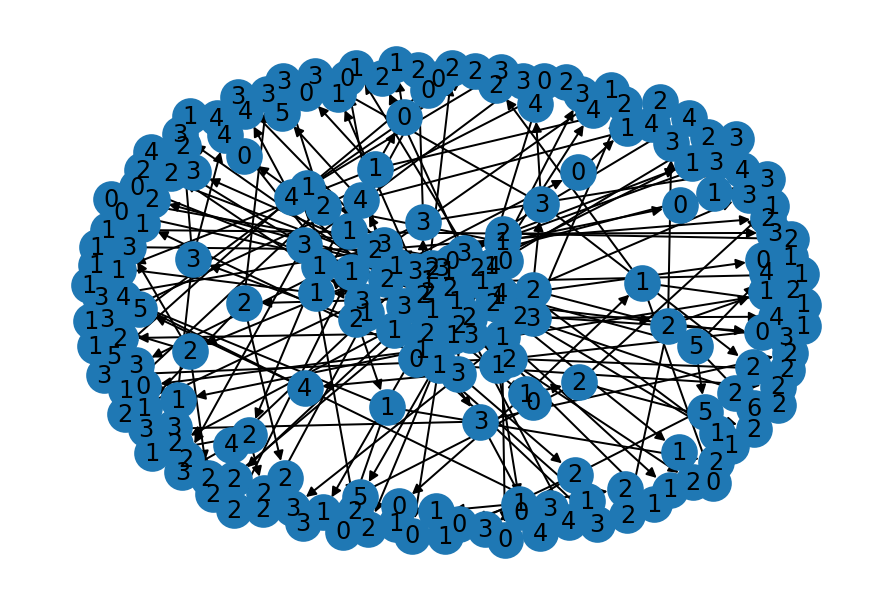

In [6]:
labels = nx.get_node_attributes(calcs, 'label') 
nx.draw(calcs,labels=labels, pos=nx.spring_layout(calcs))

In [19]:
nx.write_graphml(calcs, '/Users/juan/Temp/nx.graphml')

In [8]:
calcs = nx.Graph()
js = [1,1,1,1,1]
calcs.add_node(js[0])
# at each stage I iterate over all of the previous nodes
# for each of those nodes i create a +j node connected to them
# and for each of those +j nodes i create the |j1-j2| ... j1+j2 nodes
for stage in range(len(js)-1):
    print(stage)
    j2 = js[stage]
    chunks = []
    for ja in jas[stage]:
        print("adding ",j2,'+',ja,end='')
        for j1 in ja:
            totals = list(range(abs(j1-j2),j1+j2+1))
            for total in totals:
                calcs.add_node(total)
                calcs.add_edge([])
        print(' ->', chunks)
    jas[stage+1] = chunks

0
adding  1 + [1]

TypeError: add_edge() missing 1 required positional argument: 'v_of_edge'

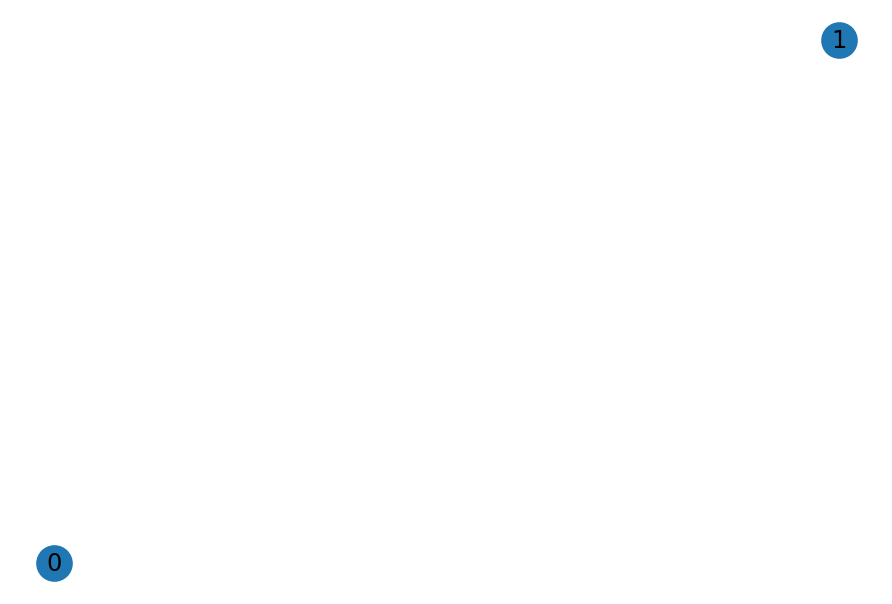

In [9]:
nx.draw(calcs,with_labels=True)

## Summary of the functions used in the section below

In [4]:
# def addtwo(j1,j2):
#     '''
#     This  function  takes  two  angular  momenta  j1, and j2 and returns a
#     dictionary  whose  keys  are  (J,mJ)  tuples, and whose values are the
#     linear  combinations  of  (mj1,mj2)  that  add up to the total angular
#     momentum ket.'''
#     Jkets = {}
#     for J in np.arange(np.abs(j1-j2),j1+j2+1,1):
#         J = int(J)
#         for mJ in range(-J,J+1,1):
#             kets = [cg.eva(j1,j2,J,m1,mJ-m1,mJ)*Ket((m1,mJ-m1)) for m1 in np.arange(-j1,j1+1,1)]
#             Jkets[(J,mJ)] = sum(kets)
#     return Jkets

In [5]:
# def block_form(matrix):
#     '''
#     This  function  takes  a matrix and rearranges its columns and rows so
#     that  it  is  in  block  diagonal form. It returns a tuple whose first
#     element  is  the  reorganized  matrix,  whose  second  element  is the
#     reordering  of  the rows, and whose third element is the reordering of
#     the columns.

#     As of now, it is a little ad-hoc and may fail horribly.

#     If this has a solution, there's many of them, this function would give
#     one of those.
    
#     Example
#     -------

#     >>> test_matrix = sp.Matrix(sp.BlockDiagMatrix(*[sp.randMatrix(s) for s in [3,1,2]]))
#     >>> size = test_matrix.rows
#     >>> num_shuffles = 20
#     >>> for _ in range(num_shuffles):
#     >>>     direction = randint(0,1)
#     >>>     col1 = randint(0,size-1)
#     >>>     col2 = randint(0,size-1)
#     >>>     permutation = list(range(size))
#     >>>     permutation[col1], permutation[col2] = col2, col1
#     >>>     test_matrix = test_matrix.permute(permutation,orientation=['cols','rows'][direction])
#     >>> display(test_matrix)
#     >>> display(block_form(test_matrix)[0])
    
    
#     '''
#     matrix = sp.Matrix(matrix)
#     connectome = []
#     # when this is called, sympy lets go of the elements that are zero
#     nonz = list(matrix.todok().keys()) 
#     for node in nonz:
#         connectome.extend([(node,k) for k in nonz if ((k[0] == node[0] or k[1] == node[1]))])
#     matrixdok = matrix.todok()
#     matrixGraph = nx.Graph()
#     matrixGraph.add_edges_from(connectome)
#     # reorganize columns and rows into block - diagonal form
#     components = list(nx.connected_components(matrixGraph))
#     components.sort(key=len)
#     size = matrix.rows
#     blocks = []
#     index_maps_h = {}
#     index_maps_v = {}
#     block_stride = 0
#     for component in components:
#         component = list(component)
#         indices_0 = sorted(list(set([x[0] for x in component])))
#         indices_1 = sorted(list(set([x[1] for x in component])))
#         block_size = len(indices_0)
#         mapping_v = {i0:k for k,i0 in zip(range(block_size),indices_0)}
#         mapping_h = {i1:k for k,i1 in zip(range(block_size),indices_1)}
#         index_maps_v.update({(k+block_stride):i0 for k,i0 in zip(range(block_size),indices_0)})
#         index_maps_h.update({(k+block_stride):i1 for k,i1 in zip(range(block_size),indices_1)})
#         block = {(mapping_v[c[0]], mapping_h[c[1]]):matrixdok[(c[0],c[1])] for c in component}
#         blocks.append(sp.SparseMatrix(block_size,block_size,block))
#         block_stride += block_size
#     # calculate the permutted bases
#     col_reordering = [index_maps_h[k] for k in range(size)]
#     row_reordering = [index_maps_v[k] for k in range(size)]
#     return sp.Matrix(sp.BlockDiagMatrix(*blocks)), blocks, col_reordering, row_reordering

In [5]:
# def LS_basis(l1,l2,s1,s2,standard_matrix=True):
#     '''
#     This  function  takes  two orbital angular momenta l1, l2 and two spin
#     angular  momenta s1, s2. It assumes that the two objects to which (l1,
#     s1) and (l2, s2) refer are inequivalent.

#     It returns a tuple of three elements where:

#         the   first  element  is  an  orthogonal  matrix  that  transforms
#         coordinate  vectors  written  in  the  coupled basis to coordinate
#         vectors  in  the  uncoupled  basis  (if the coordinate vectors are
#         written as column vectors),

#         the  second  element  a  list  of basis kets for the total angular
#         momentum space,

#         and  the third element equal to a list of basis vectors being used
#         for the uncoupled basis.
    
#     This  means, for example, that the first column of the returned matrix
#     has the coefficients that expresses the first ket in the coupled basis
#     in terms of the kets of the uncoupled basis.
    
#     In  all of the sp.Symbol used for labeling the basis kets, the quantum
#     numbers  used  are  ordered  as  (J,mJ) for the total angular momentum
#     basis, and as (ml1,ml2,ms1,ms2) for the uncoupled basis.
    
#     If  standard_matrix  =  False,  then  the  returned  matrix  has block
#     diagonal  form  and  the  basis vectors given have been reorganized to
#     make this happen.
    
#     -------
#     Example
    
#     LS_basis(0,0,1/2,1/2) returns these three elements
    
#     (
#     sp.Matrix([[-sqrt(2)/2, 0, sqrt(2)/2, 0],
#               [         0, 0,         0, 1],
#               [         0, 1,         0, 0], 
#               [ sqrt(2)/2, 0, sqrt(2)/2, 0]]),
            
#     [|00-1/21/2>, |001/21/2>, |00-1/2-1/2>, |001/2-1/2>],
    
#     [|00>, |1-1>, |10>, |11>]
#     )
    
#     '''
#     for arg in [s1,s2,l1,l2]:
#         assert round(arg*2) == arg*2, "All arguments must be integer or half-integer."
#     s1 = sp.S(round(s1*2))/2
#     s2 = sp.S(round(s2*2))/2
#     l1 = sp.S(round(l1*2))/2
#     l2 = sp.S(round(l2*2))/2
#     # Add l1, and l2 to obtain L
#     Skets = addtwo(s1,s2)
#     # Add s1, and s2 to obtain S
#     Lkets = addtwo(l1,l2)
#     # we first separate out the different values for S, and for L
#     Skets_partitioned = {s:{k:v for k,v in Skets.items() if k[0] == s} for s in list(set(x[0] for x in Skets.keys()))}
#     Lkets_partitioned = {s:{k:v for k,v in Lkets.items() if k[0] == s} for s in list(set(x[0] for x in Lkets.keys()))}
#     # next one adds up angular momenta using the keys of the sectors in S and L
#     LS_couples = {}
#     for j1 in Lkets_partitioned.keys():
#         # here i will now only keep the m_L value
#         clearj1 = {k[1]:v for k,v in Lkets_partitioned[j1].items()}
#         for j2 in Skets_partitioned.keys():
#             # here i will now only keep the m_S value
#             clearj2 = {k[1]:v for k,v in Skets_partitioned[j2].items()}
#             j1j2 = addtwo(j1,j2)
#             # using  the  expressions  for (j1,mj1,j2,mj2) one makes a dictionary to
#             # replace  what  the  kets  in j1j2 evaluate to in terms of the original
#             # bases  its  a  matter  of  concatenating  their  quantum  numbers  and
#             # multiplying their coefficients
#             reps = {Ket((q1,q2)): (KetTensorProduct(v1,v2)) for q1,v1 in clearj1.items() for q2,v2 in clearj2.items()}
#             # using this dictionary, one then replaces the kets in j1j2
#             totals = {k: v.subs(reps) for k,v in j1j2.items()}
#             # save results
#             LS_couples[(j1,j2)] = totals
#     # parse the coordinate transform matrix
#     # here i'm putting things in rows, that's
#     # why at the end I take the transpose of the matrix
#     rows = []
#     totalJ_labels = []
#     uncoupled_basis = set()
#     for kpair in LS_couples:
#         for k, v in LS_couples[kpair].items():
#             uncoupled_basis.update(v.free_symbols)
#     uncoupled_basis = list(uncoupled_basis)
#     for kpair in LS_couples:
#         for k, v in LS_couples[kpair].items():
#             vdict = v.as_coefficients_dict()
#             v = sp.expand(v)
#             row = [v.coeff(tb) for tb in uncoupled_basis]
#             if sum(np.abs(np.array(row))) == 0:
#                 print(v)
#                 raise Exception("Wups.")
#             totalJ_labels.append(k)
#             rows.append(row)
#     CGmatrix = sp.Matrix(rows)
#     if standard_matrix:
#         total_J_basis =  [Ket(*r) for r in totalJ_labels]
#         return CGmatrix.T, total_J_basis, uncoupled_basis
#     else:
#         # This  basically  ends  up  making groups that have the same mJ for the
#         # coupled  basis, with groups that have the ml1, ml2, ms1, ms2 adding up
#         # to the corresponding mJ
#         connectome = []
#         nonz = list(CGmatrix.todok().keys())
#         for node in nonz:
#             connectome.extend([(node,k) for k in nonz if ((k[0] == node[0] or k[1] == node[1]))])
#         CGdok = CGmatrix.todok()
#         CGgraph = nx.Graph()
#         CGgraph.add_edges_from(connectome)

#         # reorganize columns and rows into block - diagonal form
#         components = list(nx.connected_components(CGgraph))
#         components.sort(key=len)
#         size = CGmatrix.rows
#         blocks = []
#         index_maps_h = {}
#         index_maps_v = {}
#         block_stride = 0
#         for component in components:
#             component = list(component)
#             indices_0 = sorted(list(set([x[0] for x in component])))
#             indices_1 = sorted(list(set([x[1] for x in component])))
#             assert len(indices_0) == len(indices_1)
#             block_size = len(indices_0)
#             mapping_v = {i0:k for k,i0 in zip(range(block_size),indices_0)}
#             mapping_h = {i1:k for k,i1 in zip(range(block_size),indices_1)}
#             index_maps_v.update({(k+block_stride):i0 for k,i0 in zip(range(block_size),indices_0)})
#             index_maps_h.update({(k+block_stride):i1 for k,i1 in zip(range(block_size),indices_1)})
#             block = {(mapping_v[c[0]], mapping_h[c[1]]):CGdok[(c[0],c[1])] for c in component}
#             blocks.append(sp.SparseMatrix(block_size,block_size,block))
#             block_stride += block_size
#         # calculate the permutted bases
#         total_J_basis = [Ket(*totalJ_labels[index_maps_h[k]]) for k in range(size)]
#         uncoupled_basis = [uncoupled_basis[index_maps_v[k]] for k in range(size)]
#         # assemble the block diagonal matrix from the individual blocks
#         CG_blocks = sp.Matrix(sp.BlockDiagMatrix(*blocks))
#         return CG_blocks.T, total_J_basis, uncoupled_basis

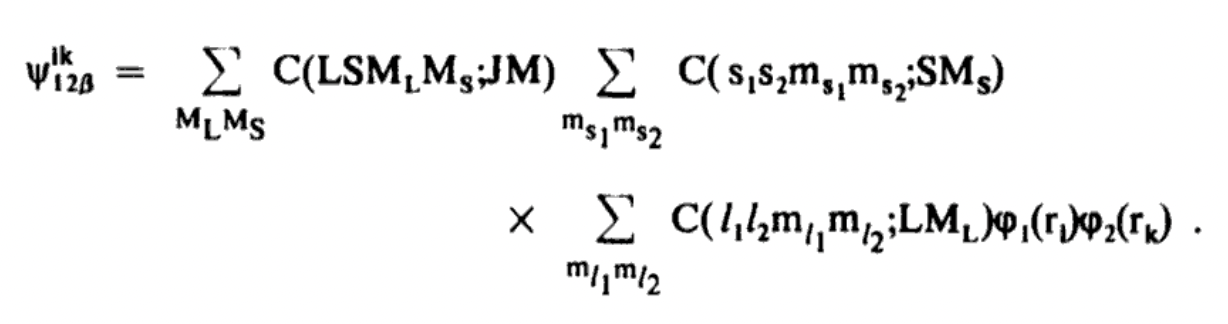

The challenge of implementing this sum is that the summation limits over M_L and M_S depend on the 

In [4]:
# def ϕ(qnums, tag):
#     qnums['tag'] = tag
#     return Qet(qnums)

In [8]:
# def LS_basis_equiv_electrons(l):
#     '''
#     Returns the asymetric LS coupled basis for a pair of equivalent
#     electrons with a given l.
    
#     Parameters
#     ----------
#     l (int): shared orbital quantum number between two electrons
    
#     Returns
#     -------
    
    
    
#     '''
#     s1 = sp.S(1)/2
#     s2 = s1
#     l1 = sp.S(round(l*2))/2
#     l2 = l1
#     ml1s = list(range(-l1,l1+1))
#     ml2s = list(range(-l2,l2+1))
#     ms1s = list(np.arange(-s1,s1+1))
#     ms2s = list(np.arange(-s2,s2+1))
#     summands = {}
#     for L in list(np.arange(np.abs(l2-l1),l1+l2+1)):
#         mLs = np.arange(-L,L+1)
#         for S in list(np.arange(np.abs(s2-s1),s1+s2+1)):
#             mSs = np.arange(-S,S+1)
#             Js = np.arange(np.abs(L-S),L+S+1)
#             for ml1, ml2, ms1, ms2, mL, mS, J in product(ml1s, ml2s, ms1s, ms2s, mLs, mSs, Js):
#                 mJs = np.arange(-J,J+1,1)
#                 for mJ in mJs:
#                     c1 = cg.eva(L,S,J,mL,mS,mJ)
#                     if c1 == 0:
#                         continue
#                     c2 = cg.eva(s1,s2,S,ms1,ms2,mS)
#                     if c2 == 0:
#                         continue
#                     c3 = cg.eva(l1,l2,L,ml1,ml2,mL)
#                     if c3 == 0:
#                         continue
#                     c = c1*c2*c3
#                     ϕ1 = Qet({(ml1, ms1):1})
#                     ϕ2 = Qet({(ml2, ms2):1})
#                     ϕ = ϕ1*ϕ2
#                     if c!= 0:
#                         if (L,S,J,mJ) not in summands.keys():
#                             summands[(L,S,J,mJ)] = []
#                         summands[(L,S,J,mJ)].append(c*ϕ)
#     totals = OrderedDict()
#     basic_basis = list(product(ml1s,ms1s,ml2s,ms2s))
#     for k,v in summands.items():
#         tee = sum(v,Qet({}))
#         totals[k] = (tee,tee.vec_in_basis(basic_basis))
#     def antisymmetrize(qet):
#         qet_len = len(list(qet.dict.keys())[0])
#         assert qet_len % 2 == 0
#         split = qet_len//2
#         biz_qet = Qet({(*k[split:],*k[:split]): v for k, v in qet.dict.items()})
#         return sp.S(1)/sp.S(2)*(qet + (-1)*biz_qet)
#     asym = {}
#     for k,v in totals.items():
#         asym_qet = antisymmetrize(v[0])
#         if len(asym_qet.dict) != 0:
#             asym[k] = asym_qet
#     return asym

In [9]:
# from collections import namedtuple
# Qnums = namedtuple('Q', ['ml1','ms1','ml2','ms2'])
# def LS_basis_equiv_electrons_named(l):
#     '''
#     Returns the asymmetric LS coupled basis for a pair of equivalent
#     electrons with a shared l.
    
#     Parameters
#     ----------
#     l (int): orbital quantum number
    
#     Returns
#     -------
    
    
#     '''
#     s1, l1 = sp.S(1)/2, sp.S(round(l*2))/2
#     s2, l2 = s1, l1
#     ml1s, ms1s = list(range(-l1,l1+1)), list(np.arange(-s1,s1+1))
#     ml2s, ms2s = ml1s, ms1s
#     summands = {}
#     Ls = list(np.arange(np.abs(l2-l1),l1+l2+1))
#     Ss = list(np.arange(np.abs(s2-s1),s1+s2+1))
#     for L in Ls:
#         mLs = np.arange(-L,L+1)
#         for S in Ss:
#             mSs = np.arange(-S,S+1)
#             Js = np.arange(np.abs(L-S),L+S+1)
#             for ml1, ml2, ms1, ms2, mL, mS, J in product(ml1s, ml2s, ms1s, ms2s, mLs, mSs, Js):
#                 mJs = np.arange(-J,J+1,1)
#                 for mJ in mJs:
#                     c1 = cg.eva(L,S,J,mL,mS,mJ)
#                     if c1 == 0:
#                         continue
#                     c2 = cg.eva(s1,s2,S,ms1,ms2,mS)
#                     if c2 == 0:
#                         continue
#                     c3 = cg.eva(l1,l2,L,ml1,ml2,mL)
#                     if c3 == 0:
#                         continue
#                     c = c1*c2*c3
#                     if c!= 0:
#                         if (L,S,J,mJ) not in summands.keys():
#                             summands[(L,S,J,mJ)] = []
#                         ϕ = Qet({Qnums(ml1, ms1, ml2, ms2):c})
#                         summands[(L,S,J,mJ)].append(ϕ)
#     totals = OrderedDict()
#     basic_basis = list(product(ml1s,ms1s,ml2s,ms2s))
#     for k,v in summands.items():
#         tee = sum(v,Qet({}))
#         totals[k] = (tee,tee.vec_in_basis(basic_basis))
#     def antisymmetrize(qet):
#         qet_len = len(list(qet.dict.keys())[0])
#         assert qet_len % 2 == 0
#         split = qet_len//2
#         biz_qet = Qet({(*k[split:],*k[:split]): v for k, v in qet.dict.items()})
#         return sp.S(1)/sp.S(2)*(qet + (-1)*biz_qet)
#     asym = {}
#     for k,v in totals.items():
#         asym_qet = antisymmetrize(v[0])
#         if len(asym_qet.dict) != 0:
#             asym[k] = asym_qet
#     return asym

In [10]:
# def Lz_total(qnums,coeff,l1,l2):
#     J1 = coeff*Qet({qnums: qnums[0]})
#     J2 = coeff*Qet({qnums: qnums[2]})
#     return J1+J2
# def Lplus_total(qnums,coeff,l1,l2):
#     ml1, ms1, ml2, ms2 = qnums.ml1, qnums.ms1, qnums.ml2, qnums.ms2
#     J1 = coeff * Qet({Qnums(ml1+1,ms1,ml2,ms2): sp.sqrt(l1*(l1+1)-ml1*(ml1+1)),
#                      Qnums(ml1,ms1,ml2+1,ms2): sp.sqrt(l2*(l2+1)-ml2*(ml2+1))})
#     return J1
# def Lminus_total(qnums,coeff,l1,l2):
#     ml1, ms1, ml2, ms2 = qnums
#     J1 = coeff * Qet({Qnums(ml1-1,ms1,ml2,ms2): sp.sqrt(l1*(l1+1)-ml1*(ml1-1)),
#                      Qnums(ml1,ms1,ml2-1,ms2): sp.sqrt(l2*(l2+1)-ml2*(ml2-1))})
#     return J1

# def Lx_total(qnums,coeff,l1,l2):
#     return sp.S(1)/2*(Lplus_total(qnums,coeff,l1,l2) + Lminus_total(qnums,coeff,l1,l2)) 
# def Ly_total(qnums,coeff,l1,l2):
#     return -sp.I*sp.S(1)/2*(Lplus_total(qnums,coeff,l1,l2) + (-1)*Lminus_total(qnums,coeff,l1,l2)) 
# def L_total_squared(qet,l):
#     Lx1 = sum([Lx_total(k,v,l,l) for k,v in qet.dict.items()],Qet())
#     Lx2 = sum([Lx_total(k,v,l,l) for k,v in Lx1.dict.items()],Qet())
#     Ly1 = sum([Ly_total(k,v,l,l) for k,v in qet.dict.items()],Qet())
#     Ly2 = sum([Ly_total(k,v,l,l) for k,v in Ly1.dict.items()],Qet())
#     Lz1 = sum([Lz_total(k,v,l,l) for k,v in qet.dict.items()],Qet())
#     Lz2 = sum([Lz_total(k,v,l,l) for k,v in Lz1.dict.items()],Qet())
#     return Lx2+Ly2+Lz2


# def Sz_total(qnums,coeff,l1,l2):
#     J1 = coeff*Qet({qnums: qnums[1]})
#     J2 = coeff*Qet({qnums: qnums[3]})
#     return J1+J2
# def Splus_total(qnums,coeff,l1,l2):
#     ml1, ms1, ml2, ms2 = qnums.ml1, qnums.ms1, qnums.ml2, qnums.ms2
#     J1 = coeff * Qet({Qnums(ml1,ms1+1,ml2,ms2): sp.sqrt(l1*(l1+1)-ms1*(ms1+1)),
#                      Qnums(ml1,ms1,ml2,ms2+1): sp.sqrt(l2*(l2+1)-ms2*(ms2+1))})
#     return J1
# def Sminus_total(qnums,coeff,l1,l2):
#     ml1, ms1, ml2, ms2 = qnums
#     J1 = coeff * Qet({Qnums(ml1,ms1-1,ml2,ms2): sp.sqrt(l1*(l1+1)-ms1*(ms1-1)),
#                      Qnums(ml1,ms1,ml2,ms2-1): sp.sqrt(l1*(l1+1)-ms2*(ms2-1))})
#     return J1
# def Sx_total(qnums,coeff,l1,l2):
#     return sp.S(1)/2*(Splus_total(qnums,coeff,l1,l2) + Sminus_total(qnums,coeff,l1,l2)) 
# def Sy_total(qnums,coeff,l1,l2):
#     return -sp.I*sp.S(1)/2*(Splus_total(qnums,coeff,l1,l2) + (-1)*Sminus_total(qnums,coeff,l1,l2)) 
# def S_total_squared(qet,l):
#     Sx1 = sum([Sx_total(k,v,l,l) for k,v in qet.dict.items()],Qet())
#     Sx2 = sum([Sx_total(k,v,l,l) for k,v in Sx1.dict.items()],Qet())
#     Sy1 = sum([Sy_total(k,v,l,l) for k,v in qet.dict.items()],Qet())
#     Sy2 = sum([Sy_total(k,v,l,l) for k,v in Sy1.dict.items()],Qet())
#     Sz1 = sum([Sz_total(k,v,l,l) for k,v in qet.dict.items()],Qet())
#     Sz2 = sum([Sz_total(k,v,l,l) for k,v in Sz1.dict.items()],Qet())
#     return Sx2+Sy2+Sz2

# def Jz_total(qnums,coeff,l1,l2,s1,s2):
#     return Lz_total(qnums,coeff,l1,l2) + Sz_total(qnums,coeff,s1,s2)
# def Jplus_total(qnums,coeff,l1,l2,s1,s2):
#     return Lplus_total(qnums,coeff,l1,l2) + Splus_total(qnums,coeff,s1,s2)
# def Jminus_total(qnums,coeff,l1,l2,s1,s2):
#     return Lminus_total(qnums,coeff,l1,l2) + Sminus_total(qnums,coeff,s1,s2)
# def Jx_total(qnums,coeff,l1,l2,s1,s2):
#     return sp.S(1)/2*(Jplus_total(qnums,coeff,l1,l2,s1,s2) + Jminus_total(qnums,coeff,l1,l2,s1,s2)) 
# def Jy_total(qnums,coeff,l1,l2,s1,s2):
#     return -sp.I*sp.S(1)/2*(Jplus_total(qnums,coeff,l1,l2,s1,s2) + (-1)*Jminus_total(qnums,coeff,l1,l2,s1,s2)) 
# def J_total_squared(qet,l,s):
#     Sx1 = sum([Jx_total(k,v,l,l,s,s) for k,v in qet.dict.items()],Qet())
#     Sx2 = sum([Jx_total(k,v,l,l,s,s) for k,v in Sx1.dict.items()],Qet())
#     Sy1 = sum([Jy_total(k,v,l,l,s,s) for k,v in qet.dict.items()],Qet())
#     Sy2 = sum([Jy_total(k,v,l,l,s,s) for k,v in Sy1.dict.items()],Qet())
#     Sz1 = sum([Jz_total(k,v,l,l,s,s) for k,v in qet.dict.items()],Qet())
#     Sz2 = sum([Jz_total(k,v,l,l,s,s) for k,v in Sz1.dict.items()],Qet())
#     return Sx2+Sy2+Sz2

In [11]:
l = 1
LS1 = LS_basis_equiv_electrons_named(l)

In [12]:
for k, v in LS1.items():
    print('L=%d, S=%d, J=%d, MJ=%d' % k)
    # L check
    lhs = L_total_squared(v,l).dict 
    rhs =  (k[0]*(k[0]+1)*v).dict
    print(lhs == rhs, end=',')
    # S check
    lhs = S_total_squared(v,sp.S(1)/2).dict
    rhs = (k[1]*(k[1]+1)*v).dict
    print(lhs == rhs, end=',')
    # J check
    lhs = J_total_squared(v,l,sp.S(1)/2).dict
    rhs = (k[2]*(k[2]+1)*v).dict
    print(lhs == rhs, end=',')
    # MJ check
    lhs = sum([Jz_total(k0,v0,l,l,sp.S(1)/2,sp.S(1)/2) for k0,v0 in v.dict.items()],Qet()).dict
    rhs = (k[3]*v).dict
    print(lhs == rhs, end=',')
    # antisym check
    lhs = Qet({(k0[2],k0[3],k0[0],k0[1]):v0 for k0,v0 in v.dict.items()}).dict
    rhs = ((-1)*v).dict
    print(lhs == rhs)

L=0, S=0, J=0, MJ=0
True,True,True,True,True
L=1, S=1, J=2, MJ=-2
True,True,True,True,True
L=1, S=1, J=1, MJ=-1
True,True,True,True,True
L=1, S=1, J=2, MJ=-1
True,True,True,True,True
L=1, S=1, J=0, MJ=0
True,True,True,True,True
L=1, S=1, J=1, MJ=0
True,True,True,True,True
L=1, S=1, J=2, MJ=0
True,True,True,True,True
L=1, S=1, J=1, MJ=1
True,True,True,True,True
L=1, S=1, J=2, MJ=1
True,True,True,True,True
L=1, S=1, J=2, MJ=2
True,True,True,True,True
L=2, S=0, J=2, MJ=-2
True,True,True,True,True
L=2, S=0, J=2, MJ=-1
True,True,True,True,True
L=2, S=0, J=2, MJ=0
True,True,True,True,True
L=2, S=0, J=2, MJ=1
True,True,True,True,True
L=2, S=0, J=2, MJ=2
True,True,True,True,True


In [524]:
def Lz_total(qnums,coeff,l1,l2):
    J1 = coeff*Qet({qnums: qnums[0]})
    J2 = coeff*Qet({qnums: qnums[2]})
    return J1+J2
def Lplus_total(qnums,coeff,l1,l2):
    ml1, ms1, ml2, ms2 = qnums
    J1 = coeff * Qet({(ml1+1,ms1,ml2,ms2): sp.sqrt(l1*(l1+1)-ml1*(ml1+1)),
                     (ml1,ms1,ml2+1,ms2): sp.sqrt(l1*(l1+1)-ml2*(ml2+1))})
    return J1
def Lminus_total(qnums,coeff,l1,l2):
    ml1, ms1, ml2, ms2 = qnums
    J1 = coeff * Qet({(ml1-1,ms1,ml2,ms2): sp.sqrt(l1*(l1+1)-ml1*(ml1-1)),
                     (ml1,ms1,ml2-1,ms2): sp.sqrt(l1*(l1+1)-ml2*(ml2-1))})
    return J1
def Lx_total(qnums,coeff,l1,l2):
    return sp.S(1)/2*(Lplus_total(qnums,coeff,l1,l2) + Lminus_total(qnums,coeff,l1,l2)) 
def Ly_total(qnums,coeff,l1,l2):
    return -sp.I*sp.S(1)/2*(Lplus_total(qnums,coeff,l1,l2) + (-1)*Lminus_total(qnums,coeff,l1,l2)) 
def L_total_squared(qet):
    Lx1 = sum([Lx_total(k,v,1,1) for k,v in qet.dict.items()],Qet())
    Lx2 = sum([Lx_total(k,v,1,1) for k,v in Lx1.dict.items()],Qet())
    Ly1 = sum([Ly_total(k,v,1,1) for k,v in qet.dict.items()],Qet())
    Ly2 = sum([Ly_total(k,v,1,1) for k,v in Ly1.dict.items()],Qet())
    Lz1 = sum([Lz_total(k,v,1,1) for k,v in qet.dict.items()],Qet())
    Lz2 = sum([Lz_total(k,v,1,1) for k,v in Lz1.dict.items()],Qet())
    return Lx2+Ly2+Lz2

In [500]:
asym = LS_basis_equiv_electrons(1)

In [492]:
Lx1 = sum([Lx_total(k,v,1,1) for k,v in asym[(1,1,0,0)].dict.items()],Qet())
Lx2 = sum([Lx_total(k,v,1,1) for k,v in Lx1.dict.items()],Qet())
Ly1 = sum([Ly_total(k,v,1,1) for k,v in asym[(1,1,0,0)].dict.items()],Qet())
Ly2 = sum([Ly_total(k,v,1,1) for k,v in Ly1.dict.items()],Qet())
Lz1 = sum([Lz_total(k,v,1,1) for k,v in asym[(1,1,0,0)].dict.items()],Qet())
Lz2 = sum([Lz_total(k,v,1,1) for k,v in Lz1.dict.items()],Qet())
Lx2+Ly2+Lz2

Qet({(-1, 1/2, 0, 1/2): -sqrt(6)/3, (-1, -1/2, 1, 1/2): sqrt(3)/3, (-1, 1/2, 1, -1/2): sqrt(3)/3, (0, 1/2, -1, 1/2): sqrt(6)/3, (0, -1/2, 1, -1/2): -sqrt(6)/3, (1, -1/2, -1, 1/2): -sqrt(3)/3, (1, 1/2, -1, -1/2): -sqrt(3)/3, (1, -1/2, 0, -1/2): sqrt(6)/3})

In [493]:
asym[(1,1,0,0)]

Qet({(-1, 1/2, 0, 1/2): -sqrt(6)/6, (-1, -1/2, 1, 1/2): sqrt(3)/6, (-1, 1/2, 1, -1/2): sqrt(3)/6, (0, 1/2, -1, 1/2): sqrt(6)/6, (0, -1/2, 1, -1/2): -sqrt(6)/6, (1, -1/2, -1, 1/2): -sqrt(3)/6, (1, 1/2, -1, -1/2): -sqrt(3)/6, (1, -1/2, 0, -1/2): sqrt(6)/6})

In [433]:
def J_plus(j):
    J_fun = {}
    for m in range(-j, j+1):
        J_fun[m] = (m+1,sp.sqrt(j*(j+1) - m*(m+1)))
    return J_fun
def J_minus(j):
    J_fun = {}
    for m in range(-j, j+1):
        coeff_2 = j*(j+1) - m*(m-1)
        if coeff_2 > 0:
            J_fun[m] = (m-1,sp.sqrt(j*(j+1) - m*(m-1)))
    return J_fun

In [434]:
J_p1 = J_plus(1)

In [435]:
J_p1

{-1: (0, sqrt(2)), 0: (1, sqrt(2)), 1: (2, 0)}

In [419]:
abasis = LS_basis_equiv_electrons(1)

In [437]:
abasis[(0,0,0,0)].apply(lambda x,y: ((J_p1[x[0]][0],x[1],J_p1[x[2]][0],x[3]),y*J_p1[x[0]][1]*J_p1[x[2]][1]))

Qet({(1, -1/2, 1, 1/2): sqrt(6)/3, (1, 1/2, 1, -1/2): -sqrt(6)/3})

In [461]:
s1 = sp.S(1)/2
s2 = sp.S(1)/2
l1 = sp.S(1)
l2 = sp.S(1)
n1 = sp.S(1)
n2 = sp.S(1)
ml1s = list(range(-l1,l1+1))
ml2s = list(range(-l2,l2+1))
ms1s = list(np.arange(-s1,s1+1))
ms2s = list(np.arange(-s2,s2+1))
summands = {}
for L in list(np.arange(np.abs(l2-l1),l1+l2+1)):
    mLs = np.arange(-L,L+1)
    for S in list(np.arange(np.abs(s2-s1),s1+s2+1)):
        mSs = np.arange(-S,S+1)
        Js = np.arange(np.abs(L-S),L+S+1)
        for ml1, ml2, ms1, ms2, mL, mS, J in product(ml1s, ml2s, ms1s, ms2s, mLs, mSs, Js):
            mJs = np.arange(-J,J+1,1)
            for mJ in mJs:
                c1 = cg(L,S,J,mL,mS,mJ)
                if c1 == 0:
                    continue
                c2 = cg(s1,s2,S,ms1,ms2,mS)
                if c2 == 0:
                    continue
                c3 = cg(l1,l2,L,ml1,ml2,mL)
                if c3 == 0:
                    continue
                c = c1*c2*c3
                ϕ1 = Qet({(n1, l1, ml1, ms1):1})
                ϕ2 = Qet({(n2, l2, ml2, ms2):1})
                ϕ = ϕ1*ϕ2
                if c!= 0:
                    if (L,S,J,mJ) not in summands.keys():
                        summands[(L,S,J,mJ)] = []
                    summands[(L,S,J,mJ)].append(c*ϕ)
totals = OrderedDict()
basic_basis = list(product([n1], [l1], ml1s, ms1s,[n2], [l2], ml2s, ms2s))
basic_basis_asym = list(product([n1], [l1], ml1s, ms1s,[n2], [l2], ml2s, ms2s))
for k,v in summands.items():
    tee = sum(v,Qet({}))
    totals[k] = (tee,tee.vec_in_basis(basic_basis))
def antisymmetrize(qet):
    qet_len = len(list(qet.dict.keys())[0])
    assert qet_len % 2 == 0
    split = qet_len//2
    biz_qet = Qet({(*k[split:],*k[:split]): v for k, v in qet.dict.items()})
    return sp.S(1)/sp.S(2)*(qet + (-1)*biz_qet)
asym = {}
for k,v in totals.items():
    asym_qet = antisymmetrize(v[0])
    if len(asym_qet.dict) != 0:
        asym[k] = asym_qet
asym

{(0,
  0,
  0,
  0): Qet({(1, 1, -1, -1/2, 1, 1, 1, 1/2): -sqrt(6)/6, (1, 1, -1, 1/2, 1, 1, 1, -1/2): sqrt(6)/6, (1, 1, 0, -1/2, 1, 1, 0, 1/2): sqrt(6)/6, (1, 1, 0, 1/2, 1, 1, 0, -1/2): -sqrt(6)/6, (1, 1, 1, -1/2, 1, 1, -1, 1/2): -sqrt(6)/6, (1, 1, 1, 1/2, 1, 1, -1, -1/2): sqrt(6)/6}),
 (1,
  1,
  2,
  -2): Qet({(1, 1, -1, -1/2, 1, 1, 0, -1/2): -sqrt(2)/2, (1, 1, 0, -1/2, 1, 1, -1, -1/2): sqrt(2)/2}),
 (1,
  1,
  1,
  -1): Qet({(1, 1, -1, -1/2, 1, 1, 0, 1/2): sqrt(2)/4, (1, 1, -1, 1/2, 1, 1, 0, -1/2): sqrt(2)/4, (1, 1, -1, -1/2, 1, 1, 1, -1/2): -1/2, (1, 1, 0, -1/2, 1, 1, -1, 1/2): -sqrt(2)/4, (1, 1, 0, 1/2, 1, 1, -1, -1/2): -sqrt(2)/4, (1, 1, 1, -1/2, 1, 1, -1, -1/2): 1/2}),
 (1,
  1,
  2,
  -1): Qet({(1, 1, -1, -1/2, 1, 1, 0, 1/2): -sqrt(2)/4, (1, 1, -1, 1/2, 1, 1, 0, -1/2): -sqrt(2)/4, (1, 1, -1, -1/2, 1, 1, 1, -1/2): -1/2, (1, 1, 0, -1/2, 1, 1, -1, 1/2): sqrt(2)/4, (1, 1, 0, 1/2, 1, 1, -1, -1/2): sqrt(2)/4, (1, 1, 1, -1/2, 1, 1, -1, -1/2): 1/2}),
 (1,
  1,
  0,
  0): Qet({(1, 1, -1

In [454]:
asym[(0,0,0,0)]

Qet({(-1, -1/2, 1, 1/2): -sqrt(6)/6, (-1, 1/2, 1, -1/2): sqrt(6)/6, (0, -1/2, 0, 1/2): sqrt(6)/6, (0, 1/2, 0, -1/2): -sqrt(6)/6, (1, -1/2, -1, 1/2): -sqrt(6)/6, (1, 1/2, -1, -1/2): sqrt(6)/6})

In [459]:
asym[(1,1,0,0)]

Qet({(-1, 1/2, 0, 1/2): -sqrt(6)/6, (-1, -1/2, 1, 1/2): sqrt(3)/6, (-1, 1/2, 1, -1/2): sqrt(3)/6, (0, 1/2, -1, 1/2): sqrt(6)/6, (0, -1/2, 1, -1/2): -sqrt(6)/6, (1, -1/2, -1, 1/2): -sqrt(3)/6, (1, 1/2, -1, -1/2): -sqrt(3)/6, (1, -1/2, 0, -1/2): sqrt(6)/6})

In [220]:
bform = block_form(hum)

In [30]:
# j1 = 1
# j2 = 1
# matrices = []
# for J in range(abs(j1-j2),j1+j2+1):
#     for mJ in range(-J,J+1):
#         amatrix = [[cg(j1,j2,J,m1,m2,mJ) for m1 in range(-j1,j1+1)] for m2 in range(-j2,j2+1)]
#         amatrix = sp.Matrix(amatrix)
#         matrices.append(amatrix)
# # matrices = [[[[cg(j1,j2,J,m1,m2,mJ) for m1 in range(-j1,j1+1)] for m2 in range(-j2,j2+1)] for mJ in range(-J,J+1)] for J in range(abs(j1-j2),j1+j2+1)]

In [31]:
# J123ss = [tuple(range(abs(j3-J12),j3+J12+1)) for J12 in range(abs(j1-j2),j1+j2+1)]
# J123ss

In [32]:
# j1 = 1
# j2 = 1
# j3 = 1
# CG = (lambda : 0)
# J12basis = [(J,mJ) for J in range(abs(j1-j2),j1+j2+1) for mJ in range(-J,J+1)]
# j12basis = [(m1,m2) for m1 in range(-j1,j1+1) for m2 in range(-j2,j2+1)]
# for J in range(abs(j1-j2),j1+j2+1):
#     for mJ in range(-J,J+1):
#         for m1,m2 in product(range(-j1,j1+1),range(-j2,j2+1)):
#             if m1+m2 == mJ:
#                 CG[((J,mJ),(m1,m2))] = cg(j1,j2,J,m1,m2,mJ)
# J123ss = [tuple(np.arange(abs(j3-J12),j3+J12+1)) for J12 in range(abs(j1-j2),j1+j2+1)]
# CG123 = defaultdict(lambda : 0)
# for m3 in np.arange(-j3,j3+1):
#     for m2 in range(-j2,j2+1):
#         for m1 in range(-j1,j1+1):
#             for J123s in J123ss:
#                 for J123 in J123s:
#                     for M123 in np.arange(-J123,J123+1):
#                         for J12 in set(map(lambda x: x[0],J12basis)):
#                             summands = []
#                             for M12 in set(map(lambda x: x[1],J12basis)):
#                                             summand = cg(J12,j3,J123,M12,m3,M123)*CG[((J12,M12),(m1,m2))]
#                                             summands.append(summand)
#                             total = sum(summands)
#                             if total != 0:
#                                 CG123[((J123,M123),(m1,m2,m3))] = total
# #     for j123 in J123s:
# #         J123basis = [(J,mJ) for J in range(abs(j3-j2),j1+j2+1) for mJ in range(-J,J+1)]
# #         j123basis = [(m1,m2) for m1 in range(-j1,j1+1) for m2 in range(-j2,j2+1)]

In [34]:
# len(list(map(lambda x: x[0][0],CG123)))
# len(set(map(lambda x: x[0][0],CG123)))

In [35]:
CG = defaultdict()
j1 = 1
j2 = 1
j3 = 1

[cg(J12,j3,J123,M12,m3,m123) * cg(j1,j2,J12,m1,m2,M12) for J12 in range(abs(j1-j2),j1+j2+1)
    for J123 in range(abs(j3-J12),j3+J12+1)
    for M12 in range(-J12,J12+1)
    for m123 in range(-J123,J123+1)]

In [1228]:
j1 = 1
j2 = 1
j3 = 1
m1 = 1
m2 = 1
m3 = 1
[cg(J12,j3,J123,M12,m3,m123) * cg(j1,j2,J12,m1,m2,M12) for J12 in range(abs(j1-j2),j1+j2+1)
    for J123 in range(abs(j3-J12),j3+J12+1)
    for M12 in range(-J12,J12+1)
    for m123 in range(-J123,J123+1)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [20]:
for matrix in matrices:
    display(sp.Matrix(matrix))

Matrix([
[        0,          0, sqrt(3)/3],
[        0, -sqrt(3)/3,         0],
[sqrt(3)/3,          0,         0]])

Matrix([
[         0, sqrt(2)/2, 0],
[-sqrt(2)/2,         0, 0],
[         0,         0, 0]])

Matrix([
[         0, 0, sqrt(2)/2],
[         0, 0,         0],
[-sqrt(2)/2, 0,         0]])

Matrix([
[0,          0,         0],
[0,          0, sqrt(2)/2],
[0, -sqrt(2)/2,         0]])

Matrix([
[1, 0, 0],
[0, 0, 0],
[0, 0, 0]])

Matrix([
[        0, sqrt(2)/2, 0],
[sqrt(2)/2,         0, 0],
[        0,         0, 0]])

Matrix([
[        0,         0, sqrt(6)/6],
[        0, sqrt(6)/3,         0],
[sqrt(6)/6,         0,         0]])

Matrix([
[0,         0,         0],
[0,         0, sqrt(2)/2],
[0, sqrt(2)/2,         0]])

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 1]])

In [41]:
test_matrix = sp.Matrix(sp.BlockDiagMatrix(*[sp.randMatrix(s) for s in [3,1,2]]))
size = test_matrix.rows
num_shuffles = 20
for _ in range(num_shuffles):
    direction = randint(0,1)
    col1 = randint(0,size-1)
    col2 = randint(0,size-1)
    permutation = list(range(size))
    permutation[col1], permutation[col2] = col2, col1
    test_matrix = test_matrix.permute(permutation,orientation=['cols','rows'][direction])
display(test_matrix)
display(block_form(test_matrix)[0])

Matrix([
[98, 26,  0,  0,  0,  0],
[ 0,  0, 52, 54,  3,  0],
[ 0,  0,  0,  0,  0, 18],
[61, 22,  0,  0,  0,  0],
[ 0,  0, 67, 12, 39,  0],
[ 0,  0, 21, 90, 55,  0]])

Matrix([
[18,  0,  0,  0,  0,  0],
[ 0, 98, 26,  0,  0,  0],
[ 0, 61, 22,  0,  0,  0],
[ 0,  0,  0, 52, 54,  3],
[ 0,  0,  0, 67, 12, 39],
[ 0,  0,  0, 21, 90, 55]])

In [1090]:
matrix = sp.Matrix([[0,0,1],[1,1,0],[0,0,1]])
connectome = []
nonz = list(matrix.todok().keys())
for node in nonz:
    connectome.extend([(node,k) for k in nonz if ((k[0] == node[0] or k[1] == node[1]))])
CGdok = matrix.todok()
CGgraph = nx.Graph()
CGgraph.add_edges_from(connectome)
# reorganize columns and rows into block - diagonal form
components = list(nx.connected_components(CGgraph))
components.sort(key=len)
size = matrix.rows
blocks = []
index_maps_h = {}
index_maps_v = {}
block_stride = 0
for component in components:
    component = list(component)
    indices_0 = sorted(list(set([x[0] for x in component])))
    indices_1 = sorted(list(set([x[1] for x in component])))
#         assert len(indices_0) == len(indices_1)
    print(indices_0,indices_1)
    block_size = max(len(indices_0), len(indices_1))
    mapping_v = {i0:k for k,i0 in zip(range(block_size),indices_0)}
    mapping_h = {i1:k for k,i1 in zip(range(block_size),indices_1)}
    index_maps_v.update({(k+block_stride):i0 for k,i0 in zip(range(block_size),indices_0)})
    index_maps_h.update({(k+block_stride):i1 for k,i1 in zip(range(block_size),indices_1)})
    block = {(mapping_v[c[0]], mapping_h[c[1]]):CGdok[(c[0],c[1])] for c in component}
    blocks.append(sp.SparseMatrix(block_size,block_size,block))
    block_stride += block_size
# calculate the permutted bases
# col_reordering = [index_maps_h[k] for k in range(size)]
# row_reordering = [index_maps_v[k] for k in range(size)]

[0, 2] [2]
[1] [0, 1]


In [23]:
# def LS_basis(l1,l2,s1,s2,standard_matrix=True):
#     '''
#     This  function  takes  two orbital angular momenta l1, l2 and two spin
#     angular  momenta  s1, s2. It assume that the two objects to which (l1,
#     s1) and (l2, s2) refer are inequivalent.

#     It returns a tuple of three elements where:

#         the   first  element  is  an  orthogonal  matrix  that  transforms
#         coordinate  vectors  written  in  the  coupled basis to coordinate
#         vectors  in  the  uncoupled  basis  (if the coordinate vectors are
#         written as column vectors),

#         the  second  element  a  list  of basis kets for the total angular
#         momentum space,

#         and  the third element equal to a list of basis vectors being used
#         for the uncoupled basis.
    
#     This  means, for example, that the first column of the returned matrix
#     has the coefficients that expresses the first ket in the coupled basis
#     in terms of the kets of the uncoupled basis.
    
#     In  all of the sp.Symbol used for labeling the basis kets, the quantum
#     numbers  used  are  ordered  as  (J,mJ) for the total angular momentum
#     basis, and as (ml1,ml2,ms1,ms2) for the uncoupled basis.
    
#     If  standard_matrix  =  False,  then  the  returned  matrix  has block
#     diagonal  form  and  the  basis vectors given have been reorganized to
#     make this happe.
    
#     -------
#     Example
    
#     LS_basis(0,0,1/2,1/2) returns these three elements
    
#     (
#     sp.Matrix([[-sqrt(2)/2, 0, sqrt(2)/2, 0],
#               [         0, 0,         0, 1],
#               [         0, 1,         0, 0], 
#               [ sqrt(2)/2, 0, sqrt(2)/2, 0]]),
            
#     [|00-1/21/2>, |001/21/2>, |00-1/2-1/2>, |001/2-1/2>],
    
#     [|00>, |1-1>, |10>, |11>]
#     )
    
#     '''
#     for arg in [s1,s2,l1,l2]:
#         assert round(arg*2) == arg*2, "All arguments must be integer or half-integer."
#     s1 = sp.S(round(s1*2))/2
#     s2 = sp.S(round(s2*2))/2
#     l1 = sp.S(round(l1*2))/2
#     l2 = sp.S(round(l2*2))/2
#     # Add l1, and l2 to obtain L
#     Skets = addtwo(s1,s2)
#     # Add s1, and s2 to obtain S
#     Lkets = addtwo(l1,l2)
#     # we first separate out the different values for S, and for L
#     Skets_partitioned = {s:{k:v for k,v in Skets.items() if k[0] == s} for s in list(set(x[0] for x in Skets.keys()))}
#     Lkets_partitioned = {s:{k:v for k,v in Lkets.items() if k[0] == s} for s in list(set(x[0] for x in Lkets.keys()))}
#     # next one adds up angular momenta using the keys of the sectors in S and L
#     LS_couples = {}
#     for j1 in Lkets_partitioned.keys():
#         # here i will now only keep the m_L value
#         clearj1 = {k[1]:v for k,v in Lkets_partitioned[j1].items()}
#         for j2 in Skets_partitioned.keys():
#             # here i will now only keep the m_S value
#             clearj2 = {k[1]:v for k,v in Skets_partitioned[j2].items()}
#             j1j2 = addtwo(j1,j2)
#             # using  the  expressions  for (j1,mj1,j2,mj2) one makes a dictionary to
#             # replace  what  the  kets  in j1j2 evaluate to in terms of the original
#             # bases  its  a  matter  of  concatenating  their  quantum  numbers  and
#             # multiplying their coefficients
#             reps = {Ket((q1,q2)): (KetTensorProduct(v1,v2)) for q1,v1 in clearj1.items() for q2,v2 in clearj2.items()}
#             # using this dictionary, one then replaces the kets in j1j2
#             totals = {k: v.subs(reps) for k,v in j1j2.items()}
#             # save results
#             LS_couples[(j1,j2)] = totals
#     # parse the coordinate transform matrix
#     # here i'm putting things in rows, that's
#     # whey at the end I take the transpose of the matrix
#     rows = []
#     totalJ_labels = []
#     uncoupled_basis = set()
#     for kpair in LS_couples:
#         for k, v in LS_couples[kpair].items():
#             uncoupled_basis.update(v.free_symbols)
#     uncoupled_basis = list(uncoupled_basis)
#     for kpair in LS_couples:
#         for k, v in LS_couples[kpair].items():
#             vdict = v.as_coefficients_dict()
#             v = sp.expand(v)
#             row = [v.coeff(tb) for tb in uncoupled_basis]
#             if sum(np.abs(np.array(row))) == 0:
#                 print(v)
#                 1/0
#             totalJ_labels.append(k)
#             rows.append(row)
#     CGmatrix = sp.Matrix(rows)
#     if standard_matrix:
#         total_J_basis =  [Ket(*r) for r in totalJ_labels]
#         return CGmatrix.T, total_J_basis, uncoupled_basis
#     else:
#         # This  basically  ends  up  making groups that have the same mJ for the
#         # coupled  basis, with groups that have the ml1, ml2, ms1, ms2 adding up
#         # to the corresponding mJ
#         connectome = []
#         nonz = list(CGmatrix.todok().keys())
#         for node in nonz:
#             connectome.extend([(node,k) for k in nonz if ((k[0] == node[0] or k[1] == node[1]))])
#         CGdok = CGmatrix.todok()
#         CGgraph = nx.Graph()
#         CGgraph.add_edges_from(connectome)

#         # reorganize columns and rows into block - diagonal form
#         components = list(nx.connected_components(CGgraph))
#         components.sort(key=len)
#         size = CGmatrix.rows
#         blocks = []
#         index_maps_h = {}
#         index_maps_v = {}
#         block_stride = 0
#         for component in components:
#             component = list(component)
#             indices_0 = sorted(list(set([x[0] for x in component])))
#             indices_1 = sorted(list(set([x[1] for x in component])))
#             assert len(indices_0) == len(indices_1)
#             block_size = len(indices_0)
#             mapping_v = {i0:k for k,i0 in zip(range(block_size),indices_0)}
#             mapping_h = {i1:k for k,i1 in zip(range(block_size),indices_1)}
#             index_maps_v.update({(k+block_stride):i0 for k,i0 in zip(range(block_size),indices_0)})
#             index_maps_h.update({(k+block_stride):i1 for k,i1 in zip(range(block_size),indices_1)})
#             block = {(mapping_v[c[0]], mapping_h[c[1]]):CGdok[(c[0],c[1])] for c in component}
#             blocks.append(sp.SparseMatrix(block_size,block_size,block))
#             block_stride += block_size
#         # calculate the permutted bases
#         total_J_basis = [Ket(*totalJ_labels[index_maps_h[k]]) for k in range(size)]
#         uncoupled_basis = [uncoupled_basis[index_maps_v[k]] for k in range(size)]
#         # assemble the block diagonal matrix from the individual blocks
#         CG_blocks = sp.Matrix(sp.BlockDiagMatrix(*blocks))
#         return CG_blocks.T, total_J_basis, uncoupled_basis

In [24]:
CGmatrix, total_J_basis, uncoupled_basis = LS_basis(1,1,1/2,1/2)

NameError: name 'LS_basis' is not defined

### example of coupling two d electrons in LS coupling

In [3]:
s1 = sp.S(1)/2
s2 = sp.S(1)/2
Skets = {}
for S in np.arange(np.abs(s1-s2),s1+s2+1,1):
    S = int(S)
    for mS in range(-S,S+1,1):
        kets = [cg(1,1,S,m1,mS-m1,mS)*Ket((s1,s2,m1,mS-m1)) for m1 in np.arange(-s1,s1+1,1)]
        Skets[(S,mS)] = sum(kets)

In [807]:
def addtwo(j1,j2):
    '''
    This  function  takes  two  angular  momenta  j1, and j2 and returns a
    dictionary  whose  keys  are  (J,mJ)  tuples, and whose values are the
    linear  combinations  of  (mj1,mj2)  that  add up to the total angular
    momentum ket'''
    Jkets = {}
    for J in np.arange(np.abs(j1-j2),j1+j2+1,1):
        J = int(J)
        for mJ in range(-J,J+1,1):
            kets = [cg(j1,j2,J,m1,mJ-m1,mJ)*Ket((m1,mJ-m1)) for m1 in np.arange(-j1,j1+1,1)]
            Jkets[(J,mJ)] = sum(kets)
    return Jkets

In [8]:
# this is how their spin angular momentum would add up
# to give total spin S
Skets = addtwo(sp.S(1)/2,sp.S(1)/2)
for k in Skets:
    display(Math(sp.latex(Ket(*k))+'_S = '+sp.latex(Skets[k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# this is how their orbital angular momentum would add up
# to give total angular orbital momentum L
Lkets = addtwo(1,1)
for k in Lkets:
    display(Math(sp.latex(Ket(*k))+'_L = '+sp.latex(Lkets[k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [350]:
# def nonzerocounter(coords,matrix):
#     size = matrix.rows
#     rows = matrix.tolist()
#     cols = matrix.T.tolist()
#     i,j = coords
#     to_the_left = rows[i][:j].count(0)
#     to_the_right = rows[i][j+1:].count(0)
#     to_the_top = cols[j][:i].count(0)
#     to_the_bottom = cols[j][i+1:].count(0)
#     on_the_col = size - (to_the_top + to_the_bottom) - 1
#     on_the_row = size - (to_the_left + to_the_right) - 1
#     return (on_the_row, on_the_col)

# thematrix = sp.Matrix(CGmatrix)
# size = CGmatrix.rows
# islands = []
# for i in range(size):
#     for j in range(size):
#         nz = nonzerocounter((i,j),CGmatrix)
#         if nz == (0,0):
#             islands.append((i,j))
# for idx, island in enumerate(islands):
#     iscol = island[1]
#     isrow = island[0]
#     if iscol != idx:
#         thematrix = thematrix.permute_cols([(idx,iscol)])
#     if isrow != idx:
#         thematrix = thematrix.permute_rows([(idx,isrow)])
# islands = []
# for i in range(size):
#     if i <= idx:
#         continue
#     for j in range(size):
#         nz = nonzerocounter((i,j),thematrix)
#         if nz == (1,1):
#             islands.append((i,j))
# for idx, island in enumerate(islands):
#     iscol = island[1]
#     isrow = island[0]
#     if iscol != idx:
#         thematrix = thematrix.permute_cols([(idx,iscol)])
#     if isrow != idx:
#         thematrix = thematrix.permute_rows([(idx,isrow)])

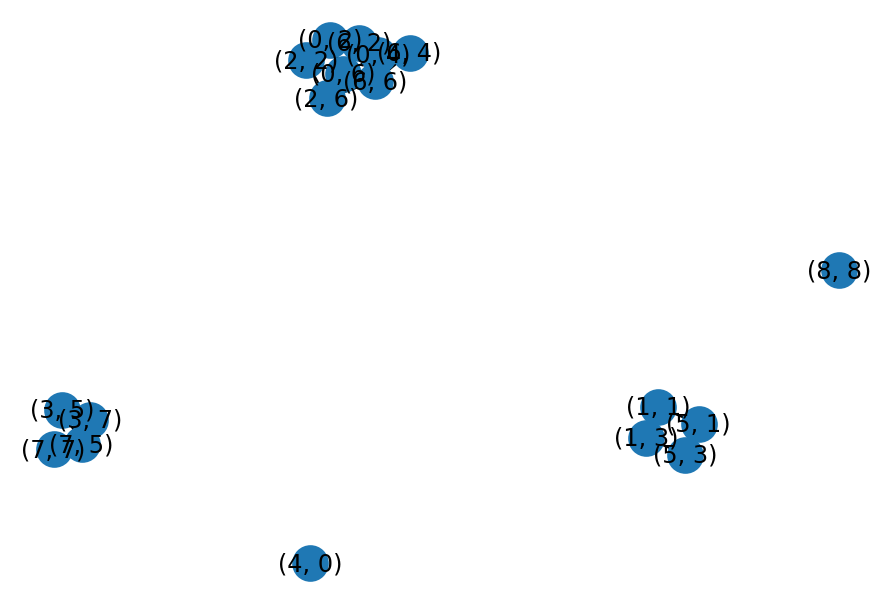

In [386]:
import networkx as nx

j1 = 1
j2 = 1
CGrows = []
colHeaders = []
rowHeaders = [(m1,m2) for m1 in np.arange(-j1,j1+1,1) for m2 in np.arange(-j2,j2+1,1)]
for J in np.arange(np.abs(j1-j2),j1+j2+1,1):
    for mJ in np.arange(-J,J+1,1):
        colHeaders.append((J,mJ))
        row = [cg(j1,j2,J,m1,m2,mJ) for m1 in np.arange(-j1,j1+1,1) for m2 in np.arange(-j2,j2+1,1)]
#         row = [Ket(J,mJ)]+row
        CGrows.append(row)
CGmatrix = sp.Matrix(CGrows)

connectome = []
nonz = list(CGmatrix.todok().keys())
for node in nonz:
    connectome.extend([(node,k) for k in nonz if ((k[0] == node[0] or k[1] == node[1]))])
CGdok = CGmatrix.todok()
CGgraph = nx.Graph()
CGgraph.add_edges_from(connectome)
plt.figure()
nx.draw(CGgraph, with_labels = True)
plt.show()

# reorganize columns and rows into block - diagonal form
components = list(nx.connected_components(CGgraph))
components.sort(key=len)
size = CGmatrix.rows
blocks = []
index_maps_h = {}
index_maps_v = {}
block_stride = 0
for component in components:
    component = list(component)
    indices_0 = sorted(list(set([x[0] for x in component])))
    indices_1 = sorted(list(set([x[1] for x in component])))
    assert len(indices_0) == len(indices_1)
    block_size = len(indices_0)
    mapping_v = {i0:k for k,i0 in zip(range(block_size),indices_0)}
    mapping_h = {i1:k for k,i1 in zip(range(block_size),indices_1)}
    index_maps_v.update({(k+block_stride):i0 for k,i0 in zip(range(block_size),indices_0)})
    index_maps_h.update({(k+block_stride):i1 for k,i1 in zip(range(block_size),indices_1)})
    block = {(mapping_v[c[0]], mapping_h[c[1]]):CGdok[(c[0],c[1])] for c in component}
    blocks.append(sp.SparseMatrix(block_size,block_size,block))
    block_stride += block_size
# calculate the permutted bases
newrowHeaders=[rowHeaders[index_maps_h[k]] for k in range(size)]
newcolHeaders=[colHeaders[index_maps_v[k]] for k in range(size)]
# parse for printing
row0 = sp.Matrix(list(map(lambda x: Ket(*x),newrowHeaders))).T
col0 = sp.Matrix(list(map(lambda x: Ket(*x),newcolHeaders)))
# assemble the block diagonal matrix from the individual blocks
CG_blocks = sp.Matrix(sp.BlockDiagMatrix(*blocks))

In [387]:
sp.Matrix(sp.BlockMatrix([[sp.Matrix([0]),row0],[col0,CG_blocks]]))

Matrix([
[    0, |-1-1>, |11>,      |-10>,     |0-1>,       |01>,      |10>,      |-11>,       |00>,     |1-1>],
[|2-2>,      1,    0,          0,         0,          0,         0,          0,          0,         0],
[ |22>,      0,    1,          0,         0,          0,         0,          0,          0,         0],
[|1-1>,      0,    0, -sqrt(2)/2, sqrt(2)/2,          0,         0,          0,          0,         0],
[|2-1>,      0,    0,  sqrt(2)/2, sqrt(2)/2,          0,         0,          0,          0,         0],
[ |11>,      0,    0,          0,         0, -sqrt(2)/2, sqrt(2)/2,          0,          0,         0],
[ |21>,      0,    0,          0,         0,  sqrt(2)/2, sqrt(2)/2,          0,          0,         0],
[ |00>,      0,    0,          0,         0,          0,         0,  sqrt(3)/3, -sqrt(3)/3, sqrt(3)/3],
[ |10>,      0,    0,          0,         0,          0,         0, -sqrt(2)/2,          0, sqrt(2)/2],
[ |20>,      0,    0,          0,         0,          0

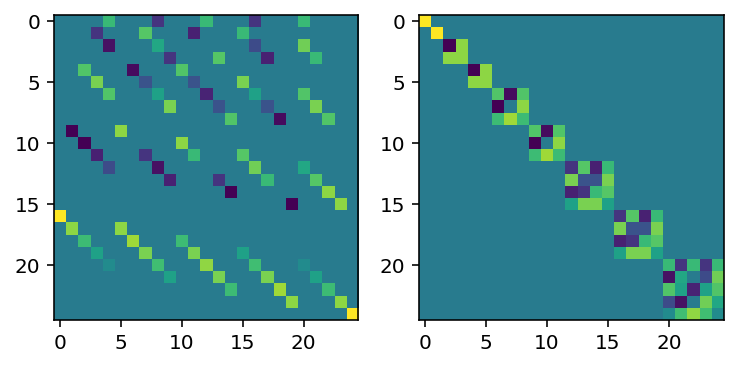

In [376]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(np.array(CGmatrix).astype(np.float64))
axes[1].imshow(np.array(CG_blocks).astype(np.float64))
plt.show()

Now we add the L to S.

In [692]:
# this is how their spin angular momentum would add up
# to give total spin S
Skets = addtwo(sp.S(1)/2,sp.S(1)/2)
for k in Skets:
    display(Math(sp.latex(Ket(*k))+'_S = '+sp.latex(Skets[k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [693]:
# this is how their orbital angular momentum would add up
# to give total angular orbital momentum L
Lkets = addtwo(1,1)
for k in Lkets:
    display(Math(sp.latex(Ket(*k))+'_L = '+sp.latex(Lkets[k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [694]:
# we first separate out the different values for S, and for L
Skets_partitioned = {s:{k:v for k,v in Skets.items() if k[0] == s} for s in list(set(x[0] for x in Skets.keys()))}
Lkets_partitioned = {s:{k:v for k,v in Lkets.items() if k[0] == s} for s in list(set(x[0] for x in Lkets.keys()))}

In [234]:
def KetTensorProduct(ket1,ket2):
    ket1symbs = list(ket1.free_symbols)
    ket2symbs = list(ket2.free_symbols)
    return sum([Ket(*qnums1.args[0],*qnums2.args[0])*ket1.coeff(qnums1)*ket2.coeff(qnums2) for qnums1 in ket1symbs for qnums2 in ket2symbs])
# def KetTensorProductDict(ket1,ket2):
#     ket1symbs = list(ket1.free_symbols)
#     ket2symbs = list(ket2.free_symbols)
#     return ({Ket(*qnums1.args[0],*qnums2.args[0]):ket1.coeff(qnums1)*ket2.coeff(qnums2) for qnums1 in ket1symbs for qnums2 in ket2symbs})

In [696]:
LS_couples = {}
# next one adds up angular momental using the keys of the sectors in S and L
for j1 in Lkets_partitioned.keys():
    # here i will now only keep the m_L value
    clearj1 = {k[1]:v for k,v in Lkets_partitioned[j1].items()}
    for j2 in Skets_partitioned.keys():
        # here i will now only keep the m_S value
        clearj2 = {k[1]:v for k,v in Skets_partitioned[j2].items()}
        j1j2 = addtwo(j1,j2)
        # using the expressions for (j1,mj1,j2,mj2) one makes a dictionary to replace
        # what the kets in j1j2 evaluate to in terms of the original bases
        # its a matter of concateneting their quantum numbers and multiplying their coefficients
        reps = {Ket((q1,q2)): (KetTensorProduct(v1,v2)) for q1,v1 in clearj1.items() for q2,v2 in clearj2.items()}
        # using this dictionary, one then replaces the kets in j1j2
        totals = {k: v.subs(reps) for k,v in j1j2.items()}
        # save results
        LS_couples[(j1,j2)] = totals

In [697]:
rows = []
row_labels = []
totalbasis = set()
for kpair in LS_couples:
    for k, v in LS_couples[kpair].items():
        totalbasis.update(v.free_symbols)
totalbasis = list(totalbasis)
for kpair in LS_couples:
    for k, v in LS_couples[kpair].items():
        vdict = v.as_coefficients_dict()
        v = sp.expand(v)
        row = [v.coeff(tb) for tb in totalbasis]
        if sum(np.abs(np.array(row))) == 0:
            print(v)
            1/0
        row_labels.append(k)
        rows.append(row)
CGmatrix = sp.Matrix(rows)

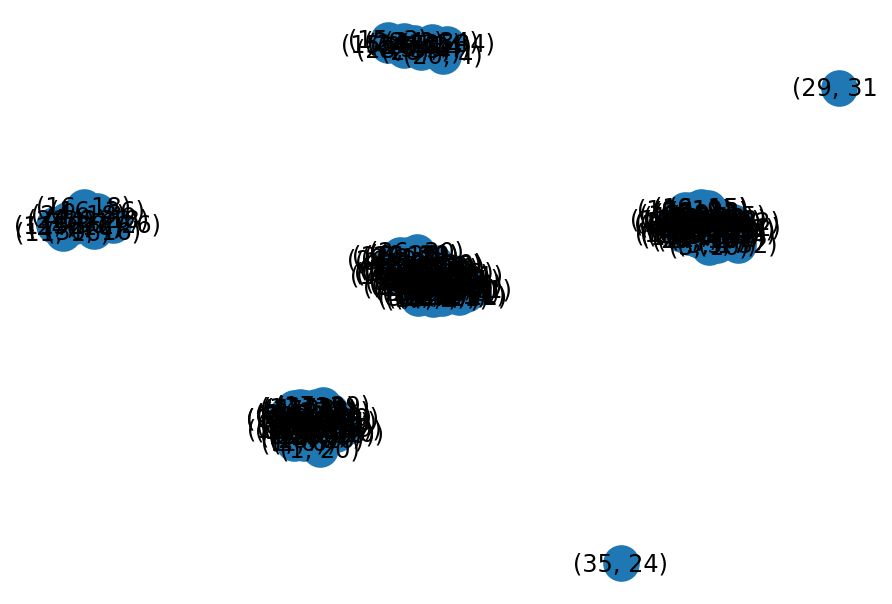

In [698]:
connectome = []
nonz = list(CGmatrix.todok().keys())
for node in nonz:
    connectome.extend([(node,k) for k in nonz if ((k[0] == node[0] or k[1] == node[1]))])
CGdok = CGmatrix.todok()
CGgraph = nx.Graph()
CGgraph.add_edges_from(connectome)
plt.figure()
nx.draw(CGgraph, with_labels = True)
plt.show()

# reorganize columns and rows into block - diagonal form
components = list(nx.connected_components(CGgraph))
components.sort(key=len)
size = CGmatrix.rows
blocks = []
index_maps_h = {}
index_maps_v = {}
block_stride = 0
for component in components:
    component = list(component)
    indices_0 = sorted(list(set([x[0] for x in component])))
    indices_1 = sorted(list(set([x[1] for x in component])))
    assert len(indices_0) == len(indices_1)
    block_size = len(indices_0)
    mapping_v = {i0:k for k,i0 in zip(range(block_size),indices_0)}
    mapping_h = {i1:k for k,i1 in zip(range(block_size),indices_1)}
    index_maps_v.update({(k+block_stride):i0 for k,i0 in zip(range(block_size),indices_0)})
    index_maps_h.update({(k+block_stride):i1 for k,i1 in zip(range(block_size),indices_1)})
    block = {(mapping_v[c[0]], mapping_h[c[1]]):CGdok[(c[0],c[1])] for c in component}
    blocks.append(sp.SparseMatrix(block_size,block_size,block))
    block_stride += block_size
# calculate the permutted bases
newrowHeaders=[row_labels[index_maps_h[k]] for k in range(size)]
newcolHeaders=[totalbasis[index_maps_v[k]] for k in range(size)]
# parse for printing
row0 = sp.Matrix(list(map(lambda x: Ket(*x),newrowHeaders))).T
col0 = sp.Matrix(newcolHeaders)
# assemble the block diagonal matrix from the individual blocks
CG_blocks = sp.Matrix(sp.BlockDiagMatrix(*blocks))

In [778]:
amatrix = blocks[2]

In [705]:
from itertools import permutations

In [762]:
newmatrices = []
for row_permutation in permutations(range(amatrix.rows)):
    anew_matrix = amatrix.tolist()
    anew = [[]]*len(anew_matrix)
    for idx, k in enumerate(row_permutation):
        anew[idx] = anew_matrix[k]
    anew = sp.Matrix(anew).T.tolist()
    for col_permutation in permutations(range(amatrix.rows)):
        anew2 = [[]]*len(anew_matrix)
        for idx, kp in enumerate(col_permutation):
            anew2[idx] = anew[kp]
        anew2 = sp.Matrix(anew2).T
        newmatrices.append(anew2)
        if abs(anew2.T) == abs(anew2):
            print("aha")

In [753]:
diffs = [np.sum(np.abs(np.array(mat-mat.T).astype(np.float64))) for mat in newmatrices]

In [779]:
from itertools import product

In [786]:
set(amatrix)

{-sqrt(3)/3,
 -1/2,
 -sqrt(2)/4,
 -sqrt(30)/20,
 -sqrt(6)/12,
 0,
 sqrt(15)/30,
 sqrt(15)/15,
 sqrt(3)/6,
 sqrt(2)/4,
 sqrt(30)/15,
 1/2,
 2*sqrt(15)/15,
 sqrt(3)/3,
 sqrt(15)/5}

In [ ]:
anew_matrix.is_symmetric

In [806]:
newmatrices = []
amatrix = blocks[3]
assert len(set(amatrix)) <= amatrix.rows*(amatrix.rows+1)/2
print("Trying %d alternatives ..." % (sp.factorial(amatrix.rows)**2))
for row_permutation, col_permutation in product(permutations(range(amatrix.rows)),
                                                permutations(range(amatrix.rows))):
    anew_matrix = sp.Matrix(amatrix)
    anew_matrix = anew_matrix.permute(row_permutation, orientation='rows')
    anew_matrix = anew_matrix.permute(col_permutation, orientation='cols')
    if anew_matrix.is_symmetric() or anew_matrix.is_anti_symmetric():
            print("aha")
            break
else:
    print("No symmetric or anti-symmetric permutation found.")

Trying 576 alternatives ...
No symmetric or anti-symmetric permutation found.


In [783]:
newmatrices = []
amatrix = blocks[4]
for row_permutation in permutations(range(amatrix.rows)):
    anew_matrix = sp.Matrix(amatrix)
    anew_matrix = anew_matrix.permute(row_permutation, orientation='rows')
    for col_permutation in permutations(range(amatrix.rows)):
        anew_matrix = anew_matrix.permute(col_permutation, orientation='cols')
        newmatrices.append(anew_matrix)
        if abs(anew_matrix.T) == abs(anew_matrix):
            print("aha")

KeyboardInterrupt: 

In [776]:
diffs = np.array([np.sum(np.abs(np.array(mat-mat.T).astype(np.float64))) for mat in newmatrices])

In [777]:
newmatrices[np.argmin(diffs)]

Matrix([
[0, 1, 0],
[1, 0, 1],
[0, 1, 0]])

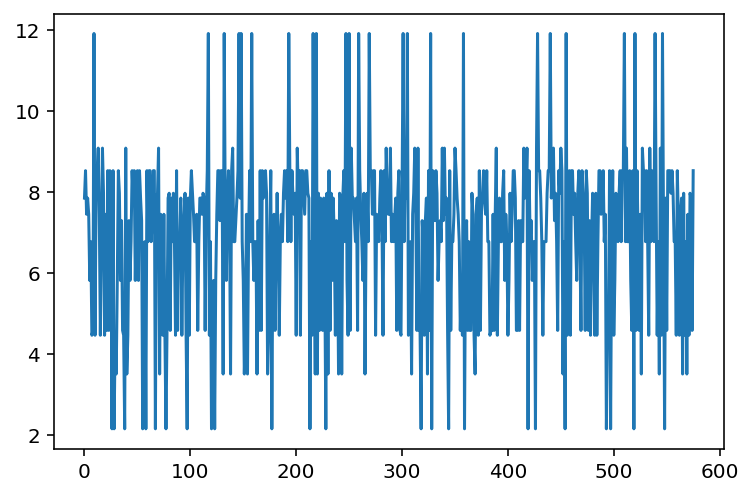

In [769]:
plt.figure()
plt.plot(diffs)
plt.show()

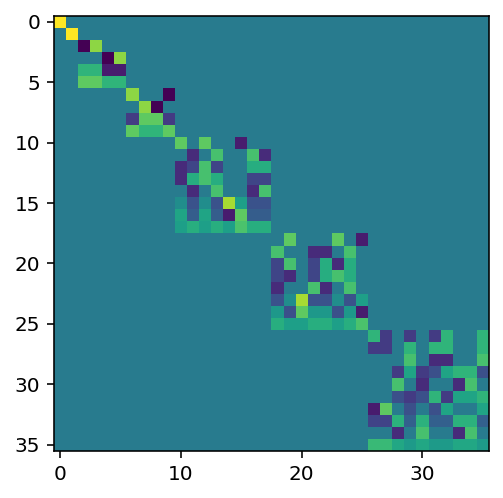

In [701]:
plt.figure()
plt.imshow(np.array(CG_blocks).astype(np.float64))
plt.show()

In [578]:
for kpair in LS_couples:
    for k, v in LS_couples[kpair].items():
        print(k)
        display(v)

(0, 0)


sqrt(6)*(-|-11-1/21/2> + |-111/2-1/2> + |00-1/21/2> - |001/2-1/2> - |1-1-1/21/2> + |1-11/2-1/2>)/6

(1, -1)


sqrt(3)*(|-11-1/2-1/2> - |00-1/2-1/2> + |1-1-1/2-1/2>)/3

(1, 0)


sqrt(6)*(|-11-1/21/2> + |-111/2-1/2> - |00-1/21/2> - |001/2-1/2> + |1-1-1/21/2> + |1-11/2-1/2>)/6

(1, 1)


sqrt(3)*(|-111/21/2> - |001/21/2> + |1-11/21/2>)/3

(1, -1)


(|-10-1/21/2> - |-101/2-1/2> - |0-1-1/21/2> + |0-11/2-1/2>)/2

(1, 0)


(|-11-1/21/2> - |-111/2-1/2> - |1-1-1/21/2> + |1-11/2-1/2>)/2

(1, 1)


(|01-1/21/2> - |011/2-1/2> - |10-1/21/2> + |101/2-1/2>)/2

(0, 0)


sqrt(6)*(-|-101/21/2> + |0-11/21/2>)/6 + sqrt(6)*(-|01-1/2-1/2> + |10-1/2-1/2>)/6 - sqrt(3)*(-|-11-1/21/2> - |-111/2-1/2> + |1-1-1/21/2> + |1-11/2-1/2>)/6

(1, -1)


(-|-11-1/2-1/2> + |1-1-1/2-1/2>)/2 - sqrt(2)*(-|-10-1/21/2> - |-101/2-1/2> + |0-1-1/21/2> + |0-11/2-1/2>)/4

(1, 0)


-(-|-101/21/2> + |0-11/21/2>)/2 + (-|01-1/2-1/2> + |10-1/2-1/2>)/2

(1, 1)


-(-|-111/21/2> + |1-11/21/2>)/2 + sqrt(2)*(-|01-1/21/2> - |011/2-1/2> + |10-1/21/2> + |101/2-1/2>)/4

(2, -2)


sqrt(2)*(-|-10-1/2-1/2> + |0-1-1/2-1/2>)/2

(2, -1)


(-|-11-1/2-1/2> + |1-1-1/2-1/2>)/2 + sqrt(2)*(-|-10-1/21/2> - |-101/2-1/2> + |0-1-1/21/2> + |0-11/2-1/2>)/4

(2, 0)


sqrt(3)*(-|-101/21/2> + |0-11/21/2>)/6 + sqrt(3)*(-|01-1/2-1/2> + |10-1/2-1/2>)/6 + sqrt(6)*(-|-11-1/21/2> - |-111/2-1/2> + |1-1-1/21/2> + |1-11/2-1/2>)/6

(2, 1)


(-|-111/21/2> + |1-11/21/2>)/2 + sqrt(2)*(-|01-1/21/2> - |011/2-1/2> + |10-1/21/2> + |101/2-1/2>)/4

(2, 2)


sqrt(2)*(-|011/21/2> + |101/21/2>)/2

(2, -2)


sqrt(2)*(-|-1-1-1/21/2> + |-1-11/2-1/2>)/2

(2, -1)


(-|-10-1/21/2> + |-101/2-1/2> - |0-1-1/21/2> + |0-11/2-1/2>)/2

(2, 0)


sqrt(3)*(-|-11-1/21/2> + |-111/2-1/2> - 2*|00-1/21/2> + 2*|001/2-1/2> - |1-1-1/21/2> + |1-11/2-1/2>)/6

(2, 1)


(-|01-1/21/2> + |011/2-1/2> - |10-1/21/2> + |101/2-1/2>)/2

(2, 2)


sqrt(2)*(-|11-1/21/2> + |111/2-1/2>)/2

(1, -1)


sqrt(15)*(|-11-1/2-1/2> + 2*|00-1/2-1/2> + |1-1-1/2-1/2>)/30 - sqrt(30)*(|-10-1/21/2> + |-101/2-1/2> + |0-1-1/21/2> + |0-11/2-1/2>)/20 + sqrt(15)*|-1-11/21/2>/5

(1, 0)


sqrt(15)*(|-101/21/2> + |0-11/21/2>)/10 + sqrt(15)*(|01-1/2-1/2> + |10-1/2-1/2>)/10 - sqrt(30)*(|-11-1/21/2> + |-111/2-1/2> + 2*|00-1/21/2> + 2*|001/2-1/2> + |1-1-1/21/2> + |1-11/2-1/2>)/30

(1, 1)


sqrt(15)*(|-111/21/2> + 2*|001/21/2> + |1-11/21/2>)/30 - sqrt(30)*(|01-1/21/2> + |011/2-1/2> + |10-1/21/2> + |101/2-1/2>)/20 + sqrt(15)*|11-1/2-1/2>/5

(2, -2)


-sqrt(3)*(|-1-1-1/21/2> + |-1-11/2-1/2>)/3 + sqrt(6)*(|-10-1/2-1/2> + |0-1-1/2-1/2>)/6

(2, -1)


sqrt(3)*(|-11-1/2-1/2> + 2*|00-1/2-1/2> + |1-1-1/2-1/2>)/6 - sqrt(6)*(|-10-1/21/2> + |-101/2-1/2> + |0-1-1/21/2> + |0-11/2-1/2>)/12 - sqrt(3)*|-1-11/21/2>/3

(2, 0)


-(|-101/21/2> + |0-11/21/2>)/2 + (|01-1/2-1/2> + |10-1/2-1/2>)/2

(2, 1)


-sqrt(3)*(|-111/21/2> + 2*|001/21/2> + |1-11/21/2>)/6 + sqrt(6)*(|01-1/21/2> + |011/2-1/2> + |10-1/21/2> + |101/2-1/2>)/12 + sqrt(3)*|11-1/2-1/2>/3

(2, 2)


-sqrt(6)*(|011/21/2> + |101/21/2>)/6 + sqrt(3)*(|11-1/21/2> + |111/2-1/2>)/3

(3, -3)


|-1-1-1/2-1/2>

(3, -2)


sqrt(6)*(|-1-1-1/21/2> + |-1-11/2-1/2>)/6 + sqrt(3)*(|-10-1/2-1/2> + |0-1-1/2-1/2>)/3

(3, -1)


sqrt(15)*(|-11-1/2-1/2> + 2*|00-1/2-1/2> + |1-1-1/2-1/2>)/15 + sqrt(30)*(|-10-1/21/2> + |-101/2-1/2> + |0-1-1/21/2> + |0-11/2-1/2>)/15 + sqrt(15)*|-1-11/21/2>/15

(3, 0)


sqrt(10)*(|-101/21/2> + |0-11/21/2>)/10 + sqrt(10)*(|01-1/2-1/2> + |10-1/2-1/2>)/10 + sqrt(5)*(|-11-1/21/2> + |-111/2-1/2> + 2*|00-1/21/2> + 2*|001/2-1/2> + |1-1-1/21/2> + |1-11/2-1/2>)/10

(3, 1)


sqrt(15)*(|-111/21/2> + 2*|001/21/2> + |1-11/21/2>)/15 + sqrt(30)*(|01-1/21/2> + |011/2-1/2> + |10-1/21/2> + |101/2-1/2>)/15 + sqrt(15)*|11-1/2-1/2>/15

(3, 2)


sqrt(3)*(|011/21/2> + |101/21/2>)/3 + sqrt(6)*(|11-1/21/2> + |111/2-1/2>)/6

(3, 3)


|111/21/2>

In [492]:
j1 = 1
# these kets are all for l=1, I only keep the m_l values
clearj1 = {k[1]:v for k,v in Lkets_partitioned[j1].items()}
j2 = 1
# these kets are all for s=1/2 I only keep the m_s values
clearj2 = {k[1]:v for k,v in Skets_partitioned[j2].items()}

In [458]:
totals = {}
for k,v in j1j2.items():
    lpart = clearj1[v.args[0][0]]
    spart = clearj2[v.args[0][1]]
    lpart_qnums = list(lpart.free_symbols)
    spart_qnums = list(spart.free_symbols)
    totals[k] = sum([Ket(*lnums.args[0],*snums.args[0])*lpart.coeff(lnums)*spart.coeff(snums) for lnums in lpart_qnums for snums in spart_qnums])

In [459]:
totals

{(0,
  0): -sqrt(6)*|-11-1/21/2>/6 + sqrt(6)*|-111/2-1/2>/6 + sqrt(6)*|00-1/21/2>/6 - sqrt(6)*|001/2-1/2>/6 - sqrt(6)*|1-1-1/21/2>/6 + sqrt(6)*|1-11/2-1/2>/6}

In [440]:
list(spart.free_symbols)[0]

|(-1/2, 1/2)>

In [441]:
spart.coeff(list(spart.free_symbols)[0])

-sqrt(2)/2

In [417]:
Lkets_partitioned[j1]

{(0, 0): sqrt(3)*|(-1, 1)>/3 - sqrt(3)*|(0, 0)>/3 + sqrt(3)*|(1, -1)>/3}

In [413]:
LS_couples[(1,1)]

{(0, 0): sqrt(3)*|(-1, 1)>/3 - sqrt(3)*|(0, 0)>/3 + sqrt(3)*|(1, -1)>/3,
 (1, -1): -sqrt(2)*|(-1, 0)>/2 + sqrt(2)*|(0, -1)>/2,
 (1, 0): -sqrt(2)*|(-1, 1)>/2 + sqrt(2)*|(1, -1)>/2,
 (1, 1): -sqrt(2)*|(0, 1)>/2 + sqrt(2)*|(1, 0)>/2,
 (2, -2): |(-1, -1)>,
 (2, -1): sqrt(2)*|(-1, 0)>/2 + sqrt(2)*|(0, -1)>/2,
 (2, 0): sqrt(6)*|(-1, 1)>/6 + sqrt(6)*|(0, 0)>/3 + sqrt(6)*|(1, -1)>/6,
 (2, 1): sqrt(2)*|(0, 1)>/2 + sqrt(2)*|(1, 0)>/2,
 (2, 2): |(1, 1)>}

## Chapter 3 - Single Electron Atoms

### Compute the energies of the hydrogen atom by solving the radial Schrödinger equation.

$\left(-\frac{d^2}{dr^2} + \frac{l(l+1)}{r^2} - \frac{2}{r}\right)P_{nl} = E P_{nl}$

In [283]:
def radialSchrodinger(y,r,l,E):
    P, dP = y
    return [dP, (-2*1./r + l*(l+1)/r**2-E)*P]

In [300]:
trial_energies = np.linspace(-0.4,0,2000)
r = np.linspace(0.00001,400,20000)
P0 = [0, 1.0]
l = 1
sols = [odeint(radialSchrodinger, P0, r, args = (l,E,))[:,0] for E in trial_energies]
sols = np.array(sols)

In [301]:
boundaries = [sol[-1] for sol in sols]
zero_crossings = np.sort(np.where(np.diff(np.sign(boundaries)))[0])

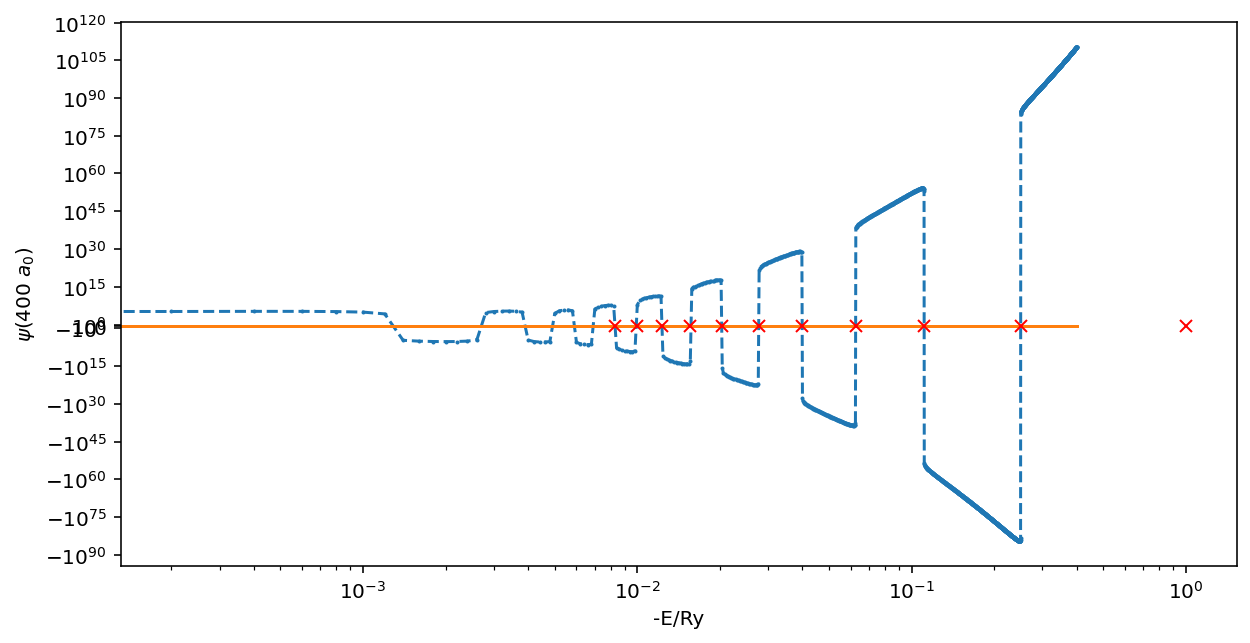

In [302]:
plt.figure(figsize=(10,5))
plt.plot(-trial_energies,boundaries,'o--',ms=1)
plt.plot([-trial_energies[0],-trial_energies[-1]],[0,0])
plt.plot([1/i**2 for i in range(1,12)],[0]*11,'rx')
plt.yscale('symlog')
plt.xscale('log')
plt.ylabel('$\psi$(%.0f $a_0$)' % r[-1])
plt.xlabel('-E/Ry')
plt.show()

In [303]:
gt_energies = np.sort([-1/i**2 for i in range(2,10)])

In [304]:
good_energies = []
for zero_crossing in zero_crossings:
    bl = boundaries[zero_crossing]
    br = boundaries[zero_crossing+1]
    El = trial_energies[zero_crossing]
    Er = trial_energies[zero_crossing+1]
    good_energies.append(np.interp(0,[bl, br],[El,Er]))

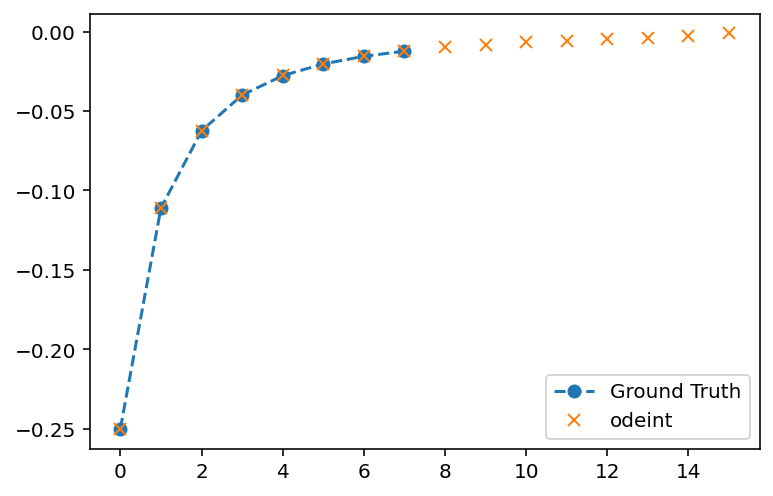

In [305]:
plt.figure()
plt.plot(gt_energies,'o--',label='Ground Truth')
plt.plot(good_energies, 'x', label='odeint')
plt.legend()
plt.show()

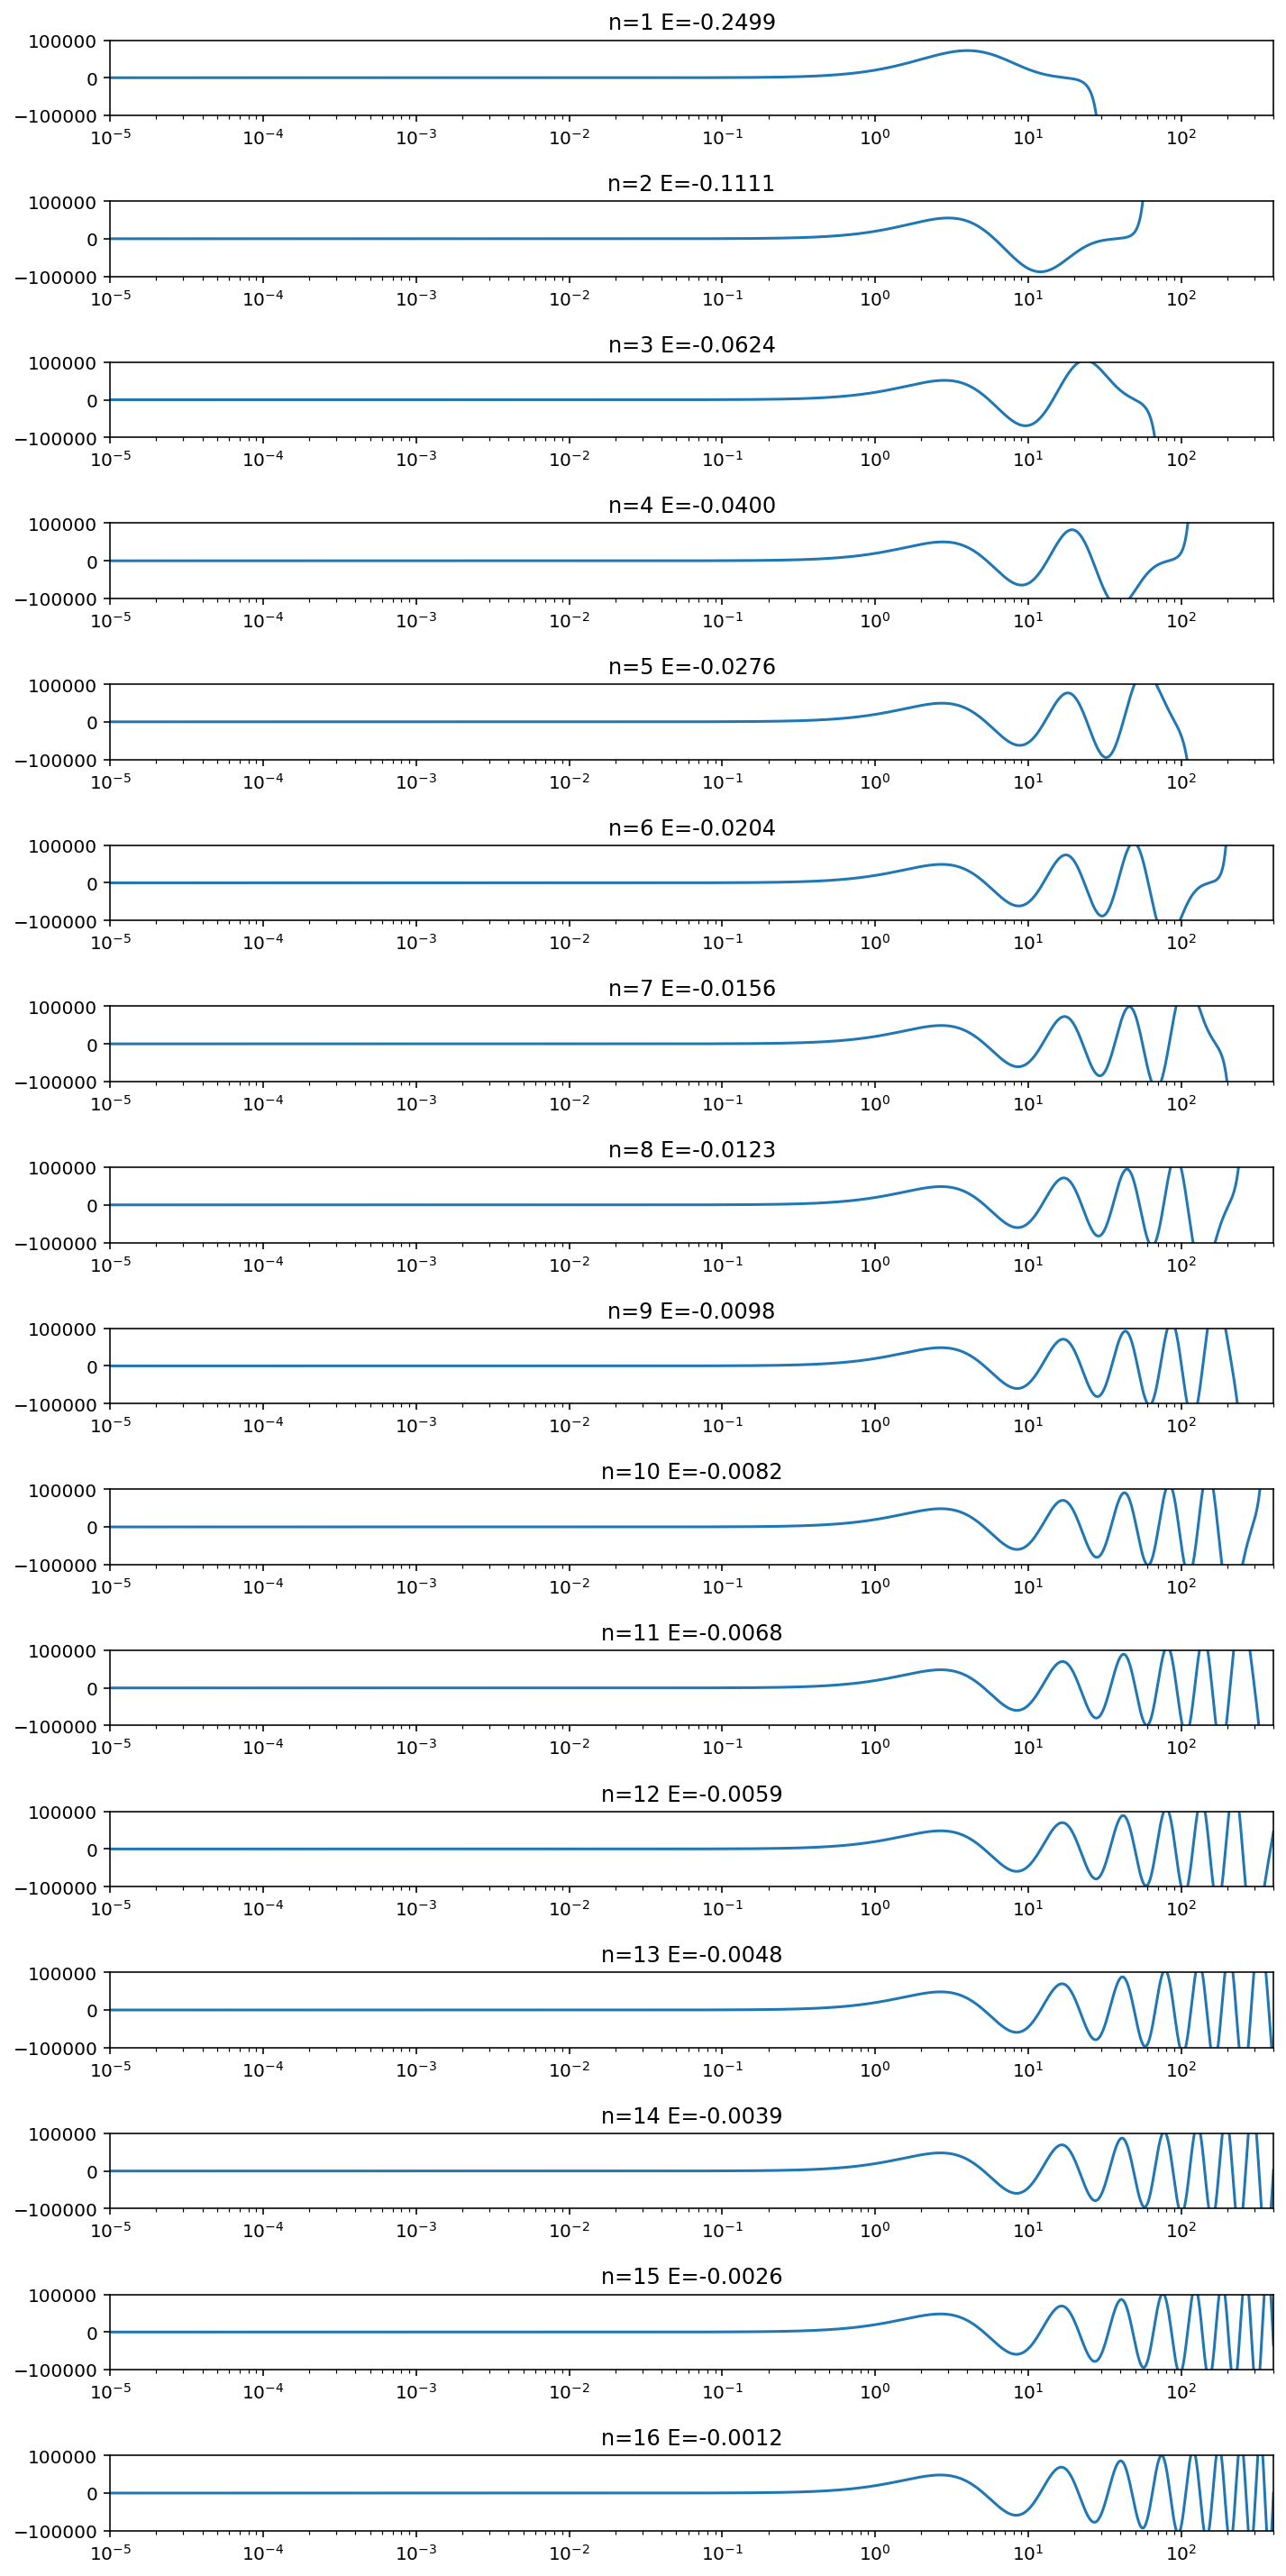

In [317]:
good_sols = [odeint(radialSchrodinger, P0, r, args = (l,E,))[:,0] for E in good_energies]
fig, axes = plt.subplots(nrows=len(good_sols), figsize=(10,20))
counter = 0
for sol, ax in zip(good_sols, axes):
    ax.plot(r, sol)
    ax.set_title('n=%d E=%.4f' % (counter+1, good_energies[counter]))
    ax.set_ylim(-100000,100000)
    ax.set_xlim(r[0],r[-1])
    ax.set_xscale('log')
    counter = counter + 1
plt.tight_layout()
plt.show()

## Chapter 4 - Complex Atoms - The Vector Model

### Permitted LS terms for equivalent electrons

#### Spaguetti code

In [1137]:
from fractions import Fraction

In [1138]:
l1, l2 = 1, 1
configs = []
for ml1 in range(-l1,l1+1):
    for ml2 in range(-l2, l2+1):
        for ms1 in [-Fraction(1,2), Fraction(1,2)]:
            for ms2 in [-Fraction(1,2), Fraction(1,2)]:
                ML = ml1 + ml2
                MS = ms1 + ms2
                M = ML + MS
                if (ml1, ms1) == (ml2, ms2):
                    continue
                config = [ml1,ms1,ml2,ms2,ML,MS,M]
                pconfig = list(config)
                pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
                if pconfig in configs:
                    continue
                configs.append(config)
# configs = np.array(configs)

In [1139]:
MLs = range(-2,3)
microstates = {}
for ML in MLs:
    subconfigs = [config for config in configs if config[4]==ML]
    minus1_configs = [config[:4] for config in subconfigs if config[5]==-1] #subconfigs[(subconfigs[:,5] == -1)]
    zero_configs = [config[:4] for config in subconfigs if config[5]==0]
    plus1_configs = [config[:4] for config in subconfigs if config[5]==1]
    microstates[(ML,-1)] = minus1_configs
    microstates[(ML,0)] = zero_configs
    microstates[(ML,1)] = plus1_configs

In [1140]:
from itertools import product

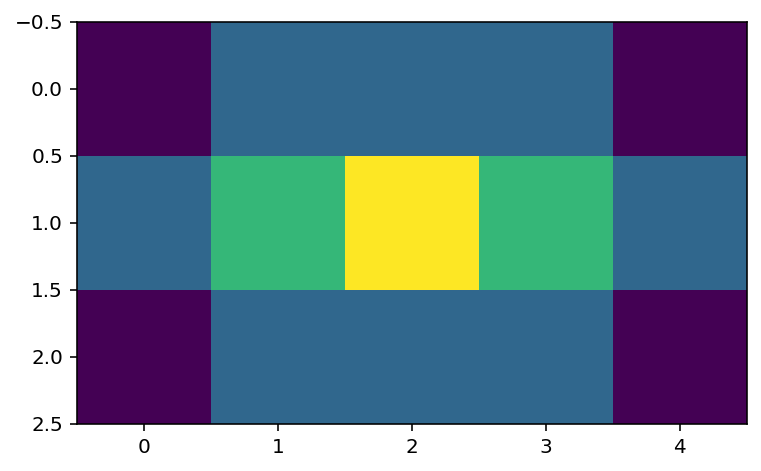

In [1141]:
neighborhood = np.array([[len(microstates[(k1,k2)]) for k1 in [-2,-1,0,1,2]] for k2 in [-1,0,1]])
plt.figure()
plt.imshow(neighborhood)
plt.show()

In [1142]:
l1, l2 = 2,2
configs = []
for ml1 in range(-l1,l1+1):
    for ml2 in range(-l2, l2+1):
        for ms1 in [-Fraction(1,2), Fraction(1,2)]:
            for ms2 in [-Fraction(1,2), Fraction(1,2)]:
                ML = ml1 + ml2
                MS = ms1 + ms2
                M = ML + MS
                if (ml1, ms1) == (ml2, ms2):
                    continue
                config = [ml1,ms1,ml2,ms2,ML,MS,M]
                pconfig = list(config)
                pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
                if pconfig in configs:
                    continue
                configs.append(config)
# configs = np.array(configs)

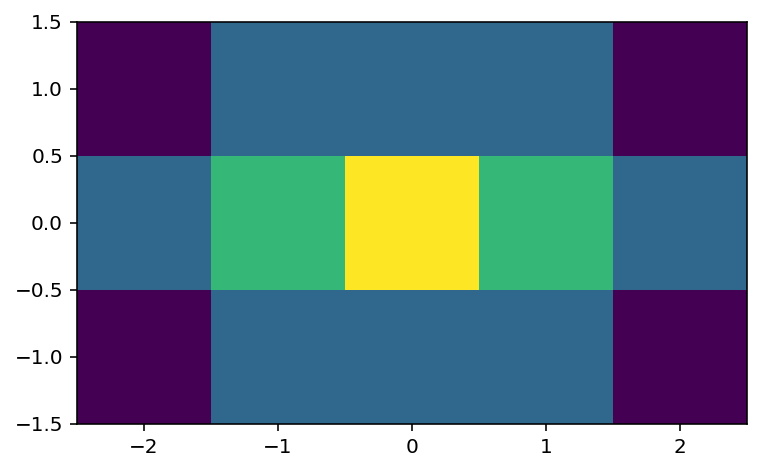

In [1143]:
neighborhood = np.array([[len(microstates[(k1,k2)]) for k1 in MLs] for k2 in [-1,0,1]])
plt.figure()
plt.imshow(neighborhood,extent=[MLs[0]-0.5,MLs[-1]+0.5,-1.5,1.5])
plt.show()

In [1145]:
MLs = range(-4,5)
microstates = {}
for ML in MLs:
    subconfigs = [config for config in configs if config[4]==ML]
    minus1_configs = [config[:4] for config in subconfigs if config[5]==-1] #subconfigs[(subconfigs[:,5] == -1)]
    zero_configs = [config[:4] for config in subconfigs if config[5]==0]
    plus1_configs = [config[:4] for config in subconfigs if config[5]==1]
    microstates[(ML,-1)] = minus1_configs
    microstates[(ML,0)] = zero_configs
    microstates[(ML,1)] = plus1_configs

In [1146]:
ziggurat = [[k,l,len(microstates[(k,l)])] for k in range(MLs[0],MLs[-1]+1) for l in [-1,0,1]]
levels = sorted(list(set([len(microstates[(k,l)]) for k in range(MLs[0],MLs[-1]+1) for l in [-1,0,1]])))
ziggurat = np.array(ziggurat)
levels = levels[-1::-1]

In [1147]:
floors = {}
for level in levels:
    if level == 0:
        continue
    floor = ziggurat[ziggurat[:,2] >= level]
    floors[level] = (floor)

In [1148]:
sets = {}
for level in levels:
    if level == 0:
        continue
    sets[level] = [microstates[tuple(apt[:2])].pop() for apt in floors[level]]

In [1149]:
sets

{5: [[0, Fraction(-1, 2), 0, Fraction(1, 2)]],
 4: [[-1, Fraction(1, 2), 0, Fraction(-1, 2)],
  [-1, Fraction(1, 2), 1, Fraction(-1, 2)],
  [0, Fraction(1, 2), 1, Fraction(-1, 2)]],
 3: [[-1, Fraction(-1, 2), -1, Fraction(1, 2)],
  [-1, Fraction(-1, 2), 0, Fraction(1, 2)],
  [-1, Fraction(-1, 2), 1, Fraction(1, 2)],
  [0, Fraction(-1, 2), 1, Fraction(1, 2)],
  [1, Fraction(-1, 2), 1, Fraction(1, 2)]],
 2: [[-2, Fraction(1, 2), -1, Fraction(-1, 2)],
  [-2, Fraction(1, 2), 0, Fraction(-1, 2)],
  [-1, Fraction(-1, 2), 0, Fraction(-1, 2)],
  [-2, Fraction(1, 2), 1, Fraction(-1, 2)],
  [-1, Fraction(1, 2), 0, Fraction(1, 2)],
  [-1, Fraction(-1, 2), 1, Fraction(-1, 2)],
  [-2, Fraction(1, 2), 2, Fraction(-1, 2)],
  [-1, Fraction(1, 2), 1, Fraction(1, 2)],
  [0, Fraction(-1, 2), 1, Fraction(-1, 2)],
  [-1, Fraction(1, 2), 2, Fraction(-1, 2)],
  [0, Fraction(1, 2), 1, Fraction(1, 2)],
  [0, Fraction(1, 2), 2, Fraction(-1, 2)],
  [1, Fraction(1, 2), 2, Fraction(-1, 2)]],
 1: [[-2, Fraction(-1,

In [1150]:
MLs = range(-4,5)
microstates = {}
for ML in MLs:
    subconfigs = [config for config in configs if config[4]==ML]
    minus1_configs = [config[:4] for config in subconfigs if config[5]==-1] #subconfigs[(subconfigs[:,5] == -1)]
    zero_configs = [config[:4] for config in subconfigs if config[5]==0]
    plus1_configs = [config[:4] for config in subconfigs if config[5]==1]
    microstates[(ML,-1)] = minus1_configs
    microstates[(ML,0)] = zero_configs
    microstates[(ML,1)] = plus1_configs
while True:
    # find the ones that are non-empty and their distances to the bottom left corner
    non_empty = [[k,abs(MLs[0]-k[0])+abs(-1-k[1])] for k in microstates.keys() if len(microstates[k])>0]
    if len(non_empty) == 0:
        break
    # take the corner that is closest to the bottom left corner
    corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
    print(corner)
    # make a copy of the starting position
    start_corner = tuple(corner)
    jumps = []
    while True:
        # check to see if corner is already at margin
        print('-',corner)
        if 'up' in jumps or 'right' in jumps:
            jump = jumps[-1]
        else:
            # define the three target positions
            up = (corner[0], corner[1]+1)
            if up in microstates.keys():
                up_boo = (len(microstates[up])>0)
            else:
                up_boo = False
            right = (corner[0]+1, corner[1])
            if right in microstates.keys():
                right_boo = (len(microstates[right])>0)
            else:
                right_boo = False
            diag = (corner[0]+1, corner[1]+1)
            if diag in microstates.keys():
                diag_boo = (len(microstates[diag])>0)
            else:
                diag_boo = False
            diag_boo = (diag_boo and up_boo and right_boo)
            if diag_boo:
                jump = 'diagonal'
            elif right_boo:
                jump = 'right'
            elif up_boo:
                jump = 'up'
            if not right_boo and not up_boo and not diag_boo:
                jump = 'end'
                print('end')
                break
            jumps.append(jump)
        # change the corner to the new position
        initial_corner = tuple(corner)
        if jump == 'diagonal':
            corner = (corner[0]+1, corner[1]+1)
        elif jump == 'right':
            corner = (corner[0]+1, corner[1])
        elif jump == 'up':
            corner = (corner[0], corner[1]+1)
        if corner[0] > MLs[-1] or corner[1] > 1:
            corner = initial_corner
            break
        if jump == 'end':
            break
        jumps.append(jump)
    end_corner = tuple(corner)
    print('--',end_corner)
    # collect items
    if end_corner[1] == start_corner[1]:
        bag = [microstates[(k,end_corner[1])].pop() for k in range(start_corner[0], end_corner[0]+1)]
    else:
        bag = [microstates[(k,j)].pop() for k in range(start_corner[0], end_corner[0]+1) for j in range(start_corner[1], end_corner[1]+1)]
    time.sleep(0.1)

(-4, 0)
- (-4, 0)
- (-3, 0)
- (-2, 0)
- (-1, 0)
- (0, 0)
- (1, 0)
- (2, 0)
- (3, 0)
- (4, 0)
-- (4, 0)
(-3, -1)
- (-3, -1)
- (-2, 0)
- (-1, 1)
- (0, 1)
- (1, 1)
- (2, 1)
- (3, 1)
- (4, 1)
-- (4, 1)


IndexError: pop from empty list

In [1151]:
import copy

In [1153]:
l1, l2 = 3,3
configs = []
for ml1 in range(-l1,l1+1):
    for ml2 in range(-l2, l2+1):
        for ms1 in [-Fraction(1,2), Fraction(1,2)]:
            for ms2 in [-Fraction(1,2), Fraction(1,2)]:
                ML = ml1 + ml2
                MS = ms1 + ms2
                M = ML + MS
                if (ml1, ms1) == (ml2, ms2):
                    continue
                config = [ml1,ms1,ml2,ms2,ML,MS,M]
                pconfig = list(config)
                pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
                if pconfig in configs:
                    continue
                configs.append(config)

MLs = range(-(l1+l2),(l1+l2)+1)
microstates = {}
for ML in MLs:
    subconfigs = [config for config in configs if config[4]==ML]
    minus1_configs = [config[:4] for config in subconfigs if config[5]==-1] #subconfigs[(subconfigs[:,5] == -1)]
    zero_configs = [config[:4] for config in subconfigs if config[5]==0]
    plus1_configs = [config[:4] for config in subconfigs if config[5]==1]
    microstates[(ML,-1)] = minus1_configs
    microstates[(ML,0)] = zero_configs
    microstates[(ML,1)] = plus1_configs
pristine_microstates = copy.deepcopy(microstates)
# find the non-empty ones
# from those pick the coordinates that are closest to the lower left corner
# if it is possible to to diagonally to the upper right, then this is a boxy box
# if not, then it is a row
collections = {}
while True:
    non_empty = [[k,abs(MLs[0]-k[0])+abs(-1-k[1])] for k in microstates.keys() if len(microstates[k])>0]
    if len(non_empty) == 0:
        break
    corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
    if corner == (0,0):
        case = 'box'
        start = (0,0)
        end = (0,0)
    else:
        right = (corner[0]+1, corner[1])
        up = (corner[0], corner[1]+1)
        diag = (corner[0]+1, corner[1]+1)
        if up in microstates.keys():
            up_bool = len(microstates[up]) > 0
        else:
            up_bool = False
        if right in microstates.keys():
            right_bool = len(microstates[right]) > 0
        else:
            right_bool = False
        if diag in microstates.keys():
            diag_bool = len(microstates[diag]) > 0
        else:
            diag_bool = False
        if diag_bool and up_bool and right_bool:
            case = 'box'
            start = corner
            end = (-corner[0], -corner[1])
        elif up_bool and not right_bool:
            case = 'col'
            start = corner
            end = (corner[0],-corner[1])
        else:
            case = 'row'
            start = corner
            end = (-corner[0], corner[1])
    if case == 'row':
        collect = []
        for k in range(start[0], end[0]+1):
            microstates[(k,0)].pop()
            collect.extend(pristine_microstates[(k,0)])
    elif case == 'col':
        collect = []
        for k in range(start[1], end[1]+1):
            microstates[(start[0],k)].pop()
            collect.extend(pristine_microstates[(start[0],k)])
    elif case == 'box':
        collect = []
        for k in range(start[0], end[0]+1):
            for l in range(start[1],end[1]+1):
                (microstates[(k,l)].pop())
                collect.extend(pristine_microstates[(k,l)])
    collections[abs(start[0])] = (collect)

terms = []
for collection in collections:
    L = max(np.array(collections[collection])[:,0] + np.array(collections[collection])[:,2])
    S = max(np.array(collections[collection])[:,1] + np.array(collections[collection])[:,3])
    if int(S) == S:
        S = int(S)
    terms.append([{0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I'}[L],2*S+1])
print(terms)

[['I', 1], ['H', 3], ['G', 1], ['F', 3], ['D', 1], ['P', 3], ['S', 1]]


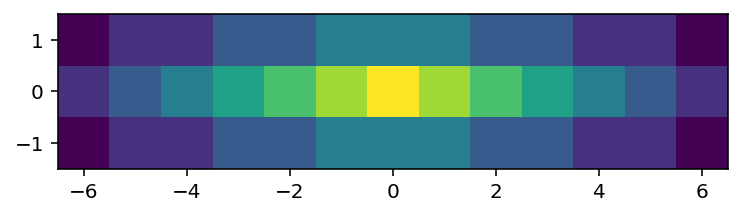

In [1154]:
neighborhood = np.array([[len(pristine_microstates[(k1,k2)]) for k1 in MLs] for k2 in [-1,0,1]])
plt.figure()
plt.imshow(neighborhood,extent=[MLs[0]-0.5,MLs[-1]+0.5,-1.5,1.5])
plt.show()

In [1155]:
def calculateterms2(l1,l2):
    atlas = dict(zip('spdfg',[0,1,2,3]))
    if l1 not in [0,1,2,3,4]:
        l1, l2 = atlas[l1], atlas[l2]
    configs = []
    for ml1 in range(-l1,l1+1):
        for ml2 in range(-l2, l2+1):
            for ms1 in [-Fraction(1,2), Fraction(1,2)]:
                for ms2 in [-Fraction(1,2), Fraction(1,2)]:
                    ML = ml1 + ml2
                    MS = ms1 + ms2
                    M = ML + MS
                    if (ml1, ms1) == (ml2, ms2):
                        continue
                    config = [ml1,ms1,ml2,ms2,ML,MS,M]
                    pconfig = list(config)
                    pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
                    if pconfig in configs:
                        continue
                    configs.append(config)
    MLs = range(-(l1+l2),(l1+l2)+1)
    microstates = {}
    for ML in MLs:
        subconfigs = [config for config in configs if config[4]==ML]
        minus1_configs = [config[:4] for config in subconfigs if config[5]==-1] #subconfigs[(subconfigs[:,5] == -1)]
        zero_configs = [config[:4] for config in subconfigs if config[5]==0]
        plus1_configs = [config[:4] for config in subconfigs if config[5]==1]
        microstates[(ML,-1)] = minus1_configs
        microstates[(ML,0)] = zero_configs
        microstates[(ML,1)] = plus1_configs
    pristine_microstates = copy.deepcopy(microstates)
    # find the non-empty ones
    # from those pick the coordinates that are closest to the lower left corner
    # if it is possible to to diagonally to the upper right, then this is a boxy box
    # if not, then it is a row
    collections = []
    while True:
        non_empty = [[k,abs(MLs[0]-k[0])+abs(-1-k[1])] for k in microstates.keys() if len(microstates[k])>0]
        if len(non_empty) == 0:
            break
        corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
        if corner == (0,0):
            case = 'box'
            start = (0,0)
            end = (0,0)
        else:
            right = (corner[0]+1, corner[1])
            up = (corner[0], corner[1]+1)
            diag = (corner[0]+1, corner[1]+1)
            if up in microstates.keys():
                up_bool = len(microstates[up]) > 0
            else:
                up_bool = False
            if right in microstates.keys():
                right_bool = len(microstates[right]) > 0
            else:
                right_bool = False
            if diag in microstates.keys():
                diag_bool = len(microstates[diag]) > 0
            else:
                diag_bool = False
            if diag_bool and up_bool and right_bool:
                case = 'box'
                start = corner
                end = (-corner[0], -corner[1])
            elif up_bool and not right_bool:
                case = 'col'
                start = corner
                end = (corner[0],-corner[1])
            else:
                case = 'row'
                start = corner
                end = (-corner[0], corner[1])
        if case == 'row':
            collect = []
            for k in range(start[0], end[0]+1):
                microstates[(k,0)].pop()
                collect.extend(pristine_microstates[(k,0)])
        elif case == 'col':
            collect = []
            for k in range(start[1], end[1]+1):
                microstates[(start[0],k)].pop()
                collect.extend(pristine_microstates[(start[0],k)])
        elif case == 'box':
            collect = []
            for k in range(start[0], end[0]+1):
                for l in range(start[1],end[1]+1):
                    (microstates[(k,l)].pop())
                    collect.extend(pristine_microstates[(k,l)])
        collections.append(collect)

    terms = {}
    for collection in collections:
        L = max(np.array(collection)[:,0] + np.array(collection)[:,2])
        S = max(np.array(collection)[:,1] + np.array(collection)[:,3])
        if int(S) == S:
            S = int(S)
        if 2*S+1 in terms.keys():
            terms[2*S+1].append({0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'J',8:'K'}[L])
        else:
            terms[2*S+1] = [{0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'J',8:'K'}[L]]
    return terms

In [1156]:
calculateterms2('p','p')

{1: ['D', 'S'], 3: ['P']}

In [1175]:
def calculateterms3(l1,l2,l3):
    configs = []
    spins = [-1/2, 1/2]
    for ml1 in range(-l1,l1+1):
        for ml2 in range(-l2, l2+1):
            for ml3 in range(-l3, l3+1):
                for ms1 in spins:
                    for ms2 in spins:
                        for ms3 in spins:
                            ML = ml1 + ml2 + ml3
                            MS = ms1 + ms2 + ms3
                            M = ML + MS
                            if (ml1, ms1) == (ml2, ms2):
                                continue
                            if (ml1, ms1) == (ml3, ms3):
                                continue
                            if (ml2, ms2) == (ml3, ms3):
                                continue
                            config = [ml1,ms1,ml2,ms2,ml3,ms3,ML,MS,M]
                            pconfig = copy.deepcopy(config)
                            pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
                            if pconfig in configs:
                                continue
                            pconfig = copy.deepcopy(config)
                            pconfig[0], pconfig[1], pconfig[4], pconfig[5] = pconfig[4], pconfig[5], pconfig[0], pconfig[1]
                            if pconfig in configs:
                                continue
                            pconfig = copy.deepcopy(config)
                            pconfig[2], pconfig[3], pconfig[4], pconfig[5] = pconfig[4], pconfig[5], pconfig[2], pconfig[3]
                            if pconfig in configs:
                                continue
                            configs.append(config)
    MLs = range(-(l1+l2+l3),(l1+l2+l3)+1)
    microstates = {}
    for ML in MLs:
        subconfigs = [config for config in configs if config[6]==ML]
        minus1_configs = [config[:6] for config in subconfigs if config[7]==-3/2] #subconfigs[(subconfigs[:,5] == -1)]
        zero_configs = [config[:6] for config in subconfigs if config[7]==-1/2]
        plus1_configs = [config[:6] for config in subconfigs if config[7]==1/2]
        splus1_configs = [config[:6] for config in subconfigs if config[7]==3/2]
        microstates[(ML,-3/2)] = minus1_configs
        microstates[(ML,-1/2)] = zero_configs
        microstates[(ML,1/2)] = plus1_configs
        microstates[(ML,3/2)] = splus1_configs
    pristine_microstates = copy.deepcopy(microstates)
    # find the non-empty ones
    # from those pick the coordinates that are closest to the lower left corner
    # if it is possible to to diagonally to the upper right, then this is a boxy box
    # if not, then it is a row
    collections = []
    while True:
        non_empty = [[k,abs(MLs[0]-k[0])+abs(-1-k[1])] for k in microstates.keys() if len(microstates[k])>0]
        if len(non_empty) == 0:
            break
        corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
        if corner == (0,0):
            case = 'box'
            start = (0,0)
            end = (0,0)
        else:
            right = (corner[0]+1, corner[1])
            up = (corner[0], corner[1]+1)
            diag = (corner[0]+1, corner[1]+1)
            if up in microstates.keys():
                up_bool = len(microstates[up]) > 0
            else:
                up_bool = False
            if right in microstates.keys():
                right_bool = len(microstates[right]) > 0
            else:
                right_bool = False
            if diag in microstates.keys():
                diag_bool = len(microstates[diag]) > 0
            else:
                diag_bool = False
            if diag_bool and up_bool and right_bool:
                case = 'box'
                start = corner
                end = (-corner[0], -corner[1])
            elif up_bool and not right_bool:
                case = 'col'
                start = corner
                end = (corner[0],-corner[1])
            else:
                case = 'row'
                start = corner
                end = (-corner[0], corner[1])
        if case == 'row':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                microstates[(k,0)].pop()
                collect.extend(pristine_microstates[(k,0)])
        elif case == 'col':
            collect = []
            for k in np.arange(start[1], end[1]+1):
                microstates[(start[0],k)].pop()
                collect.extend(pristine_microstates[(start[0],k)])
        elif case == 'box':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                for l in np.arange(start[1],end[1]+1):
                    (microstates[(k,l)].pop())
                    collect.extend(pristine_microstates[(k,l)])
        collections.append(collect)

    terms = {}
#     return pristine_microstates, collections
    for collection in collections:
        L = max(np.array(collection)[:,0] + np.array(collection)[:,2] + np.array(collection)[:,4])
        S = max(np.array(collection)[:,1] + np.array(collection)[:,3] + np.array(collection)[:,5])
        if int(S) == S:
            S = int(S)
        multiplicity = int(2*S+1)
        if multiplicity in terms.keys():
            terms[multiplicity].append({0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'J',8:'K'}[L])
        else:
            terms[multiplicity] = [{0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'J',8:'K'}[L]]
    return pristine_microstates, terms

In [1215]:
l1, l2, l3 = 3,3,3
MLs = range(-(l1+l2+l3),(l1+l2+l3)+1)
mstates = calculateterms3(l1,l2,l3)
for multi in mstates[1].keys():
    tot = '{}^%d(%s)' % (multi,''.join(['%s%s'%(k, "" if mstates[1][multi].count(k)//3 == 1 else "_"+str(mstates[1][multi].count(k)//3)) for k in set(mstates[1][multi])]))
    display(sp.Symbol(tot))

{}^2(H_2G_2PID_2F_2KJ)

{}^4(GIDFS)

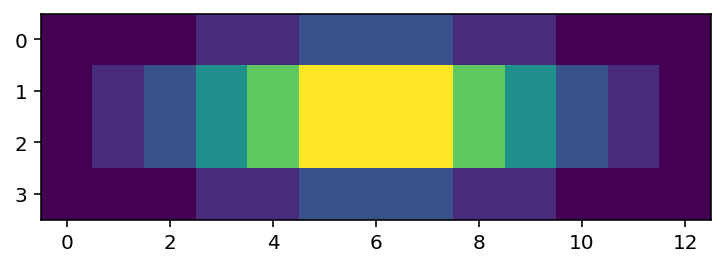

In [1180]:
neighborhood = np.array([[len(mstates[0][(k1,k2)]) for k1 in MLs] for k2 in [-3/2,-1/2,1/2,3/2]])
plt.figure()
plt.imshow(neighborhood)
plt.show()

In [ ]:
ML = ml1 + ml2 + ml3
MS = ms1 + ms2 + ms3
M = ML + MS
if (ml1, ms1) == (ml2, ms2):
    continue
if (ml1, ms1) == (ml3, ms3):
    continue
if (ml2, ms2) == (ml3, ms3):
    continue
config = [ml1,ms1,ml2,ms2,ml3,ms3,ML,MS,M]
pconfig = copy.deepcopy(config)
pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
if pconfig in configs:
    continue
pconfig = copy.deepcopy(config)
pconfig[0], pconfig[1], pconfig[4], pconfig[5] = pconfig[4], pconfig[5], pconfig[0], pconfig[1]
if pconfig in configs:
    continue
pconfig = copy.deepcopy(config)
pconfig[2], pconfig[3], pconfig[4], pconfig[5] = pconfig[4], pconfig[5], pconfig[2], pconfig[3]
if pconfig in configs:
    continue
configs.append(config)

In [8]:
def flatten(nlist):
    flist = []
    for elem in nlist:
        for it in elem:
            flist.append(it)
    return flist

In [11]:
import time
import copy

In [12]:
def termsultimate(ls):
    start_time = time.time()
    lcombos = [list(range(-l,l+1)) for l in ls]
    spins = [-1/2, 1/2]
    terminators = {0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'K',8:'L',9:'M',10:'N',11:'O',12:'P',13:'Q'}
    spincombos = [spins for l in ls]
    configs = []
    for mlcombo in product(*lcombos):
        for mscombo in product(*spincombos):
            config = set(zip(mlcombo,mscombo))
            if len(config) != len(ls):
                continue
            if config in configs:
                continue
            configs.append(config)
#     print("one",time.time()-start_time)
    MLs = range(-sum(ls),sum(ls)+1)
    spins = np.arange(-1/2*len(ls),1/2*len(ls)+1)
    microstates = {}
    for ML in MLs:
        subconfigs = [config for config in configs if sum([l[0] for l in list(config)]) == ML]
        m_configs = {}
        for mtot in spins:
            thestates = [list(config)[:len(ls)*2] for config in subconfigs if sum([l[1] for l in list(config)])==mtot]
            if len(thestates) > 0:
                microstates[(ML,mtot)] = list(map(flatten,thestates))
            else:
                microstates[(ML,mtot)] = []
#     print("two",time.time()-start_time)
    pristine_microstates = copy.deepcopy(microstates)
    # find the non-empty ones
    # from those pick the coordinates that are closest to the lower left corner
    # if it is possible to to diagonally to the upper right, then this is a boxy box
    # if not, then it is a rowy row
    # it might also be a col
#     return microstates
    collections = []
    while True:
        non_empty = [[k,abs(MLs[0]-k[0])+abs(spins[0]-k[1])] for k in microstates.keys() if len(microstates[k])>0]
        if len(non_empty) == 0:
            break
        corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
        if corner == (0,0):
            case = 'box'
            start = (0,0)
            end = (0,0)
        else:
            right = (corner[0]+1, corner[1])
            up = (corner[0], corner[1]+1)
            diag = (corner[0]+1, corner[1]+1)
            if up in microstates.keys():
                up_bool = len(microstates[up]) > 0
            else:
                up_bool = False
            if right in microstates.keys():
                right_bool = len(microstates[right]) > 0
            else:
                right_bool = False
            if diag in microstates.keys():
                diag_bool = len(microstates[diag]) > 0
            else:
                diag_bool = False
            if diag_bool and up_bool and right_bool:
                case = 'box'
                start = corner
                end = (-corner[0], -corner[1])
            elif up_bool and not right_bool:
                case = 'col'
                start = corner
                end = (corner[0],-corner[1])
            else:
                case = 'row'
                start = corner
                end = (-corner[0], corner[1])
        if case == 'row':
            collect = []
            for k in np.arange(start[0], end[0]+1):
#                 microstates[(k,0)].pop()
#                 collect.extend(pristine_microstates[(k,0)])
                collect.append(microstates[(k,0)].pop())
        elif case == 'col':
            collect = []
            for k in np.arange(start[1], end[1]+1):
#                 microstates[(start[0],k)].pop()
#                 collect.extend(pristine_microstates[(start[0],k)])
                collect.append(microstates[(start[0],k)].pop())
        elif case == 'box':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                for l in np.arange(start[1],end[1]+1):
#                     (microstates[(k,l)].pop())
#                     collect.extend(pristine_microstates[(k,l)])
                    collect.append((microstates[(k,l)].pop()))
        collections.append(collect)
#     print("three",time.time()-start_time)
#     return collections
    terms = {}
    for collection in collections:
        L = max(np.sum(np.array(collection)[:,::2],axis=1))
        S = max(np.sum(np.array(collection)[:,1::2],axis=1))
        if int(S) == S:
            S = int(S)
        multiplicity = int(2*S+1)
        if multiplicity in terms.keys():
            terms[multiplicity].append(terminators[L])
        else:
            terms[multiplicity] = [terminators[L]]
#     print("four",time.time()-start_time)
    return terms

In [21]:
ls = [3]*3
print({0:'s',1:'p',2:'d',3:'f'}[(ls[0])]+'^%d'%len(ls))
terms = termsultimate(ls)
for multi in terms:
    terms[multi] = Lsort(terms[multi])
for multi in terms.keys():
    tot = '{}^%d(%s)' % (multi,''.join(['%s%s'%(k, "" if terms[multi].count(k) == 1 else "_{"+str(terms[multi].count(k))+'}') for k in Lsort(list(set(terms[multi])))]))
    display(sp.Symbol(tot))


f^3


{}^2(D_{2}F_{2}G_{2}H_{2}IKLP)

{}^4(SDFGI)

In [17]:
Lsort(terms[2])

['D', 'D', 'F', 'F', 'G', 'G', 'H', 'H', 'I', 'K', 'L', 'P']

In [1432]:
terminators = {0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'K',8:'L',9:'M',10:'N',11:'O',12:'P',13:'Q'}

In [23]:
def Lsort(alist):
    normalOrder = {'S': 0,'P': 12,'D': 2,
                   'F': 3,'G': 4,'H': 5,
                   'I': 6,'K': 7,'L': 8,
                   'M': 9,'N': 10,'O': 11,
                   'Q': 13}
    numList = np.argsort(np.array([normalOrder[x] for x in alist]))
    return list(np.array(alist)[numList])

In [1415]:
ls = [3]*3
print({0:'s',1:'p',2:'d',3:'f'}[(ls[0])]+'^%d'%len(ls))
terms = termsultimate(ls)
for multi in terms.keys():
    tot = '{}^%d(%s)' % (multi,''.join(['%s%s'%(k, "" if terms[multi].count(k) == 1 else "_{"+str(terms[multi].count(k))+'}') for k in set(terms[multi])]))
    display(sp.Symbol(tot))


f^3


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

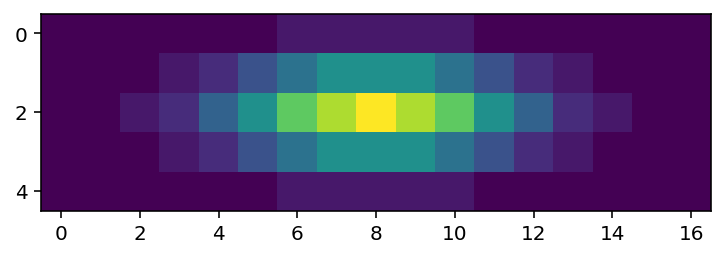

In [1377]:
neighborhood = np.array([[len(pristine_microstates[(k1,k2)]) for k1 in list(MLs)] for k2 in np.arange(-1/2*len(ls),1/2*len(ls)+1)])
plt.figure()
plt.imshow(neighborhood)
plt.show()

In [1252]:
config = np.array([0.]*(2*len(ls)))

In [1255]:
config[::2] = mlcombo
config[1::2] = mscombo
config = list(config)

[(1, 0.5), (1, 0.5), (1, 0.5), (1, 0.5)]

In [ ]:
def calculateterms(ls):
    configs = []
    spins = [-1/2, 1/2]
    for ml1 in range(-l1,l1+1):
        for ml2 in range(-l2, l2+1):
            for ml3 in range(-l3, l3+1):
                for ms1 in spins:
                    for ms2 in spins:
                        for ms3 in spins:
                            ML = ml1 + ml2 + ml3
                            MS = ms1 + ms2 + ms3
                            M = ML + MS
                            if (ml1, ms1) == (ml2, ms2):
                                continue
                            if (ml1, ms1) == (ml3, ms3):
                                continue
                            if (ml2, ms2) == (ml3, ms3):
                                continue
                            config = [ml1,ms1,ml2,ms2,ml3,ms3,ML,MS,M]
                            pconfig = copy.deepcopy(config)
                            pconfig[0], pconfig[1], pconfig[2], pconfig[3] = pconfig[2], pconfig[3], pconfig[0], pconfig[1]
                            if pconfig in configs:
                                continue
                            pconfig = copy.deepcopy(config)
                            pconfig[0], pconfig[1], pconfig[4], pconfig[5] = pconfig[4], pconfig[5], pconfig[0], pconfig[1]
                            if pconfig in configs:
                                continue
                            pconfig = copy.deepcopy(config)
                            pconfig[2], pconfig[3], pconfig[4], pconfig[5] = pconfig[4], pconfig[5], pconfig[2], pconfig[3]
                            if pconfig in configs:
                                continue
                            configs.append(config)
    MLs = range(-(l1+l2+l3),(l1+l2+l3)+1)
    microstates = {}
    for ML in MLs:
        subconfigs = [config for config in configs if config[6]==ML]
        minus1_configs = [config[:6] for config in subconfigs if config[7]==-3/2] #subconfigs[(subconfigs[:,5] == -1)]
        zero_configs = [config[:6] for config in subconfigs if config[7]==-1/2]
        plus1_configs = [config[:6] for config in subconfigs if config[7]==1/2]
        splus1_configs = [config[:6] for config in subconfigs if config[7]==3/2]
        microstates[(ML,-3/2)] = minus1_configs
        microstates[(ML,-1/2)] = zero_configs
        microstates[(ML,1/2)] = plus1_configs
        microstates[(ML,3/2)] = splus1_configs
    pristine_microstates = copy.deepcopy(microstates)
    # find the non-empty ones
    # from those pick the coordinates that are closest to the lower left corner
    # if it is possible to to diagonally to the upper right, then this is a boxy box
    # if not, then it is a row
    collections = []
    while True:
        non_empty = [[k,abs(MLs[0]-k[0])+abs(-1-k[1])] for k in microstates.keys() if len(microstates[k])>0]
        if len(non_empty) == 0:
            break
        corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
        if corner == (0,0):
            case = 'box'
            start = (0,0)
            end = (0,0)
        else:
            right = (corner[0]+1, corner[1])
            up = (corner[0], corner[1]+1)
            diag = (corner[0]+1, corner[1]+1)
            if up in microstates.keys():
                up_bool = len(microstates[up]) > 0
            else:
                up_bool = False
            if right in microstates.keys():
                right_bool = len(microstates[right]) > 0
            else:
                right_bool = False
            if diag in microstates.keys():
                diag_bool = len(microstates[diag]) > 0
            else:
                diag_bool = False
            if diag_bool and up_bool and right_bool:
                case = 'box'
                start = corner
                end = (-corner[0], -corner[1])
            elif up_bool and not right_bool:
                case = 'col'
                start = corner
                end = (corner[0],-corner[1])
            else:
                case = 'row'
                start = corner
                end = (-corner[0], corner[1])
        if case == 'row':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                microstates[(k,0)].pop()
                collect.extend(pristine_microstates[(k,0)])
        elif case == 'col':
            collect = []
            for k in np.arange(start[1], end[1]+1):
                microstates[(start[0],k)].pop()
                collect.extend(pristine_microstates[(start[0],k)])
        elif case == 'box':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                for l in np.arange(start[1],end[1]+1):
                    (microstates[(k,l)].pop())
                    collect.extend(pristine_microstates[(k,l)])
        collections.append(collect)

    terms = {}
#     return pristine_microstates, collections
    for collection in collections:
        L = max(np.array(collection)[:,0] + np.array(collection)[:,2] + np.array(collection)[:,4])
        S = max(np.array(collection)[:,1] + np.array(collection)[:,3] + np.array(collection)[:,5])
        if int(S) == S:
            S = int(S)
        multiplicity = int(2*S+1)
        if multiplicity in terms.keys():
            terms[multiplicity].append({0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'J',8:'K'}[L])
        else:
            terms[multiplicity] = [{0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'J',8:'K'}[L]]
    return pristine_microstates, terms

In [732]:
big_bag = []
while True:
    non_empty = [[k,abs(MLs[0]-k[0])+abs(-1-k[1])] for k in microstates.keys() if len(microstates[k])>0]
    if len(non_empty) == 0:
        break
    if len(non_empty) == 1:
        bag = [microstates[non_empty.keys()[0]]]
        big_bag = big_bag.append(bag)
        continue
    corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
    start_corner = tuple(corner)
    print(corner)
#     bag = [microstates[corner].pop()]
    jumps = []
    while True:
        if corner[1] < 1:
            up = (corner[0], corner[1] + 1)
            if up in microstates.keys():
                up_microstates = microstates[up]
            else:
                up_microstates = []
        if corner[0] < MLs[-1]:
            right = (corner[0]+1, corner[1])
            if right in microstates.keys():
                right_microstates = microstates[right]
            else:
                right_microstates = []
        if corner[1]<1 and corner[0] < MLs[-1]:
            diag = (corner[0]+1, corner[1]+1)
            if diag in microstates.keys():
                diag_microstates = microstates[diag]
            else:
                diag_microstates = []
        else:
            break
        if (len(right_microstates) > 0) and (len(up_microstates) > 0) and ('right' not in jumps) and ('up' not in jumps):
            print('D')
            jump = 'diagonal'
        elif len(right_microstates) > 0:
            print('R')
            jump = 'right'
        elif len(up_microstates) > 0:
            print('U')
            jump = 'up'
        else:
            jump = 'finish'
        if jump == 'diagonal':
            corner = (corner[0]+1, corner[1]+1)
        elif jump == 'right':
            corner = (corner[0]+1, corner[1])
        elif jump == 'up':
            corner = (corner[0], corner[1]+1)
        elif jump == 'finish':
            break
        jumps.append(jump)
    print(start_corner, corner)
    end_corner = tuple(corner)
    bag = [microstates[(h,v)].pop() for h in range(start_corner[0],end_corner[0]+1) for v in range(start_corner[1], end_corner[1]+1)]
    big_bag.append(bag)

(-4, 0)
R
R
R
R
R
R
R
R
(-4, 0) (4, 0)
(-3, -1)
D
D
(-3, -1) (-1, 1)
(-2, 0)
R
R
R
R
R
U
(-2, 0) (3, 1)


IndexError: pop from empty list

In [699]:
for bag in big_bag:
    print(len(bag))

9
9
7
5
5
5
3
1
1


In [700]:
big_bag[1]

[[-2, Fraction(-1, 2), -1, Fraction(-1, 2)],
 [-2, Fraction(-1, 2), 0, Fraction(-1, 2)],
 [-1, Fraction(-1, 2), 0, Fraction(-1, 2)],
 [-1, Fraction(-1, 2), 1, Fraction(-1, 2)],
 [0, Fraction(-1, 2), 1, Fraction(-1, 2)],
 [0, Fraction(-1, 2), 2, Fraction(-1, 2)],
 [1, Fraction(-1, 2), 2, Fraction(-1, 2)],
 [1, Fraction(-1, 2), 2, Fraction(1, 2)],
 [1, Fraction(1, 2), 2, Fraction(1, 2)]]

In [585]:
non_empty = np.array(non_empty, dtype=object)
corner = np.argsort(non_empty[:,1])[0]
chunk = microstates[non_empty[corner][0]][0][:4]
bag = [chunk]
del microstates[non_empty[corner][0]][0]

ValueError: cannot delete array elements

array([-1, Fraction(-1, 2), -1, Fraction(1, 2)], dtype=object)

In [571]:
microstates[(-2,0)]

array([[-1, Fraction(-1, 2), -1, Fraction(1, 2), -2, Fraction(0, 1),
        Fraction(-2, 1)]], dtype=object)

In [566]:
microstates[non_empty[corner][0]]

array([[-1, Fraction(-1, 2), -1, Fraction(1, 2), -2, Fraction(0, 1),
        Fraction(-2, 1)]], dtype=object)

In [555]:
non_empty[corner]

array([(-2, 0), 1], dtype=object)

In [539]:
corner

array([ 0,  3,  2,  6,  1,  5,  9,  4,  8,  7, 10])

In [508]:
MLs = sorted(list(set(np.abs(configs[:,4]))))
terms = []
for ML in MLs:
    print("ML =",ML)
    subconfigs = configs[np.abs(configs[:,4]) == ML]
    for MS in range(0,ML+1):
        print("-- |MS| <=",MS)
        counter = sum(np.abs(subconfigs[:,5]) <= MS)
        print("----",counter)
        if counter > 0:
            terms.append(2*MS + 1)
    print("------")

ML = 0
-- |MS| <= 0
---- 3
------
ML = 1
-- |MS| <= 0
---- 4
-- |MS| <= 1
---- 8
------
ML = 2
-- |MS| <= 0
---- 2
-- |MS| <= 1
---- 2
-- |MS| <= 2
---- 2
------


In [509]:
terms

[1, 1, 3, 1, 3, 5]

In [485]:
subconfigs

array([[-1, Fraction(-1, 2), -1, Fraction(1, 2), -2, Fraction(0, 1),
        Fraction(-2, 1)],
       [1, Fraction(-1, 2), 1, Fraction(1, 2), 2, Fraction(0, 1),
        Fraction(2, 1)]], dtype=object)

In [417]:
for config in configs:
    mL = config[4]
    ml1, ms1, ml2, ms2 = config[:4]
    if mL == 1:
        ms1 = {Fraction(1,2):'+',-Fraction(1,2):'-'}[ms1]
        ms2 = {Fraction(1,2):'+',-Fraction(1,2):'-'}[ms2]
        symb = sp.Symbol("|%d,%s,%d,%s\\rangle" % (ml1,ms1,ml2,ms2))
        if ml1 < 0:
            ml1 = r'\bar{%d}' % (-ml1)
        else:
            ml1 = r'{%d}' % ml1
        if ml2 < 0:
            ml2 = r'\bar{%d}' % (-ml2)
        else:
            ml2 = r'{%d}' % ml2
        symb = ''.join([ml1,ms1,ml2,ms2])
        symb = r'|%s\rangle' % symb
        symb = sp.Symbol(symb)
        display(symb)

|\bar{1}-{2}-\rangle

|\bar{1}-{2}+\rangle

|\bar{1}+{2}-\rangle

|\bar{1}+{2}+\rangle

|{0}-{1}-\rangle

|{0}-{1}+\rangle

|{0}+{1}-\rangle

|{0}+{1}+\rangle

In [382]:
for config in configs:
    ml1, ms1, ml2, ms2 = config[:4]
    ms1 = {Fraction(1,2):'+',-Fraction(1,2):'-'}[ms1]
    ms2 = {Fraction(1,2):'+',-Fraction(1,2):'-'}[ms2]
    symb = sp.Symbol("|%d,%s,%d,%s\\rangle" % (ml1,ms1,ml2,ms2))
    if ml1 < 0:
        ml1 = r'\bar{%d}' % (-ml1)
    else:
        ml1 = r'{%d}' % ml1
    if ml2 < 0:
        ml2 = r'\bar{%d}' % (-ml2)
    else:
        ml2 = r'{%d}' % ml2
    symb = ''.join([ml1,ms1,ml2,ms2])
    symb = r'|%s\rangle' % symb
    symb = sp.Symbol(symb)
    display(symb)

|\bar{1}-\bar{1}+\rangle

|\bar{1}-{0}-\rangle

|\bar{1}-{0}+\rangle

|\bar{1}+{0}-\rangle

|\bar{1}+{0}+\rangle

|\bar{1}-{1}-\rangle

|\bar{1}-{1}+\rangle

|\bar{1}+{1}-\rangle

|\bar{1}+{1}+\rangle

|{0}-{0}+\rangle

|{0}-{1}-\rangle

|{0}-{1}+\rangle

|{0}+{1}-\rangle

|{0}+{1}+\rangle

|{1}-{1}+\rangle

In [459]:
# another way of doing this
# no this is not correct, see comment at end of cell
l1, l2 = 1, 1
# is first figuring out the possible total angular momenta for the given l1, l2
Ls = list(map(Fraction,np.arange(abs(l1-l2),l1+l2+1,1)))
# then to this we see what results when one adds the possible total spin
# angular momenta which is either 0 or 1
Js = []
for L in Ls:
    js = list(map(Fraction,np.arange(abs(L-1),L+1,1)))
    Js.extend(js)
Js.extend(Ls)
Js = list(map(float,Js))
unique_Js = list(set(Js))
for u_J in unique_Js:
    print({0:'S',1:'P',2:'D',3:'F',4:'G'}[u_J], Js.count(u_J))
# This is incorrect, this simple addition of angular momenta
# doesn't take into account Pauli's exclusion principle

<ipython-input-459-308a5d40e5a1>:10: DeprecationWarning: Fraction.__float__ returned non-float (type numpy.float64).  The ability to return an instance of a strict subclass of float is deprecated, and may be removed in a future version of Python.
  js = list(map(Fraction,np.arange(abs(L-1),L+1,1)))
<ipython-input-459-308a5d40e5a1>:13: DeprecationWarning: Fraction.__float__ returned non-float (type numpy.float64).  The ability to return an instance of a strict subclass of float is deprecated, and may be removed in a future version of Python.
  Js = list(map(float,Js))


S 2
P 3
D 2


#### Tidy

##### slow

In [185]:
def termsultimate_superslow(ls):
    start_time = time.time()
    lcombos = [list(range(-l,l+1)) for l in ls]
    spins = [-1/2, 1/2]
    terminators = {0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'K',8:'L',9:'M',10:'N',11:'O',12:'Q',13:'R',14:'T',15:'U',16:'V'}
    spincombos = [spins]*len(ls)
    configs = []
    # most time is spent in this loop
    for mlcombo in product(*lcombos):
        for mscombo in product(*spincombos):
            config = set(zip(mlcombo,mscombo))
            if len(config) != len(ls): # this leaves out configs that have repeated groups of (l,ml,s,ms)
                continue
            if config in configs: # this leaves out configs that were already added
                continue
            configs.append(config) # configs are sets not lists, this takes into account the fact that ordering is irrelevant

    MLs = range(-sum(ls),sum(ls)+1)
    spins = np.arange(-1/2*len(ls),1/2*len(ls)+1)
    microstates = {}
    for ML in MLs:
        subconfigs = [config for config in configs if sum([l[0] for l in list(config)]) == ML]
        m_configs = {}
        for mtot in spins:
            thestates = [list(config)[:len(ls)*2] for config in subconfigs if sum([l[1] for l in list(config)])==mtot]
            if len(thestates) > 0:
                microstates[(ML,mtot)] = list(map(flatten,thestates))
            else:
                microstates[(ML,mtot)] = []

    # find the non-empty ones
    # from those pick the coordinates that are closest to the lower left corner
    # if it is possible to to diagonally to the upper right, then this is a boxy box
    # if not, then it is a rowy row
    # it might also be a column
    collections = []
    while True:
        non_empty = [[k,abs(MLs[0]-k[0])+abs(spins[0]-k[1])] for k in microstates.keys() if len(microstates[k])>0]
        if len(non_empty) == 0:
            break
        corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
        if corner == (0,0):
            case = 'box'
            start = (0,0)
            end = (0,0)
        else:
            right = (corner[0]+1, corner[1])
            up = (corner[0], corner[1]+1)
            diag = (corner[0]+1, corner[1]+1)
            if up in microstates.keys():
                up_bool = len(microstates[up]) > 0
            else:
                up_bool = False
            if right in microstates.keys():
                right_bool = len(microstates[right]) > 0
            else:
                right_bool = False
            if diag in microstates.keys():
                diag_bool = len(microstates[diag]) > 0
            else:
                diag_bool = False
            if diag_bool and up_bool and right_bool:
                case = 'box'
                start = corner
                end = (-corner[0], -corner[1])
            elif up_bool and not right_bool:
                case = 'col'
                start = corner
                end = (corner[0],-corner[1])
            else:
                case = 'row'
                start = corner
                end = (-corner[0], corner[1])
        if case == 'row':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                collect.append(microstates[(k,0)].pop())
        elif case == 'col':
            collect = []
            for k in np.arange(start[1], end[1]+1):
                collect.append(microstates[(start[0],k)].pop())
        elif case == 'box':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                for l in np.arange(start[1],end[1]+1):
                    collect.append((microstates[(k,l)].pop()))
        collections.append(collect)
    terms = {}
    for collection in collections:
        L = max(np.sum(np.array(collection)[:,::2],axis=1))
        S = max(np.sum(np.array(collection)[:,1::2],axis=1))
        if int(S) == S:
            S = int(S)
        multiplicity = int(2*S+1)
        if multiplicity in terms.keys():
            terms[multiplicity].append(terminators[L])
        else:
            terms[multiplicity] = [terminators[L]]
    return terms

In [186]:
les_terms = {}
for l in [0,1]:
    these_terms = {}
    for i in range(1,4*l+2):
        if (4*l+2 - i) in these_terms.keys():
            these_terms[i] = these_terms[(4*l+2 - i)]
            econfig = ('\\text{%s}'%{0:'s',1:'p',2:'d',3:'f'}[(ls[0])]+'^{%d}'%((i)))
            tot = econfig+':\,\,'
            terms = these_terms[i]
            for multi in terms.keys():
                tot += '{}^%d(%s)\,\,' % (multi,''.join(['\\text{%s}%s'%(k, "" if terms[multi].count(k) == 1 else "_{"+str(terms[multi].count(k))+'}') for k in Lsort(list(set(terms[multi])))]))
            display(sp.Symbol(tot))
            continue
        ls = [l]*i
        econfig = ('\\text{%s}'%{0:'s',1:'p',2:'d',3:'f'}[(ls[0])]+'^{%d}'%len(ls))
        terms = termsultimate_superslow(ls)
        these_terms[i] = terms
        tot = econfig+':\,\,'
        for multi in terms.keys():
            tot += '{}^%d(%s)\,\,' % (multi,''.join(['\\text{%s}%s'%(k, "" if terms[multi].count(k) == 1 else "_{"+str(terms[multi].count(k))+'}') for k in Lsort(list(set(terms[multi])))]))

        display(sp.Symbol(tot))
    les_terms[l] = these_terms

\text{s}^{1}:\,\,{}^2(\text{S})\,\,

\text{p}^{1}:\,\,{}^2(\text{P})\,\,

\text{p}^{2}:\,\,{}^1(\text{S}\text{D})\,\,{}^3(\text{P})\,\,

\text{p}^{3}:\,\,{}^2(\text{P}\text{D})\,\,{}^4(\text{S})\,\,

\text{p}^{4}:\,\,{}^1(\text{S}\text{D})\,\,{}^3(\text{P})\,\,

\text{p}^{5}:\,\,{}^2(\text{P})\,\,

##### fast

In [232]:
from itertools import permutations
from itertools import combinations

In [233]:
def single_electron_states(l):
    single_states = []
    mLs = list(range(-l,l+1))
    for mL in mLs:
        for mS in [-1/2,1/2]:
            single_states.append((mL,mS))
    return single_states
def multi_electron_states(l,n):
    singles = single_electron_states(l)

In [235]:
def Lsort(alist):
    normalOrder = {'S': 0,'P': 1,'D': 2,
                   'F': 3,'G': 4,'H': 5,
                   'I': 6,'K': 7,'L': 8,
                   'M': 9,'N': 10,'O': 11,
                   'Q': 12,'R': 13,'T': 14,
                   'U': 15, 'V': 16, 'W': 17,
                   'X': 18, 'Y': 19, 'Z': 20}
    numList = np.argsort(np.array([normalOrder[x] for x in alist]))
    return list(np.array(alist)[numList])

In [236]:
def termsultimate(l,n):
    ls = [l]*n
    start_time = time.time()
    lcombos = [list(range(-l,l+1)) for l in ls]
    spins = [-1/2, 1/2]
    terminators = {0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'K',8:'L',
                   9:'M',10:'N',11:'O',12:'Q',13:'R',14:'T',15:'U',16:'V',
                  17:'W',18:'X',19:'Y',20:'Z'}
    spincombos = [spins]*len(ls)
    configs = list(map(set,list(combinations(single_electron_states(l),n))))
    MLs = range(-sum(ls),sum(ls)+1)
    spins = np.arange(-1/2*len(ls),1/2*len(ls)+1)
    microstates = {}
    for ML in MLs:
        subconfigs = [config for config in configs if sum([l[0] for l in list(config)]) == ML]
        m_configs = {}
        for mtot in spins:
            thestates = [list(config)[:len(ls)*2] for config in subconfigs if sum([l[1] for l in list(config)])==mtot]
            if len(thestates) > 0:
                microstates[(ML,mtot)] = list(map(flatten,thestates))
            else:
                microstates[(ML,mtot)] = []
    # find the non-empty ones
    # from those pick the coordinates that are closest to the lower left corner
    # if it is possible to to diagonally to the upper right, then this is a boxy box
    # if not, then it is a rowy row
    # it might also be a columny col
    collections = []
    while True:
        non_empty = [[k,abs(MLs[0]-k[0])+abs(spins[0]-k[1])] for k in microstates.keys() if len(microstates[k])>0]
        if len(non_empty) == 0:
            break
        corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
        if corner == (0,0):
            case = 'box'
            start = (0,0)
            end = (0,0)
        else:
            right = (corner[0]+1, corner[1])
            up = (corner[0], corner[1]+1)
            diag = (corner[0]+1, corner[1]+1)
            if up in microstates.keys():
                up_bool = len(microstates[up]) > 0
            else:
                up_bool = False
            if right in microstates.keys():
                right_bool = len(microstates[right]) > 0
            else:
                right_bool = False
            if diag in microstates.keys():
                diag_bool = len(microstates[diag]) > 0
            else:
                diag_bool = False
            if diag_bool and up_bool and right_bool:
                case = 'box'
                start = corner
                end = (-corner[0], -corner[1])
            elif up_bool and not right_bool:
                case = 'col'
                start = corner
                end = (corner[0],-corner[1])
            else:
                case = 'row'
                start = corner
                end = (-corner[0], corner[1])
        if case == 'row':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                collect.append(microstates[(k,0)].pop())
        elif case == 'col':
            collect = []
            for k in np.arange(start[1], end[1]+1):
                collect.append(microstates[(start[0],k)].pop())
        elif case == 'box':
            collect = []
            for k in np.arange(start[0], end[0]+1):
                for l in np.arange(start[1],end[1]+1):
                    collect.append((microstates[(k,l)].pop()))
        collections.append(collect)
    terms = {}
    for collection in collections:
        L = max(np.sum(np.array(collection)[:,::2],axis=1))
        S = max(np.sum(np.array(collection)[:,1::2],axis=1))
        if int(S) == S:
            S = int(S)
        multiplicity = int(2*S+1)
        if multiplicity in terms.keys():
            terms[multiplicity].append(terminators[L])
        else:
            terms[multiplicity] = [terminators[L]]
    return terms

In [237]:
les_terms = {}
ls = [0,1,2,3]
for l in ls:
    these_terms = {}
    for i in range(1,4*l+2):
        if (4*l+2 - i) in these_terms.keys():
            these_terms[i] = these_terms[(4*l+2 - i)]
            continue
        terms = termsultimate(l,i)
        these_terms[i] = terms
    these_terms[4*l+2] = {1:['S']}
    les_terms[l] = these_terms
output = []
for l in ls:
    for i in range(1,4*l+2+1):
        econfig = ('\\text{%s}'%{0:'s',1:'p',2:'d',3:'f',4:'g'}[(l)]+'^{%d}'%i)
        terms = les_terms[l][i]
        tot = econfig +':\,\,'
        num_terms = sum([len(v) for k, v in terms.items()])
        for multi in terms.keys():
            tot += '{}^%d(%s)\,\,' % (multi,''.join(['\\text{%s}%s'%(k, "" if terms[multi].count(k) == 1 else "_{"+str(terms[multi].count(k))+'}') for k in Lsort(list(set(terms[multi])))]))
        tot = tot + ('\,\,:\,\, ... %d' % num_terms)
        output.append(tot)
        display(sp.Symbol(tot))

\text{s}^{1}:\,\,{}^2(\text{S})\,\,\,\,:\,\, ... 1

\text{s}^{2}:\,\,{}^1(\text{S})\,\,\,\,:\,\, ... 1

\text{p}^{1}:\,\,{}^2(\text{P})\,\,\,\,:\,\, ... 1

\text{p}^{2}:\,\,{}^1(\text{S}\text{D})\,\,{}^3(\text{P})\,\,\,\,:\,\, ... 3

\text{p}^{3}:\,\,{}^2(\text{P}\text{D})\,\,{}^4(\text{S})\,\,\,\,:\,\, ... 3

\text{p}^{4}:\,\,{}^1(\text{S}\text{D})\,\,{}^3(\text{P})\,\,\,\,:\,\, ... 3

\text{p}^{5}:\,\,{}^2(\text{P})\,\,\,\,:\,\, ... 1

\text{p}^{6}:\,\,{}^1(\text{S})\,\,\,\,:\,\, ... 1

\text{d}^{1}:\,\,{}^2(\text{D})\,\,\,\,:\,\, ... 1

\text{d}^{2}:\,\,{}^1(\text{S}\text{D}\text{G})\,\,{}^3(\text{P}\text{F})\,\,\,\,:\,\, ... 5

\text{d}^{3}:\,\,{}^2(\text{P}\text{D}_{2}\text{F}\text{G}\text{H})\,\,{}^4(\text{P}\text{F})\,\,\,\,:\,\, ... 8

\text{d}^{4}:\,\,{}^1(\text{S}_{2}\text{D}_{2}\text{F}\text{G}_{2}\text{I})\,\,{}^3(\text{P}_{2}\text{D}\text{F}_{2}\text{G}\text{H})\,\,{}^5(\text{D})\,\,\,\,:\,\, ... 16

\text{d}^{5}:\,\,{}^2(\text{S}\text{P}\text{D}_{3}\text{F}_{2}\text{G}_{2}\text{H}\text{I})\,\,{}^4(\text{P}\text{D}\text{F}\text{G})\,\,{}^6(\text{S})\,\,\,\,:\,\, ... 16

\text{d}^{6}:\,\,{}^1(\text{S}_{2}\text{D}_{2}\text{F}\text{G}_{2}\text{I})\,\,{}^3(\text{P}_{2}\text{D}\text{F}_{2}\text{G}\text{H})\,\,{}^5(\text{D})\,\,\,\,:\,\, ... 16

\text{d}^{7}:\,\,{}^2(\text{P}\text{D}_{2}\text{F}\text{G}\text{H})\,\,{}^4(\text{P}\text{F})\,\,\,\,:\,\, ... 8

\text{d}^{8}:\,\,{}^1(\text{S}\text{D}\text{G})\,\,{}^3(\text{P}\text{F})\,\,\,\,:\,\, ... 5

\text{d}^{9}:\,\,{}^2(\text{D})\,\,\,\,:\,\, ... 1

\text{d}^{10}:\,\,{}^1(\text{S})\,\,\,\,:\,\, ... 1

\text{f}^{1}:\,\,{}^2(\text{F})\,\,\,\,:\,\, ... 1

\text{f}^{2}:\,\,{}^1(\text{S}\text{D}\text{G}\text{I})\,\,{}^3(\text{P}\text{F}\text{H})\,\,\,\,:\,\, ... 7

\text{f}^{3}:\,\,{}^2(\text{P}\text{D}_{2}\text{F}_{2}\text{G}_{2}\text{H}_{2}\text{I}\text{K}\text{L})\,\,{}^4(\text{S}\text{D}\text{F}\text{G}\text{I})\,\,\,\,:\,\, ... 17

\text{f}^{4}:\,\,{}^1(\text{S}_{2}\text{D}_{4}\text{F}\text{G}_{4}\text{H}_{2}\text{I}_{3}\text{K}\text{L}_{2}\text{N})\,\,{}^3(\text{P}_{3}\text{D}_{2}\text{F}_{4}\text{G}_{3}\text{H}_{4}\text{I}_{2}\text{K}_{2}\text{L}\text{M})\,\,{}^5(\text{S}\text{D}\text{F}\text{G}\text{I})\,\,\,\,:\,\, ... 47

\text{f}^{5}:\,\,{}^2(\text{P}_{4}\text{D}_{5}\text{F}_{7}\text{G}_{6}\text{H}_{7}\text{I}_{5}\text{K}_{5}\text{L}_{3}\text{M}_{2}\text{N}\text{O})\,\,{}^4(\text{S}\text{P}_{2}\text{D}_{3}\text{F}_{4}\text{G}_{4}\text{H}_{3}\text{I}_{3}\text{K}_{2}\text{L}\text{M})\,\,{}^6(\text{P}\text{F}\text{H})\,\,\,\,:\,\, ... 73

\text{f}^{6}:\,\,{}^1(\text{S}_{4}\text{P}\text{D}_{6}\text{F}_{4}\text{G}_{8}\text{H}_{4}\text{I}_{7}\text{K}_{3}\text{L}_{4}\text{M}_{2}\text{N}_{2}\text{Q})\,\,{}^3(\text{P}_{6}\text{D}_{5}\text{F}_{9}\text{G}_{7}\text{H}_{9}\text{I}_{6}\text{K}_{6}\text{L}_{3}\text{M}_{3}\text{N}\text{O})\,\,{}^5(\text{S}\text{P}\text{D}_{3}\text{F}_{2}\text{G}_{3}\text{H}_{2}\text{I}_{2}\text{K}\text{L})\,\,{}^7(\text{F})\,\,\,\,:\,\, ... 119

\text{f}^{7}:\,\,{}^2(\text{S}_{2}\text{P}_{5}\text{D}_{7}\text{F}_{10}\text{G}_{10}\text{H}_{9}\text{I}_{9}\text{K}_{7}\text{L}_{5}\text{M}_{4}\text{N}_{2}\text{O}\text{Q})\,\,{}^4(\text{S}_{2}\text{P}_{2}\text{D}_{6}\text{F}_{5}\text{G}_{7}\text{H}_{5}\text{I}_{5}\text{K}_{3}\text{L}_{3}\text{M}\text{N})\,\,{}^6(\text{P}\text{D}\text{F}\text{G}\text{H}\text{I})\,\,{}^8(\text{S})\,\,\,\,:\,\, ... 119

\text{f}^{8}:\,\,{}^1(\text{S}_{4}\text{P}\text{D}_{6}\text{F}_{4}\text{G}_{8}\text{H}_{4}\text{I}_{7}\text{K}_{3}\text{L}_{4}\text{M}_{2}\text{N}_{2}\text{Q})\,\,{}^3(\text{P}_{6}\text{D}_{5}\text{F}_{9}\text{G}_{7}\text{H}_{9}\text{I}_{6}\text{K}_{6}\text{L}_{3}\text{M}_{3}\text{N}\text{O})\,\,{}^5(\text{S}\text{P}\text{D}_{3}\text{F}_{2}\text{G}_{3}\text{H}_{2}\text{I}_{2}\text{K}\text{L})\,\,{}^7(\text{F})\,\,\,\,:\,\, ... 119

\text{f}^{9}:\,\,{}^2(\text{P}_{4}\text{D}_{5}\text{F}_{7}\text{G}_{6}\text{H}_{7}\text{I}_{5}\text{K}_{5}\text{L}_{3}\text{M}_{2}\text{N}\text{O})\,\,{}^4(\text{S}\text{P}_{2}\text{D}_{3}\text{F}_{4}\text{G}_{4}\text{H}_{3}\text{I}_{3}\text{K}_{2}\text{L}\text{M})\,\,{}^6(\text{P}\text{F}\text{H})\,\,\,\,:\,\, ... 73

\text{f}^{10}:\,\,{}^1(\text{S}_{2}\text{D}_{4}\text{F}\text{G}_{4}\text{H}_{2}\text{I}_{3}\text{K}\text{L}_{2}\text{N})\,\,{}^3(\text{P}_{3}\text{D}_{2}\text{F}_{4}\text{G}_{3}\text{H}_{4}\text{I}_{2}\text{K}_{2}\text{L}\text{M})\,\,{}^5(\text{S}\text{D}\text{F}\text{G}\text{I})\,\,\,\,:\,\, ... 47

\text{f}^{11}:\,\,{}^2(\text{P}\text{D}_{2}\text{F}_{2}\text{G}_{2}\text{H}_{2}\text{I}\text{K}\text{L})\,\,{}^4(\text{S}\text{D}\text{F}\text{G}\text{I})\,\,\,\,:\,\, ... 17

\text{f}^{12}:\,\,{}^1(\text{S}\text{D}\text{G}\text{I})\,\,{}^3(\text{P}\text{F}\text{H})\,\,\,\,:\,\, ... 7

\text{f}^{13}:\,\,{}^2(\text{F})\,\,\,\,:\,\, ... 1

\text{f}^{14}:\,\,{}^1(\text{S})\,\,\,\,:\,\, ... 1

In [152]:
faster == configs

False